In [1]:
# MASTER_subsampling script

#--------------------------------------------------------------
## using Rödenbeck product with FESOM instead of OCIM prior
#--------------------------------------------------------------
## and using Landschützer with FESOM kw
#--------------------------------------------------------------

# a couple of typical settings just in case they may be useful here, too

%autosave 10

import sys
import os
sys.path.append('../')

import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from netCDF4 import Dataset
#import gcb_iav
from annualmean import annualmean
from integrate_CO2flux import integrate_CO2flux
#from regional_average_pCO2 import reg_ave_pCO2  # this one doesn't work (total area is calculated also where there is no data, hence means become too small)

from matplotlib.pyplot import cm
from numpy import genfromtxt #loadtxt
from matplotlib.ticker import MultipleLocator
import seawater as sw
import scipy.signal

import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


import calendar
import matplotlib.patches as mpatches


# experiments:
# A, B, C

# A: SOCAT only
# B: SOCAT+SOCCOM
# C: ARGO


# Rödenbeck: 1958 - 2019
# Landschützer: 1982 - 2018 (?, 444 monthly entries)


SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Autosaving every 10 seconds
[NbConvertApp] Converting notebook annualmean.ipynb to python
[NbConvertApp] Writing 2130 bytes to annualmean.py
[NbConvertApp] Converting notebook integrate_CO2flux.ipynb to python
[NbConvertApp] Writing 5022 bytes to integrate_CO2flux.py


(756, 180, 360)
[  0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5
  12.5  13.5  14.5  15.5  16.5  17.5  18.5  19.5  20.5  21.5  22.5  23.5
  24.5  25.5  26.5  27.5  28.5  29.5  30.5  31.5  32.5  33.5  34.5  35.5
  36.5  37.5  38.5  39.5  40.5  41.5  42.5  43.5  44.5  45.5  46.5  47.5
  48.5  49.5  50.5  51.5  52.5  53.5  54.5  55.5  56.5  57.5  58.5  59.5
  60.5  61.5  62.5  63.5  64.5  65.5  66.5  67.5  68.5  69.5  70.5  71.5
  72.5  73.5  74.5  75.5  76.5  77.5  78.5  79.5  80.5  81.5  82.5  83.5
  84.5  85.5  86.5  87.5  88.5  89.5  90.5  91.5  92.5  93.5  94.5  95.5
  96.5  97.5  98.5  99.5 100.5 101.5 102.5 103.5 104.5 105.5 106.5 107.5
 108.5 109.5 110.5 111.5 112.5 113.5 114.5 115.5 116.5 117.5 118.5 119.5
 120.5 121.5 122.5 123.5 124.5 125.5 126.5 127.5 128.5 129.5 130.5 131.5
 132.5 133.5 134.5 135.5 136.5 137.5 138.5 139.5 140.5 141.5 142.5 143.5
 144.5 145.5 146.5 147.5 148.5 149.5 150.5 151.5 152.5 153.5 154.5 155.5
 156.5 157.5 158.5 159.5 160.5 161.

<ipython-input-2-a48820d755c8>:72: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(reg_lon,reg_lat,reg_arc)#, vmin=-60, vmax=750)


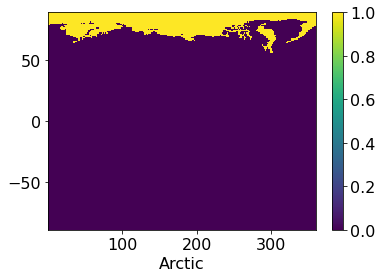

In [2]:
# some definitions, time and area

firstyear=1958
lastyear=2021 # always one more than actually analysed

#define time range for nc data 
gcb_time = np.arange(firstyear,lastyear-1./24,step=1./12)
tsteps = (lastyear-firstyear)*12
gcb_years = np.arange(firstyear,lastyear)

# print(np.shape(gcb_time))
# print(tsteps)
# print(gcb_years,np.shape(gcb_years))
# print(gcb_time)

#### initializing Area matrix
xax = np.arange(0.5,360.5,1)
yax = np.arange(-89.5,90.5,1)

xi = np.arange(-180,181,1) #longitude
yi = np.arange(-90,91,1) #latitude
Aarea = np.zeros((len(xi)-1,len(yi)-1))

#calculate area
for i in range(0,len(xi)-1): #laenge pruefen!
    for j in range(0,len(yi)-1): #laenge pruefen!
       #sw_dist aus matlab umsetzen
       dist1 = sw.dist([yi[j],yi[j+1]],[xi[i],xi[i]])
       dist2 = sw.dist([yi[j],yi[j]],[xi[i],xi[i+1]])
       Aarea[i][j] = float(dist1[0]) * float(dist2[0]) *1000 *1000 #m2
#flachen ueberall gleich gross?
Aarea = Aarea.transpose()    

areaT = np.tile(Aarea,(tsteps,1,1))


#print(np.shape(Aarea),np.shape(areaT))

indglob = np.where(yax < 90) 
indN = np.where((yax > 30) & (yax < 90)) 
indS = np.where((yax < -30) & (yax > -90)) 
indT = np.where((yax>-30) & (yax<30))

nt=tsteps
nx=len(xax)
ny=len(yax)

yax2=yax[np.newaxis,:,np.newaxis]
YY = np.tile(yax2,(nt,1,nx))

maskG = (YY[:] < 90)
maskN = ((YY[:]>30))
maskN60 = ((YY[:]>30)& (YY[:] <= 60))
maskArc = (YY[:]>60)
maskS = (YY[:]<-30)
maskT = ((YY[:]>-30) & (YY[:] < 30))

print(np.shape(maskN))

# load reccap regions mask:

regions = Dataset('/work/ollie/jhauck/reccap/RECCAP2-shared-resources/data/regions/RECCAP2_region_masks_all.nc',mode='r')
reg_lon = regions['lon'][:]
reg_lat = regions['lat'][:]
reg_arc = regions['arctic'][:]
reg_arc[reg_arc>0]=1
reg_arcT = np.tile(reg_arc,(nt,1,1))

print(reg_lon, reg_lat)

plt.figure()
plt.pcolor(reg_lon,reg_lat,reg_arc)#, vmin=-60, vmax=750)
plt.colorbar()
plt.xlabel('Arctic')
plt.show()

In [3]:
# for fesom, 12 time-steps less

fYY = np.tile(yax2,(nt-12,1,nx))
print(np.shape(fYY))

fareaT = np.tile(Aarea,(tsteps-12,1,1))
print(np.shape(fareaT))

freg_arcT =np.tile(reg_arc,(nt-12,1,1))
print(np.shape(freg_arcT))

(744, 180, 360)
(744, 180, 360)
(744, 180, 360)


In [4]:
print(61*12)

732


In [5]:
# print(gcb_years)
# print(gcb_years[24])
# print(gcb_years[61])
# print(tsteps)
# print(gcb_time)

# print(gcb_time[24*12+1])
# print(gcb_time[61*12])


ind1 = 24*12      # start index, monthly time-series, 1982
ind2 = 61*12   # end index, monthly time-series, end 2018

#print(gcb_time[51*12+1])
ind2009 = 51*12

#print(ind1,ind2,ind2009)

#print(np.shape(gcb_time[ind1:ind2]),np.shape(gcb_time[ind2009:ind2]))
print(gcb_time[24*12])
print(gcb_time[ind1:ind2])

indx = np.where((gcb_time>1981.95) & (gcb_time<2019))
print(gcb_time[indx])
print(indx)


# first again some definitions:
# for annual data!!!!

ind = np.where((gcb_years>=2009) & (gcb_years<=2018))
print(ind,gcb_years[ind])

# for trend 2000 - 2018:

ind2000 = np.where((gcb_years>=2000) & (gcb_years<=2018))
print(ind2000,gcb_years[ind2000])

# common years 1982 to 2018
ind_com = np.where((gcb_years>=1982) & (gcb_years<=2018))

# for monthly data:
ind_2009_2018_monthly = np.where((gcb_time>=2008.99) & (gcb_time<2018.95))
print(gcb_time[ind_2009_2018_monthly], np.shape(gcb_time[ind_2009_2018_monthly]))


1981.9999999999782
[1982.         1982.08333333 1982.16666667 1982.25       1982.33333333
 1982.41666667 1982.5        1982.58333333 1982.66666667 1982.75
 1982.83333333 1982.91666667 1983.         1983.08333333 1983.16666667
 1983.25       1983.33333333 1983.41666667 1983.5        1983.58333333
 1983.66666667 1983.75       1983.83333333 1983.91666667 1984.
 1984.08333333 1984.16666667 1984.25       1984.33333333 1984.41666667
 1984.5        1984.58333333 1984.66666667 1984.75       1984.83333333
 1984.91666667 1985.         1985.08333333 1985.16666667 1985.25
 1985.33333333 1985.41666667 1985.5        1985.58333333 1985.66666667
 1985.75       1985.83333333 1985.91666667 1986.         1986.08333333
 1986.16666667 1986.25       1986.33333333 1986.41666667 1986.5
 1986.58333333 1986.66666667 1986.75       1986.83333333 1986.91666667
 1987.         1987.08333333 1987.16666667 1987.25       1987.33333333
 1987.41666667 1987.5        1987.58333333 1987.66666667 1987.75
 1987.83333333 1987.

In [6]:
# load data


# for Landschützer, units (originally in mol/m2/yr , but in loading routine converted to /s, ok.)

# now the _fesom_kw version for CO2 flux; pCO2 is from the old files as it is the same and not provded with the updated flux files

land_fgco2_1x1_A = np.nan * np.zeros((tsteps,180,360))
tmp1 = np.load('land_fgco2_1x1_A_fesom_kw_subsampling.npy')
land_fgco2_1x1_A[ind1:ind2,:,:] = tmp1
print(np.shape(tmp1))

land_fgco2_1x1_B = np.nan * np.zeros((tsteps,180,360))
tmp1 = np.load('land_fgco2_1x1_B_fesom_kw_subsampling.npy')
land_fgco2_1x1_B[ind1:ind2,:,:] = tmp1
print(np.shape(tmp1))

land_fgco2_1x1_C = np.nan * np.zeros((tsteps,180,360))
tmp1 = np.load('land_fgco2_1x1_C_fesom_kw_subsampling.npy')
land_fgco2_1x1_C[ind1:ind2,:,:] = tmp1
print(np.shape(tmp1))



# spco2:
land_spco2_1x1_A = np.nan * np.zeros((tsteps,180,360))
tmp1 = np.load('land_spco2_1x1_A_subsampling.npy')
land_spco2_1x1_A[ind1:ind2,:,:] = tmp1
print(np.shape(tmp1))

land_spco2_1x1_B = np.nan * np.zeros((tsteps,180,360))
tmp1 = np.load('land_spco2_1x1_B_subsampling.npy')
land_spco2_1x1_B[ind1:ind2,:,:] = tmp1
print(np.shape(tmp1))

land_spco2_1x1_C = np.nan * np.zeros((tsteps,180,360))
tmp1 = np.load('land_spco2_1x1_C_subsampling.npy')
land_spco2_1x1_C[ind1:ind2,:,:] = tmp1
print(np.shape(tmp1))



(444, 180, 360)
(444, 180, 360)
(444, 180, 360)
(444, 180, 360)
(444, 180, 360)
(444, 180, 360)


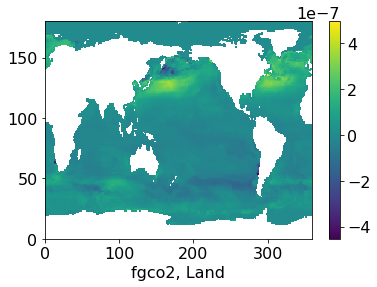

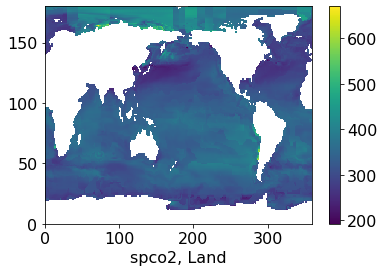

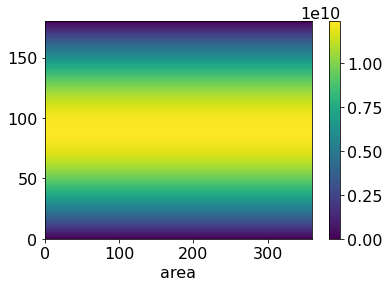

numpy.ndarray

In [7]:

# fig = plt.subplots(1, 1)
# c=plt.pcolor(land_fgco2_1x1_A[ind1,:,:])
# fig.colorbar()
# plt.show()


plt.figure()
#plt.subplot(2,2,3)
plt.pcolor(np.squeeze(land_fgco2_1x1_A[ind1,:,:]))#, vmin=-60, vmax=750)
plt.colorbar()
plt.xlabel('fgco2, Land')
plt.show()

plt.figure()
#plt.subplot(2,2,3)
plt.pcolor(np.squeeze(land_spco2_1x1_A[ind1,:,:]))#, vmin=-60, vmax=750)
plt.colorbar()
plt.xlabel('spco2, Land')
plt.show()


plt.figure()
#plt.subplot(2,2,3)
plt.pcolor(np.squeeze(areaT[ind1,:,:]))#, vmin=-60, vmax=750)
plt.colorbar()
plt.xlabel('area')
plt.show()

type(land_spco2_1x1_A)

(756, 180, 360)
(120, 180, 360)


<ipython-input-8-cf4832583559>:19: RuntimeWarning: Mean of empty slice
  roeden_fgco2_A_2009_2018 = np.nanmean(np.squeeze(roeden_fgco2_1x1_A[ind2009:ind2,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr
<ipython-input-8-cf4832583559>:20: RuntimeWarning: Mean of empty slice
  roeden_fgco2_B_2009_2018 = np.nanmean(np.squeeze(roeden_fgco2_1x1_B[ind2009:ind2,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr
<ipython-input-8-cf4832583559>:21: RuntimeWarning: Mean of empty slice
  roeden_fgco2_C_2009_2018 = np.nanmean(np.squeeze(roeden_fgco2_1x1_C[ind2009:ind2,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr
/work/ollie/jhauck/gcp2018/py_recom/GCB/code/2021/subsampling/integrate_CO2flux.py:27: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmap.set_bad('white',1.)

shape(reg_arcT) (756, 180, 360)
region global
shape(mask) (756, 180, 360)


/work/ollie/jhauck/gcp2018/py_recom/GCB/code/2021/subsampling/integrate_CO2flux.py:116: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(reg_lon,reg_lat,np.squeeze(mask[1,:,:]))#, vmin=-60, vmax=750)


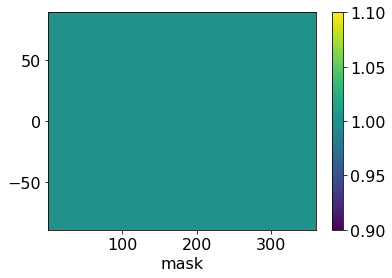

global
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
True
True
True
0 [0.2713146272590596 -0.3645493315981685 -0.30117222877111494
 -0.06335536129903148 -0.1900712202616999 -0.11008658059535936
 0.14639004437197856 0.35098006485116645 0.5451203323894235
 0.9423943725223741 0.9853305253121208 1.081323571323253]
1 [0.6893918247723272 0.25112062868144475 0.22565353955257492
 0.1870713200615856 0.15801336531648788 0.34726435841517794
 0.42952570901972253 0.4889068337579722 0.6206302821895816
 0.9828536471749745 1.358115980707726 1.3123431264771679]
2 [0.8977420776270408 0.34502526938167616 0.28959603624639213
 0.39011288072706235 0.32059263836518365 0.34996061475508
 0.4853282536927648 0.38567465855721406 0.6307794086571133
 0.8188299581416069 1.1380241934955757 1.2590420336442514]
3 [0.8474132600686101 0.39569732312979256 0.26285590439543327
 0.34906590273952365 0.26028342588314685 0.21433294773090336
 0.2718318366466418 0.3182135515577249 0.5116486724199284
 1.0330403977324283 1.1

shape(reg_arcT) (756, 180, 360)
region glo_noArc
shape(mask) (756, 180, 360)


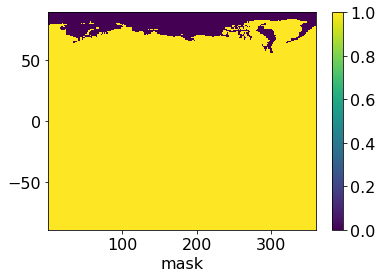

glo_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [0.21380234969447756 -0.41411101393072425 -0.34204316615838
 -0.09849108112821794 -0.2346730956059567 -0.17247993407240875
 0.06324623352567682 0.22886807765231462 0.4059871137617105
 0.842505092157273 0.9167473019268211 1.0280618995664053]
1 [0.6411293175390274 0.1968793561440527 0.17455408655746774
 0.14876551603409058 0.11356954767319373 0.2829628841030856
 0.3377519084166894 0.37011202440277396 0.47060352934331373
 0.8627835834181018 1.2667794360591724 1.2444874362718816]
2 [0.8435694511998538 0.2997000431748504 0.24724924352348396
 0.3489586821833233 0.27667168173387446 0.3023255542082413
 0.4350645405972648 0.30759491075276735 0.5339015682171306
 0.7175180389469691 1.0768336607736109 1.2059386670830643]
3 [0.8044165145992451 0.35879358268682915 0.23041053294957298
 0.31730148928196905 0.2266742179414308 0.16829671330761667
 0.21890258201091167 0.25271241409401796 0.4214201875241525
 0.95089228413458

shape(reg_arcT) (756, 180, 360)
region N_noArc
shape(mask) (756, 180, 360)


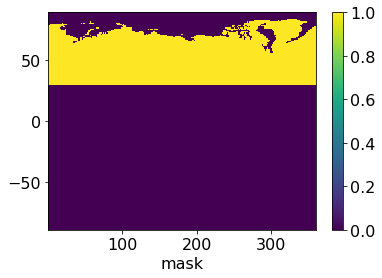

N_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [1.6858744690128644 1.6668396724217285 1.6168550605640446
 1.4439949732022288 0.8764921919667467 0.23356228778775914
 -0.2814539998569776 -0.567154404269259 -0.48351024707579743
 0.053747531678679406 0.7203269363021234 1.3796958979676264]
1 [1.7100636116991725 1.7939720381025115 1.8125381286319158
 1.4539173654309958 0.8646347804029065 0.29111586849163434
 -0.2582777223418802 -0.566540275757822 -0.49742391189809465
 0.10124758135737154 0.8776817054767573 1.4913178401416556]
2 [1.7316537580190405 1.8038196828967363 1.7710017928337067
 1.5110711674767388 0.9738964852670908 0.31444028586005873
 -0.2433149086054966 -0.5431386642982211 -0.45717550594690576
 -0.016823848319936986 0.7877863148856822 1.4454771172101035]
3 [1.7721537391838602 1.8669810213416567 1.7649752350118055
 1.477255375038821 0.9445142194075764 0.2730983898057573
 -0.27740493512306824 -0.5225845690988814 -0.412723076937896
 0.11520089586826765

shape(reg_arcT) (756, 180, 360)
region N
shape(mask) (756, 180, 360)


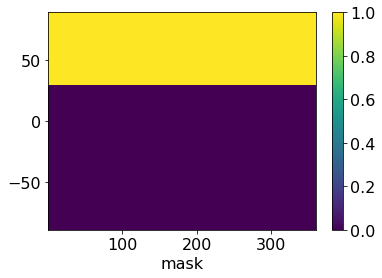

N
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [1.7433867465774464 1.716401354754285 1.65772599795131 1.4791306930314152
 0.9210940673110035 0.2959556412648085 -0.19831018901067593
 -0.4450424170704072 -0.3443770284480843 0.15363681204378052
 0.7889101596874235 1.4329575697244743]
1 [1.7583261189324726 1.8482133106399035 1.8636375816270225
 1.4922231694584909 0.9090785980462006 0.3554173428037266
 -0.16650392173884732 -0.4477454664026238 -0.3473971590518267
 0.22131764511424415 0.969018250125311 1.5591735303469416]
2 [1.7858263844462277 1.8491449091035619 1.8133485855566154
 1.5522253660204781 1.0178174418984 0.36207534640689754
 -0.19305119550999658 -0.4650589164937743 -0.3602976655069232
 0.08448807087470078 0.848976847607647 1.4985804837712908]
3 [1.8151504846532251 1.9038847617846204 1.797420606457666 1.509019788496376
 0.9781234273492923 0.319134624229044 -0.22447568048733824
 -0.4570834316351744 -0.32249459204211983 0.197349009466107
 0.8483382828201399

shape(reg_arcT) (756, 180, 360)
region Arc
shape(mask) (756, 180, 360)


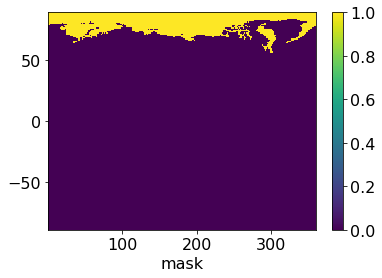

Arc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [0.057512277564582145 0.0495616823325564 0.04087093738726544
 0.03513571982918673 0.04460187534425684 0.06239335347704932
 0.08314381084630168 0.12211198719885195 0.13913321862771313
 0.09988928036510113 0.06858322338529996 0.053261671756847616]
1 [0.04826250723329993 0.054241272537392145 0.05109945299510767
 0.03830580402749522 0.04444381764329414 0.06430147431209224
 0.0917738006030329 0.11879480935519814 0.1500267528462679
 0.12007006375687265 0.09133654464855359 0.06785569020528605]
2 [0.054172626427186725 0.04532522620682522 0.04234679272290889
 0.04115419854373901 0.043920956631309266 0.04763506054683872
 0.0502637130955 0.07807974780444664 0.09687784043998256
 0.10131191919463778 0.06119053272196495 0.0531033665611875]
3 [0.0429967454693647 0.03690374044296338 0.03244537144586084
 0.03176441345755485 0.03360920794171614 0.046036234423286644
 0.05292925463572999 0.06550113746370695 0.09022848489577626
 0.

shape(reg_arcT) (756, 180, 360)
region T
shape(mask) (756, 180, 360)


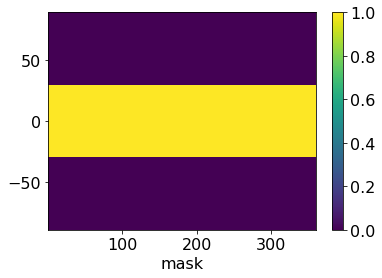

T
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-0.7458160956410296 -0.8973034692020059 -0.8142716409318363
 -0.8555401292822826 -1.0122763070438552 -0.9083479427023579
 -0.6093247479726341 -0.43702881357579043 -0.46205734453963615
 -0.5424255425240284 -0.6636036229633041 -0.6405550579631397]
1 [-0.7319612751882649 -0.7753573987388365 -0.8075784219081816
 -0.8770649430615218 -0.8741129216437322 -0.6825809013883871
 -0.5192971738684891 -0.4596750810796604 -0.5069416649513737
 -0.6424740801200552 -0.6836302579148064 -0.679767173331955]
2 [-0.6347179823691612 -0.7124271301954332 -0.685660946839344
 -0.7393435315112955 -0.8956933484823459 -0.76520849519101
 -0.5135254375711485 -0.4525878693960535 -0.4520762324131887
 -0.5944570687028049 -0.6992391591141452 -0.6284711720528615]
3 [-0.6719229693476806 -0.7820997313455152 -0.7655487357510798
 -0.7755403976978474 -0.8989082056303994 -0.8550414733047172
 -0.614876317000673 -0.5453432333856765 -0.5972480632595262
 -0.5

shape(reg_arcT) (756, 180, 360)
region S
shape(mask) (756, 180, 360)


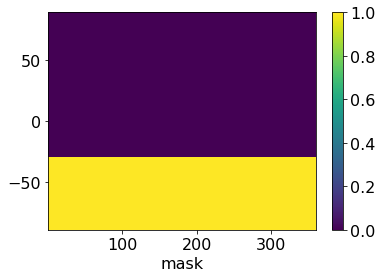

S
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-0.7262560236773571 -1.183647217150447 -1.1446265857905884
 -0.686945925048164 -0.09888898052884813 0.5023057208421899
 0.9540249813552887 1.2330512954973643 1.351554705377144
 1.3311831030026218 0.8600239885880017 0.28892105956191866]
1 [-0.33697301897188003 -0.8217352832196221 -0.8304056201662663
 -0.4280869063353834 0.12304768891401938 0.6744279169998384
 1.1153268046270588 1.3963273812402566 1.4749691061927819
 1.4040100821807853 1.0727279884972218 0.432936769462181]
2 [-0.25336632445002577 -0.7916925095264525 -0.8380916024708789
 -0.4227689537821201 0.19846854494912958 0.7530937635391926
 1.19190488677391 1.3033214444470418 1.443153306577225 1.328798955969711
 0.9882865050020739 0.3889327219258222]
3 [-0.29581425523693433 -0.7260877073093119 -0.7690159663111528
 -0.38441348805900466 0.18106820416425398 0.7502397968065768
 1.111183834134653 1.320640216578576 1.4313913277215746 1.4005158210901547
 0.980459659

shape(reg_arcT) (756, 180, 360)
region global
shape(mask) (756, 180, 360)


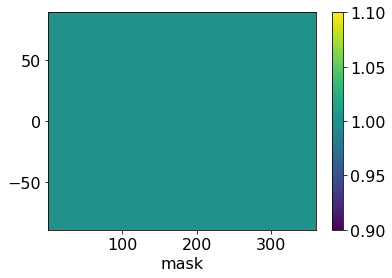

global
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
True
True
True
0 [0.3710433670614218 -0.2479889049898566 -0.22450511571135753
 -0.014231136971134917 -0.12978014122413567 -0.059264396579089156
 0.16237715404885725 0.3223702082610752 0.4974672308146985
 0.8971156419596854 0.9242086798855 1.0328746991652722]
1 [0.6862180004362944 0.28232114670960373 0.2450995202464689
 0.19439287451805223 0.17719357462609828 0.3693862800426064
 0.42781264572236233 0.4510949215159609 0.5650620935856984
 0.9290548346554812 1.2765289231350332 1.2406386343854072]
2 [0.8648888878730342 0.3499793305814939 0.28608277119753334
 0.3834389274093732 0.3355572340200535 0.36511359595370996
 0.4773753046164447 0.34692652003232743 0.5774026955170618
 0.7666078034136636 1.0584484430529575 1.1849465659782488]
3 [0.8295075822367531 0.4063456975412807 0.25834326099268107
 0.3307951009197588 0.2603168348267149 0.21987993244850154
 0.2583540062898105 0.26295916139264763 0.4517365846232084
 0.9692453193104652 1.101

shape(reg_arcT) (756, 180, 360)
region glo_noArc
shape(mask) (756, 180, 360)


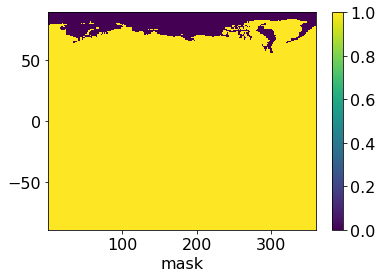

glo_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [0.3135535474973348 -0.2975333022460615 -0.2653637738233112
 -0.04935706097764562 -0.17436236037584818 -0.12159518392293926
 0.07934817361746054 0.20040190731364418 0.3584450153436732
 0.7973046744099676 0.8556666583110057 0.9796350150109755]
1 [0.6379690762378935 0.22809779409834255 0.19401678501192773
 0.15609927084807254 0.13277322805113614 0.30514734301051905
 0.3361718809122452 0.33246393256344325 0.4151560294854863
 0.8090570276311532 1.1852428743552839 1.1728121982354969]
2 [0.8107319883947033 0.3046675002490104 0.24374865027511305
 0.3422950920536713 0.29165391568918564 0.31753520173541766
 0.4272378259222049 0.2689873462962238 0.48059997175486724
 0.6653537081140444 0.9972926531756809 1.131863044581336]
3 [0.7865215371796554 0.3694502369672731 0.2259026250920652
 0.299034517101538 0.2267211493880637 0.173886768066697
 0.20549673363354953 0.19754629527330217 0.36159298882248897
 0.8871512576604463

shape(reg_arcT) (756, 180, 360)
region N_noArc
shape(mask) (756, 180, 360)


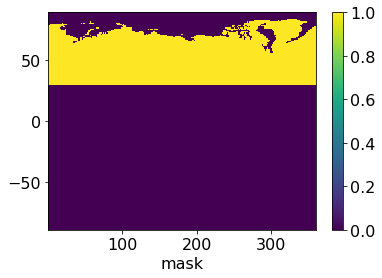

N_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [1.6858387237262302 1.6668742672545225 1.6168993634143323
 1.4440074993663954 0.8764823288913292 0.23353545886696164
 -0.2815141579898863 -0.5672162619736113 -0.4835544456331811
 0.053722088609307 0.7203223327709032 1.3797038523357776]
1 [1.7100979814611557 1.7940356229219223 1.8126067478169698
 1.4539370417831552 0.8646286772429869 0.29108260819331916
 -0.25834329150932817 -0.5665979143142114 -0.4974670880173883
 0.10121494624884818 0.8776605165825978 1.4913134836755775]
2 [1.7317009236947452 1.803894752200268 1.7710806593814394 1.511103601831664
 0.97390576252528 0.3144249323657952 -0.24336542322329272
 -0.5431839498492979 -0.45720267186691177 -0.016833984412271755
 0.7878006400210541 1.445495981947461]
3 [1.7722116272542252 1.8670553983259468 1.7650376749327144
 1.4772822650448425 0.9445132281927681 0.273071416358428
 -0.27747250928553147 -0.5226507702782109 -0.41276951549493235
 0.11518279430307328 0.76

shape(reg_arcT) (756, 180, 360)
region N
shape(mask) (756, 180, 360)


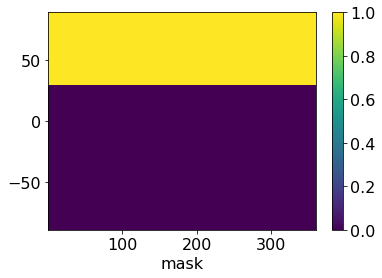

N
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [1.7433285432903174 1.7164186645107273 1.657758021526286 1.479133423372906
 0.9210645480430416 0.29586624621081165 -0.1984851775584897
 -0.4452479610261804 -0.34453223016215573 0.1535330561590249
 0.7888643543453975 1.4329435364900744]
1 [1.7583469056595566 1.8482589755331835 1.863689483051511
 1.4922306454531349 0.9090490238179487 0.35532154522540654
 -0.1667025266992111 -0.4479669253616936 -0.3475610239171762
 0.22121275327317644 0.9689465653623471 1.5591399198254876]
2 [1.7858578231730762 1.849206582532751 1.81341478030386 1.5522474371873658
 1.0178090808561477 0.36200332658408757 -0.19322794452905262
 -0.46524477611319415 -0.3603999481047174 0.08442011088734758
 0.8489564298983306 1.4985795033443736]
3 [1.8151976723113228 1.9039508588999545 1.797478310833331
 1.5090428488630632 0.9781089136314195 0.31906458074023253
 -0.2246152366292705 -0.4572379041588654 -0.32262591969421284
 0.19727685595309216 0.848294153

shape(reg_arcT) (756, 180, 360)
region Arc
shape(mask) (756, 180, 360)


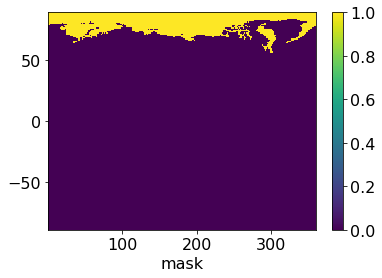

Arc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [0.05748981956408721 0.04954439725620505 0.04085865811195383
 0.03512592400651084 0.044582219151712496 0.062330787343850044
 0.08302898043139659 0.12196830094743083 0.13902221547102542
 0.09981096754971791 0.06854202157449421 0.05323968415429685]
1 [0.04824892419840102 0.05422335261126162 0.05108273523454098
 0.03829360366997985 0.044420346574961994 0.0642389370320874
 0.09164076481011707 0.11863098895251774 0.14990606410021204
 0.11999780702432823 0.09128604877974934 0.0678264361499103]
2 [0.054156899478331015 0.045311830332483066 0.04233412092242069
 0.04114383535570176 0.04390331833086795 0.047578394218292366
 0.050137478694240095 0.07793917373610369 0.09680272376219445
 0.10125409529961932 0.061155789877276476 0.05308352139691263]
3 [0.042986045057097834 0.036895460574007805 0.03244063590061638
 0.03176058381822058 0.03359568543865141 0.045993164381804535
 0.05285727265626096 0.06541286611934542 0.090143595

shape(reg_arcT) (756, 180, 360)
region T
shape(mask) (756, 180, 360)


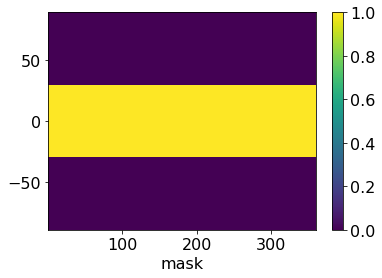

T
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-0.729324983515708 -0.8784695029806492 -0.8008100849329715
 -0.8464892109535627 -1.0002400473212154 -0.8959378926197626
 -0.600703243412942 -0.4306218365634917 -0.4534092279184516
 -0.5324038574986283 -0.6569425383099633 -0.6341895883842619]
1 [-0.7230176349428963 -0.7664463580586955 -0.8015248366359189
 -0.8725768020506269 -0.8665871395412773 -0.67297958635423
 -0.5125851251960665 -0.4549791624457166 -0.5004868233792061
 -0.6355301486715419 -0.6786715904612359 -0.6778562428964822]
2 [-0.6309025460411515 -0.702832114703677 -0.6791056227470995
 -0.736662156356995 -0.8893263586259077 -0.7561331051155479
 -0.5074723928437381 -0.44837811373750586 -0.4454050668422252
 -0.586912249159987 -0.6958755292464239 -0.6284686833179173]
3 [-0.6693591286123718 -0.777360574565724 -0.762598816762796
 -0.7739443748533601 -0.8945955773184711 -0.8489507928003391
 -0.6112172258322984 -0.54355073213037 -0.5934366697357505
 -0.55951831

shape(reg_arcT) (756, 180, 360)
region S
shape(mask) (756, 180, 360)


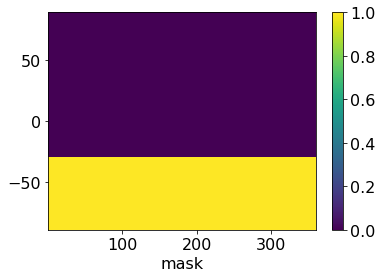

S
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-0.6429601927131872 -1.085938066519935 -1.081453052304672
 -0.6468753493904783 -0.050604641945962016 0.5408072498298618
 0.961565575020289 1.198240005850747 1.295408688895306 1.275986443299289
 0.7922868638500659 0.23412075105945987]
1 [-0.3491112702803661 -0.7994914707648841 -0.8170651261691233
 -0.4252609688844557 0.13473169034942656 0.6870443211714301
 1.1071002976176396 1.354041009323371 1.4131099408820804
 1.3433722300538466 0.9862539482339219 0.3593549574564016]
2 [-0.29006638925889044 -0.7963951372475804 -0.848226386359227
 -0.4321463534209978 0.20707451178981356 0.7592433744851702
 1.1780756419892355 1.2605494098830277 1.3832077104640041
 1.2690999416863031 0.9053675424010509 0.3148357459517922]
3 [-0.31633096146219786 -0.7202445867929499 -0.7765362330778537
 -0.4043033730899446 0.17680349851376653 0.7497661445086081
 1.0941864687513794 1.2637477976818832 1.3677991740531719
 1.3314867740490701 0.90229935

shape(reg_arcT) (756, 180, 360)
region global
shape(mask) (756, 180, 360)


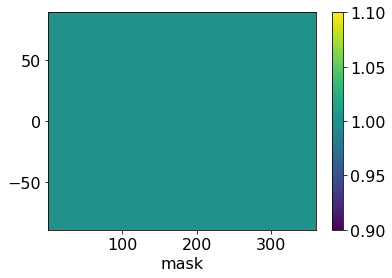

global
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
True
True
True
0 [1.1452404133800227 0.652797099512888 0.6483978339757978
 0.8664792641428157 0.7973833404116358 0.8610355360642418
 0.9935351543088806 0.93220942831347 0.8462482619813182 1.212045820854659
 1.3364477257400087 1.4752943080798542]
1 [1.1745392489007869 0.9650247990769896 1.0103500855055987
 0.9990350611348137 1.0199684008651237 1.2291861468370173
 1.2235974716483122 1.1252401430271282 1.081105779561081 1.408782562272289
 1.8311267104466313 1.7814428663286292]
2 [1.4029008234758915 1.0248136094464175 0.9499573941773193
 1.148964155473101 1.2378350530525963 1.2963963619384018
 1.3582738442527047 1.0453720545705216 1.1383077874977507
 1.2869320737131635 1.637605439026459 1.712597903252383]
3 [1.302014244560749 0.9926335368352065 0.8856524038867133
 0.9515686898683586 0.9605409596034866 1.0672010451894856
 1.1157529089134273 0.976496504395996 0.981249485515518 1.37835595919646
 1.5799392638230059 1.633927735392499]


shape(reg_arcT) (756, 180, 360)
region glo_noArc
shape(mask) (756, 180, 360)


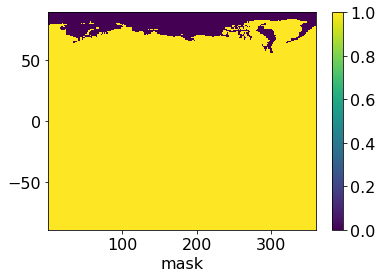

glo_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [1.0779507165895241 0.5951067532335365 0.601698763893618
 0.8300563466165868 0.7563736624744581 0.8159556143735888
 0.9320593198047383 0.8486154891127227 0.7445320413513744
 1.1128779578676835 1.2603381878220383 1.4152438473919298]
1 [1.118032124797994 0.9006357795845186 0.953507860673318 0.9613712888459829
 0.9825913770092752 1.1750731126438105 1.1319860937528965
 0.9906502646249303 0.9023945068662048 1.2598032454876384
 1.727769480743713 1.7077615857898054]
2 [1.3409217304710728 0.9682433634459909 0.8990691262362365
 1.1039665303528192 1.1967150891346579 1.2549596490918458
 1.2888609251284255 0.931799983365001 0.9934831403591966
 1.1483445851247436 1.5568144922399798 1.6492416460613315]
3 [1.2515454280811318 0.949192809934179 0.8511812184487096
 0.9228913922379492 0.9302287558481629 1.0223130063015526
 1.0487654488248621 0.8651457509410075 0.8323246292665639
 1.2576161498215408 1.4785630568790233 1.5594

shape(reg_arcT) (756, 180, 360)
region N_noArc
shape(mask) (756, 180, 360)


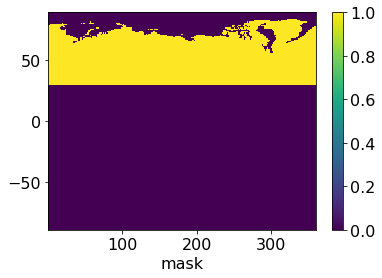

N_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [1.9208921799213987 1.8784883996906712 1.7938109770648198
 1.5839805380724459 1.0124642339211916 0.38101407215308014
 -0.13488533967387728 -0.4329294824044045 -0.3450529752530712
 0.20279607792751683 0.8673383790887618 1.5145153377364688]
1 [1.8414732621757497 1.9544759558774467 1.981209267904423
 1.6076726213893766 1.025112711771045 0.47823422112391967
 -0.08703769061985996 -0.39284784870905404 -0.30300791557472206
 0.3041872608915756 1.0633882095089304 1.6028196688061136]
2 [1.783804713776825 1.8623783810089924 1.8105047633669928
 1.5767411346619755 1.1005021914197128 0.48485120015242944
 -0.0841374881389488 -0.40878796543934387 -0.3000244316648393
 0.16095647174585132 0.9725424734233735 1.599315171791468]
3 [1.8957601327746159 2.005504549749996 1.905104486454675 1.5948820940098198
 1.059850983717372 0.399378048054373 -0.16012196174967247
 -0.413113485973038 -0.2952191168922132 0.22350054111109535
 0.9065

shape(reg_arcT) (756, 180, 360)
region N
shape(mask) (756, 180, 360)


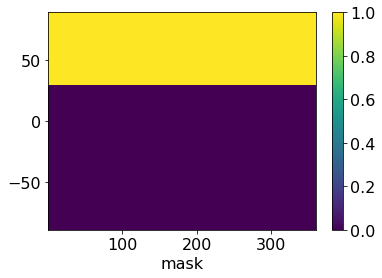

N
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [1.9881818767118973 1.9361787459700224 1.8405100471469997
 1.6204034555986748 1.0534739118583694 0.4260939938437329
 -0.07340950516973509 -0.3493355432036573 -0.24333675462312726
 0.3019639409144924 0.9434479170067319 1.5745657984243933]
1 [1.8979803862785418 2.0188649753699175 2.0380514927367037
 1.645336393678207 1.0624897356268934 0.5323472553171263
 0.004573687275555825 -0.25825797030685604 -0.12429664287984597
 0.4531665776762262 1.166745439211849 1.676500949344937]
2 [1.845783806781644 1.9189486270094198 1.8613930313080753
 1.6217387597822572 1.1416221553376518 0.5262879129989856
 -0.01472456901466935 -0.2952158942338232 -0.15519978452628497
 0.29954396033427116 1.0533334202098528 1.6626714289825193]
3 [1.9462289492542326 2.048945276651023 1.9395756718926787
 1.6235593916402287 1.0901631874726958 0.4442660869423058
 -0.0931345016611076 -0.30176273251804964 -0.14629426064325907
 0.3442403504860146 1.00796966

shape(reg_arcT) (756, 180, 360)
region Arc
shape(mask) (756, 180, 360)


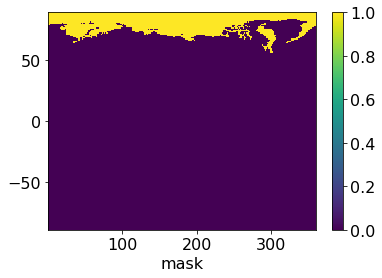

Arc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [0.06728969679049808 0.05769034627935126 0.04669907008217982
 0.03642291752622914 0.041009677937177705 0.045079921690652815
 0.061475834504142166 0.08359393920074723 0.10171622062994391
 0.09916786298697558 0.07610953791797032 0.06005046068792447]
1 [0.056507124102792565 0.06438901949247033 0.056842224832280686
 0.037663772288830576 0.03737702385584834 0.054113034193206656
 0.09161137789541575 0.13458987840219797 0.1787112726948761
 0.14897931678465062 0.10335722970291832 0.07368128053882413]
2 [0.06197909300481873 0.0565702460004267 0.05088826794108274
 0.04499762512028187 0.041119963917938596 0.041436712846556034
 0.06941291912427945 0.1135720712055207 0.14482464713855434
 0.13858748858841988 0.08079094678647926 0.06335625719105115]
3 [0.05046881647961718 0.043440726901027814 0.03447118543800361
 0.028677297630409368 0.030312203755323862 0.04488803888793285
 0.06698746008856489 0.1113507534549883 0.1489248562

shape(reg_arcT) (756, 180, 360)
region T
shape(mask) (756, 180, 360)


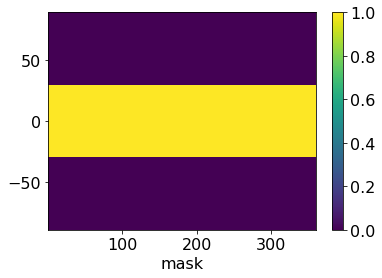

T
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-0.7008334166803948 -0.8151220557695399 -0.7924372885034626
 -0.8274977375053688 -0.9093292661906845 -0.7543658801657671
 -0.44819782171972194 -0.31599709611014704 -0.4044764201485414
 -0.5090151505506945 -0.6180033467780036 -0.5961041830544332]
1 [-0.6171728517160275 -0.5954554753954026 -0.639233778636547
 -0.6821288850461474 -0.6154385982513605 -0.40140711781304805
 -0.23794074712568844 -0.1917653782903739 -0.28715563949869977
 -0.4601403760936157 -0.497989194266854 -0.5014522114202167]
2 [-0.4355816265339428 -0.46674043095569434 -0.49763520264166067
 -0.5462732367391306 -0.6102273879616688 -0.4229873529246105
 -0.17386839241031787 -0.1474051869292969 -0.20884503250471348
 -0.39335920544641034 -0.5221003892499182 -0.4841202188011423]
3 [-0.5047686376222027 -0.5841622529249987 -0.6243585687098129
 -0.6253150229273713 -0.6519664249601395 -0.5278535796107511
 -0.2781844167375531 -0.2521362440184943 -0.38408087228

shape(reg_arcT) (756, 180, 360)
region S
shape(mask) (756, 180, 360)


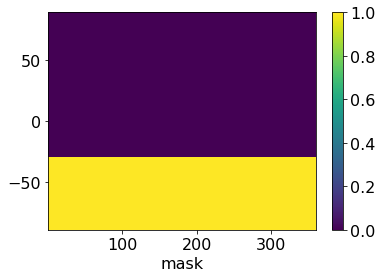

S
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-0.14210804665147955 -0.46825959068759476 -0.399674924667739
 0.07357354604950947 0.6532386947439514 1.1893074223862758
 1.5151424811983376 1.597542067627275 1.4940614367529872
 1.4190970304908612 1.0110031555112802 0.4968326927098942]
1 [-0.10626828566172775 -0.4583847008975256 -0.38846762859455825
 0.03582755250275413 0.5729172634895907 1.0982460093329391
 1.4569645314984447 1.575263491624358 1.4925580619396268
 1.4157563606896781 1.1623704655016367 0.6063941284039086]
2 [-0.007301356771809399 -0.4273945866073075 -0.4138004344890958
 0.07349863242997465 0.7064402856766138 1.193095801864027
 1.546866805677692 1.487993135733642 1.5023526045287487 1.3807473188253025
 1.1063724080665245 0.5340466930710057]
3 [-0.13944606707128132 -0.4721494868908179 -0.4295646992961526
 -0.04667567884449893 0.5223441970909306 1.1507885378579303
 1.4870718273120878 1.5303954809325397 1.5116246184461901
 1.4523005255106096 1.0923249

[0.27446823 0.58757422 0.60922567 0.5681098  0.53415608 0.48820786
 0.65095645 0.52618142 0.62283183 0.65616591 0.61950625 0.69947993
 0.92962604 0.67623072 0.63332775 0.84080179 0.78648652 0.72474979
 0.72575628 0.9041403  1.13390833 1.17338444 1.444113   1.48083082
 1.4474376  1.62760207 1.70704857 1.5942444  1.6366498  1.79021266
 1.96985025 1.8103671  1.75941695 1.84533189 2.06680855 2.06462237
 2.06217214 2.05839875 2.0674087  1.9551581  2.3503666  2.15812471
 1.9726948  1.81076496 2.16911976 2.36007854 2.21971794 2.39265275
 2.52419151 2.61354986 2.30721087 2.34276954 2.54853133 2.54339213
 2.55381707 2.62577049 2.71305117 2.7222085  3.13814533 2.93187538
 2.90598642 2.91811599 2.89487135]
(756, 180, 360)
(120, 180, 360)


<ipython-input-8-cf4832583559>:100: RuntimeWarning: Mean of empty slice
  roeden_spco2_A_2009_2018 = np.nanmean(np.squeeze(roeden_spco2_1x1_A[ind_2009_2018_monthly,:,:]),axis=0)
<ipython-input-8-cf4832583559>:101: RuntimeWarning: Mean of empty slice
  roeden_spco2_B_2009_2018 = np.nanmean(np.squeeze(roeden_spco2_1x1_B[ind_2009_2018_monthly,:,:]),axis=0)
<ipython-input-8-cf4832583559>:102: RuntimeWarning: Mean of empty slice
  roeden_spco2_C_2009_2018 = np.nanmean(np.squeeze(roeden_spco2_1x1_C[ind_2009_2018_monthly,:,:]),axis=0)


In [8]:
# now with Schmidt number
#-----------------
## here with FESOM prior
#-----------------

# # for Rödenbeck, units given as PgC/yr  for timeseries, mol/m2/yr for gridded fields (as converted in load_roeden...

# gridded fields
roeden_fgco2_1x1_A = np.load('roedenSc_FESOMprior_fgco2_1x1_A_subsampling.npy')
roeden_fgco2_1x1_B = np.load('roedenSc_FESOMprior_fgco2_1x1_B_subsampling.npy')
roeden_fgco2_1x1_C = np.load('roedenSc_FESOMprior_fgco2_1x1_C_subsampling.npy')

print(np.shape(roeden_fgco2_1x1_A))

# calculate mean over 2009-2018, double-check time-entries!!!

print(np.shape(roeden_fgco2_1x1_A[ind2009:ind2,:,:])) # should be 120 time entries

roeden_fgco2_A_2009_2018 = np.nanmean(np.squeeze(roeden_fgco2_1x1_A[ind2009:ind2,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr
roeden_fgco2_B_2009_2018 = np.nanmean(np.squeeze(roeden_fgco2_1x1_B[ind2009:ind2,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr
roeden_fgco2_C_2009_2018 = np.nanmean(np.squeeze(roeden_fgco2_1x1_C[ind2009:ind2,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr


# integrated time-series:
#----------------------------------------------------------------------------------------------------------
# need to calculate this from 1x1 regridded field now to be able to apply Arctic mask on 1x1 degree grid


roeden_fgco2_PgCyr_A_glo= integrate_CO2flux(roeden_fgco2_1x1_A,'global',areaT,xax,yax)
roeden_fgco2_PgCyr_A_glo_noArc= integrate_CO2flux(roeden_fgco2_1x1_A,'glo_noArc',areaT,xax,yax)
roeden_fgco2_PgCyr_A_N_noArc= integrate_CO2flux(roeden_fgco2_1x1_A,'N_noArc',areaT,xax,yax)
roeden_fgco2_PgCyr_A_N= integrate_CO2flux(roeden_fgco2_1x1_A,'N',areaT,xax,yax)
#roeden_fgco2_PgCyr_A_N60= integrate_CO2flux(roeden_fgco2_1x1_A,'N60',areaT,xax,yax)
roeden_fgco2_PgCyr_A_Arc= integrate_CO2flux(roeden_fgco2_1x1_A,'Arc',areaT,xax,yax)
roeden_fgco2_PgCyr_A_T= integrate_CO2flux(roeden_fgco2_1x1_A,'T',areaT,xax,yax)
roeden_fgco2_PgCyr_A_S= integrate_CO2flux(roeden_fgco2_1x1_A,'S',areaT,xax,yax)


roeden_fgco2_PgCyr_B_glo= integrate_CO2flux(roeden_fgco2_1x1_B,'global',areaT,xax,yax)
roeden_fgco2_PgCyr_B_glo_noArc= integrate_CO2flux(roeden_fgco2_1x1_B,'glo_noArc',areaT,xax,yax)
roeden_fgco2_PgCyr_B_N_noArc= integrate_CO2flux(roeden_fgco2_1x1_B,'N_noArc',areaT,xax,yax)
roeden_fgco2_PgCyr_B_N= integrate_CO2flux(roeden_fgco2_1x1_B,'N',areaT,xax,yax)
#roeden_fgco2_PgCyr_A_N60= integrate_CO2flux(roeden_fgco2_1x1_A,'N60',areaT,xax,yax)
roeden_fgco2_PgCyr_B_Arc= integrate_CO2flux(roeden_fgco2_1x1_B,'Arc',areaT,xax,yax)
roeden_fgco2_PgCyr_B_T= integrate_CO2flux(roeden_fgco2_1x1_B,'T',areaT,xax,yax)
roeden_fgco2_PgCyr_B_S= integrate_CO2flux(roeden_fgco2_1x1_B,'S',areaT,xax,yax)

roeden_fgco2_PgCyr_C_glo= integrate_CO2flux(roeden_fgco2_1x1_C,'global',areaT,xax,yax)
roeden_fgco2_PgCyr_C_glo_noArc= integrate_CO2flux(roeden_fgco2_1x1_C,'glo_noArc',areaT,xax,yax)
roeden_fgco2_PgCyr_C_N_noArc= integrate_CO2flux(roeden_fgco2_1x1_C,'N_noArc',areaT,xax,yax)
roeden_fgco2_PgCyr_C_N= integrate_CO2flux(roeden_fgco2_1x1_C,'N',areaT,xax,yax)
#roeden_fgco2_PgCyr_A_N60= integrate_CO2flux(roeden_fgco2_1x1_A,'N60',areaT,xax,yax)
roeden_fgco2_PgCyr_C_Arc= integrate_CO2flux(roeden_fgco2_1x1_C,'Arc',areaT,xax,yax)
roeden_fgco2_PgCyr_C_T= integrate_CO2flux(roeden_fgco2_1x1_C,'T',areaT,xax,yax)
roeden_fgco2_PgCyr_C_S= integrate_CO2flux(roeden_fgco2_1x1_C,'S',areaT,xax,yax)
#----------------------------------------------------------------------------------------------------------

# keep this just for the comparison further down:
roeden_fgco2_PgCyr_A_glo_old= np.hstack([np.load('roedenSc_FESOMprior_fgco2_PgCyr_A_glo.npy')[:-1],np.nan])
roeden_fgco2_PgCyr_A_N_old= np.hstack([np.load('roedenSc_FESOMprior_fgco2_PgCyr_A_N.npy')[:-1],np.nan])
roeden_fgco2_PgCyr_A_Arc_old= np.hstack([np.load('roedenSc_FESOMprior_fgco2_PgCyr_A_Arc.npy')[:-1],np.nan])
roeden_fgco2_PgCyr_A_N60_old= np.hstack([np.load('roedenSc_FESOMprior_fgco2_PgCyr_A_N60.npy')[:-1],np.nan])
roeden_fgco2_PgCyr_A_T_old= np.hstack([np.load('roedenSc_FESOMprior_fgco2_PgCyr_A_T.npy')[:-1],np.nan])
roeden_fgco2_PgCyr_A_S_old= np.hstack([np.load('roedenSc_FESOMprior_fgco2_PgCyr_A_S.npy')[:-1],np.nan])

print(roeden_fgco2_PgCyr_A_glo)

# roeden_fgco2_PgCyr_B_glo= np.hstack([np.load('roeden_fgco2_PgCyr_B_glo.npy')[:-1],np.nan])
# roeden_fgco2_PgCyr_B_N= np.hstack([np.load('roeden_fgco2_PgCyr_B_N.npy')[:-1],np.nan])
# roeden_fgco2_PgCyr_B_Arc= np.hstack([np.load('roeden_fgco2_PgCyr_B_Arc.npy')[:-1],np.nan])
# roeden_fgco2_PgCyr_B_N60= np.hstack([np.load('roeden_fgco2_PgCyr_B_N60.npy')[:-1],np.nan])
# roeden_fgco2_PgCyr_B_T= np.hstack([np.load('roeden_fgco2_PgCyr_B_T.npy')[:-1],np.nan])
# roeden_fgco2_PgCyr_B_S= np.hstack([np.load('roeden_fgco2_PgCyr_B_S.npy')[:-1],np.nan])

# print(roeden_fgco2_PgCyr_B_glo)

# roeden_fgco2_PgCyr_C_glo= np.hstack([np.load('roeden_fgco2_PgCyr_C_glo.npy')[:-1],np.nan])
# roeden_fgco2_PgCyr_C_N= np.hstack([np.load('roeden_fgco2_PgCyr_C_N.npy')[:-1],np.nan])
# roeden_fgco2_PgCyr_C_Arc= np.hstack([np.load('roeden_fgco2_PgCyr_C_Arc.npy')[:-1],np.nan])
# roeden_fgco2_PgCyr_C_N60= np.hstack([np.load('roeden_fgco2_PgCyr_C_N60.npy')[:-1],np.nan])
# roeden_fgco2_PgCyr_C_T= np.hstack([np.load('roeden_fgco2_PgCyr_C_T.npy')[:-1],np.nan])
# roeden_fgco2_PgCyr_C_S= np.hstack([np.load('roeden_fgco2_PgCyr_C_S.npy')[:-1],np.nan])

# print(roeden_fgco2_PgCyr_C_glo)



#-------------------------------------
# spco2:
# gridded fields
roeden_spco2_1x1_A = np.load('roedenSc_FESOMprior_spco2_1x1_A_subsampling.npy')
roeden_spco2_1x1_B = np.load('roedenSc_FESOMprior_spco2_1x1_B_subsampling.npy')
roeden_spco2_1x1_C = np.load('roedenSc_FESOMprior_spco2_1x1_C_subsampling.npy')

print(np.shape(roeden_spco2_1x1_A))

# calculate mean over 2009-2018, double-check time-entries!!!

print(np.shape(np.squeeze(roeden_spco2_1x1_A[ind_2009_2018_monthly,:,:]))) # should be 120 time entries
roeden_spco2_A_2009_2018 = np.nanmean(np.squeeze(roeden_spco2_1x1_A[ind_2009_2018_monthly,:,:]),axis=0)
roeden_spco2_B_2009_2018 = np.nanmean(np.squeeze(roeden_spco2_1x1_B[ind_2009_2018_monthly,:,:]),axis=0)
roeden_spco2_C_2009_2018 = np.nanmean(np.squeeze(roeden_spco2_1x1_C[ind_2009_2018_monthly,:,:]),axis=0)


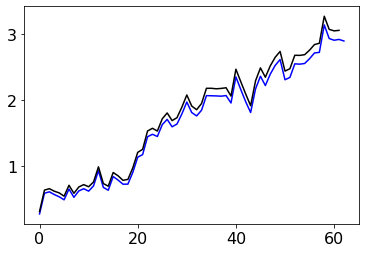

glo, mean diff between native mesh and interpolated integration:  0.09572865240183667


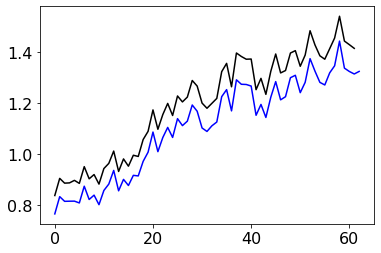

N, mean diff between native mesh and interpolated integration:  0.09206624157771279


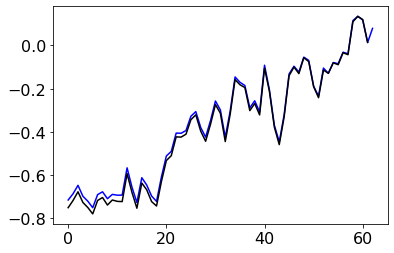

T, mean diff between native mesh and interpolated integration:  -0.015669628381245262


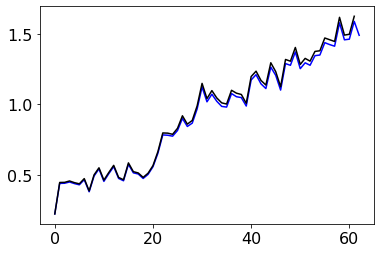

S, mean diff between native mesh and interpolated integration:  0.019332039205369127


In [9]:
# compare Rö CO2 flux: integrated on native mesh (old) and from 1x1 degree field

plt.figure()
plt.plot(roeden_fgco2_PgCyr_A_glo,'b')
plt.plot(roeden_fgco2_PgCyr_A_glo_old,'k')
plt.show()
print('glo, mean diff between native mesh and interpolated integration: ',np.nanmean(roeden_fgco2_PgCyr_A_glo_old-roeden_fgco2_PgCyr_A_glo))


plt.figure()
plt.plot(roeden_fgco2_PgCyr_A_N,'b')
plt.plot(roeden_fgco2_PgCyr_A_N_old,'k')
plt.show()
print('N, mean diff between native mesh and interpolated integration: ',np.nanmean(roeden_fgco2_PgCyr_A_N_old-roeden_fgco2_PgCyr_A_N))

plt.figure()
plt.plot(roeden_fgco2_PgCyr_A_T,'b')
plt.plot(roeden_fgco2_PgCyr_A_T_old,'k')
plt.show()
print('T, mean diff between native mesh and interpolated integration: ',np.nanmean(roeden_fgco2_PgCyr_A_T_old-roeden_fgco2_PgCyr_A_T))


plt.figure()
plt.plot(roeden_fgco2_PgCyr_A_S,'b')
plt.plot(roeden_fgco2_PgCyr_A_S_old,'k')
plt.show()
print('S, mean diff between native mesh and interpolated integration: ',np.nanmean(roeden_fgco2_PgCyr_A_S_old-roeden_fgco2_PgCyr_A_S))


(120, 180, 360)


<ipython-input-10-f2f0067a9a8a>:8: RuntimeWarning: Mean of empty slice
  land_fgco2_A_2009_2018 = np.nanmean(np.squeeze(land_fgco2_1x1_A[ind_2009_2018_monthly,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr
<ipython-input-10-f2f0067a9a8a>:9: RuntimeWarning: Mean of empty slice
  land_fgco2_B_2009_2018 = np.nanmean(np.squeeze(land_fgco2_1x1_B[ind_2009_2018_monthly,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr
<ipython-input-10-f2f0067a9a8a>:10: RuntimeWarning: Mean of empty slice
  land_fgco2_C_2009_2018 = np.nanmean(np.squeeze(land_fgco2_1x1_C[ind_2009_2018_monthly,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr
<ipython-input-10-f2f0067a9a8a>:12: RuntimeWarning: Mean of empty slice
  land_spco2_A_2009_2018 = np.nanmean(np.squeeze(land_spco2_1x1_A[ind_2009_2018_monthly,:,:]),axis=0)
<ipython-input-10-f2f0067a9a8a>:13: RuntimeWarning: Mean of empty slice
  land_spco2_B_2009_2018 = np.nanmean(np.squeeze(land_spco2_1x1_B[ind_2009_2018_monthly,:,:]),axis=0)
<ipython-input-10-f2f0067a9a8a>:1

shape(reg_arcT) (756, 180, 360)
region global
shape(mask) (756, 180, 360)


/work/ollie/jhauck/gcp2018/py_recom/GCB/code/2021/subsampling/integrate_CO2flux.py:116: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(reg_lon,reg_lat,np.squeeze(mask[1,:,:]))#, vmin=-60, vmax=750)


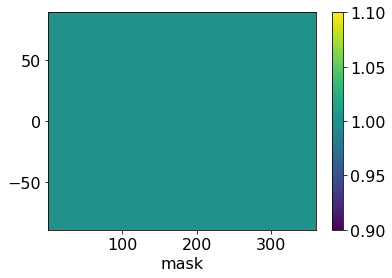

global
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
True
True
True
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region glo_noArc
shape(mask) (756, 180, 360)


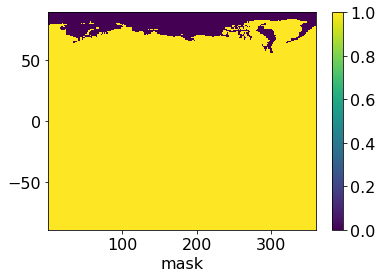

glo_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- 

shape(reg_arcT) (756, 180, 360)
region N
shape(mask) (756, 180, 360)


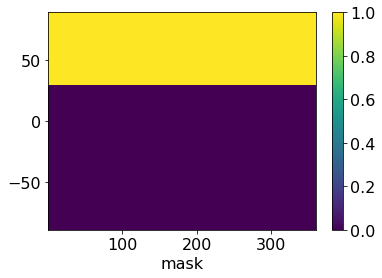

N
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region N_noArc
shape(mask) (756, 180, 360)


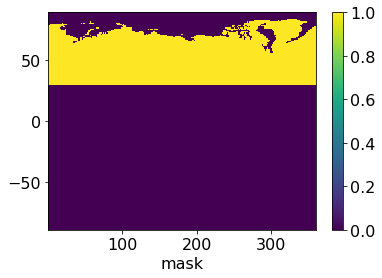

N_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region Arc
shape(mask) (756, 180, 360)


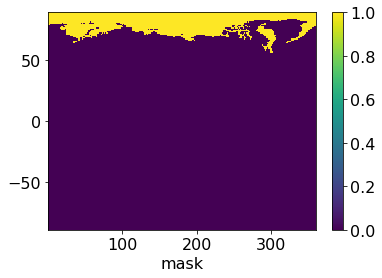

Arc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- 

shape(reg_arcT) (756, 180, 360)
region T
shape(mask) (756, 180, 360)


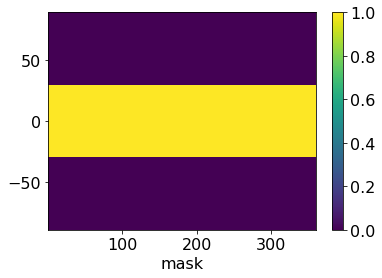

T
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region S
shape(mask) (756, 180, 360)


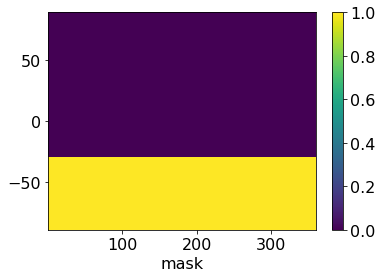

S
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region global
shape(mask) (756, 180, 360)


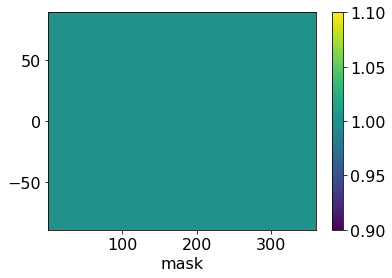

global
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
True
True
True
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region glo_noArc
shape(mask) (756, 180, 360)


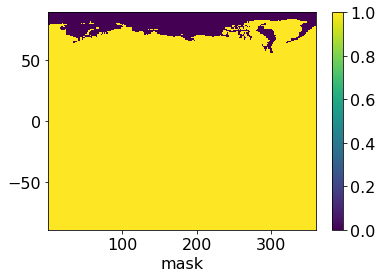

glo_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- 

shape(reg_arcT) (756, 180, 360)
region N
shape(mask) (756, 180, 360)


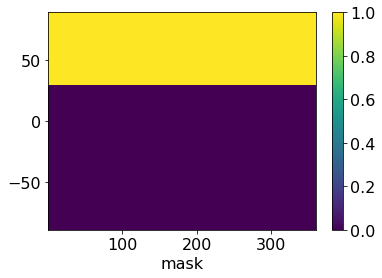

N
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region N_noArc
shape(mask) (756, 180, 360)


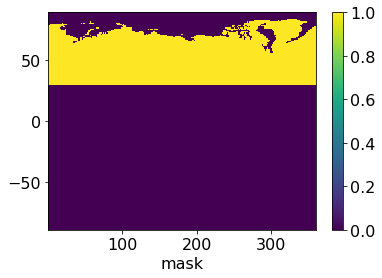

N_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region Arc
shape(mask) (756, 180, 360)


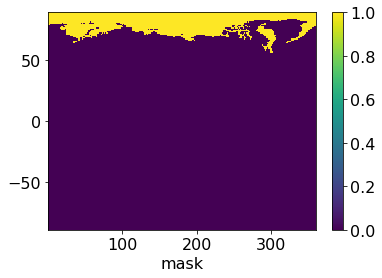

Arc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- 

shape(reg_arcT) (756, 180, 360)
region T
shape(mask) (756, 180, 360)


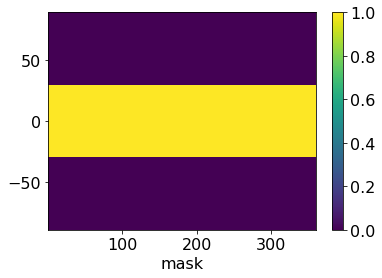

T
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region S
shape(mask) (756, 180, 360)


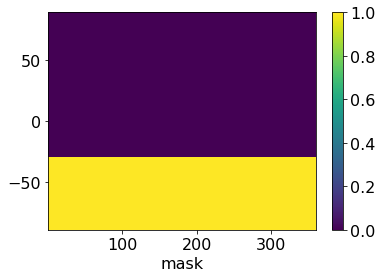

S
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region global
shape(mask) (756, 180, 360)


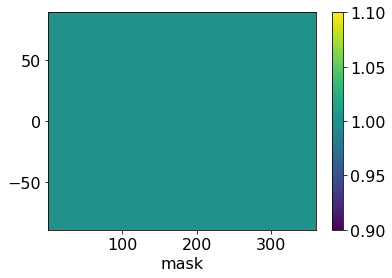

global
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
True
True
True
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region glo_noArc
shape(mask) (756, 180, 360)


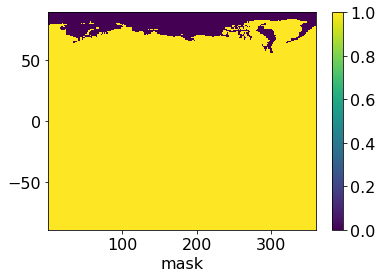

glo_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- 

shape(reg_arcT) (756, 180, 360)
region N
shape(mask) (756, 180, 360)


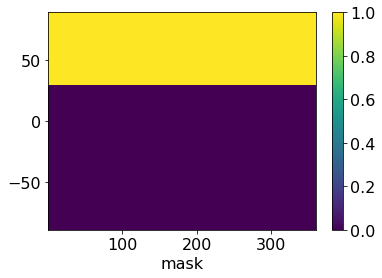

N
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region N_noArc
shape(mask) (756, 180, 360)


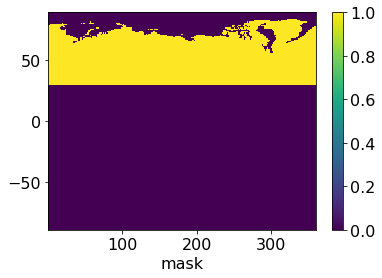

N_noArc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region Arc
shape(mask) (756, 180, 360)


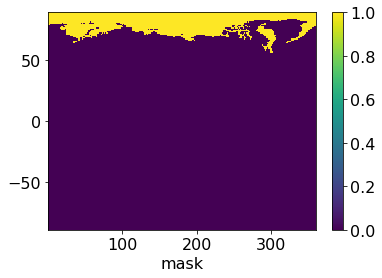

Arc
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- 

shape(reg_arcT) (756, 180, 360)
region T
shape(mask) (756, 180, 360)


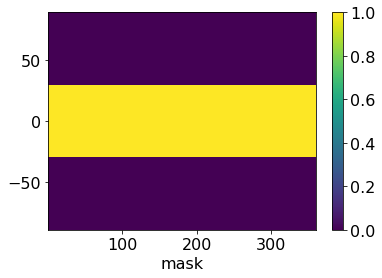

T
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (756, 180, 360)
region S
shape(mask) (756, 180, 360)


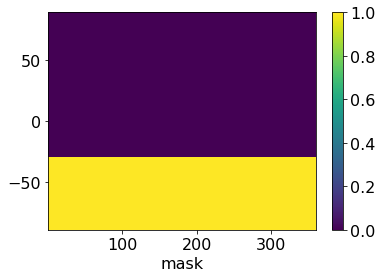

S
(756, 180, 360)
(756, 180, 360)
(756, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

In [10]:
# calculate/integrate fluxes, and calculate annual mean. convert units where necessary:

# mean map for the last ten years:
# check whether empty entries at the end??
# ind2 = end 2018

print(np.shape(land_fgco2_1x1_A[ind2009:ind2,:,:])) # 120 time entries
land_fgco2_A_2009_2018 = np.nanmean(np.squeeze(land_fgco2_1x1_A[ind_2009_2018_monthly,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr
land_fgco2_B_2009_2018 = np.nanmean(np.squeeze(land_fgco2_1x1_B[ind_2009_2018_monthly,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr
land_fgco2_C_2009_2018 = np.nanmean(np.squeeze(land_fgco2_1x1_C[ind_2009_2018_monthly,:,:]),axis=0)*365.25*86400 # back to mol/m2/yr

land_spco2_A_2009_2018 = np.nanmean(np.squeeze(land_spco2_1x1_A[ind_2009_2018_monthly,:,:]),axis=0)
land_spco2_B_2009_2018 = np.nanmean(np.squeeze(land_spco2_1x1_B[ind_2009_2018_monthly,:,:]),axis=0)
land_spco2_C_2009_2018 = np.nanmean(np.squeeze(land_spco2_1x1_C[ind_2009_2018_monthly,:,:]),axis=0)

# Landschützer:

land_fgco2_PgCyr_A_glo= integrate_CO2flux(land_fgco2_1x1_A,'global',areaT,xax,yax)
land_fgco2_PgCyr_A_glo_noArc= integrate_CO2flux(land_fgco2_1x1_A,'glo_noArc',areaT,xax,yax)

land_fgco2_PgCyr_A_N= integrate_CO2flux(land_fgco2_1x1_A,'N',areaT,xax,yax)
land_fgco2_PgCyr_A_N_noArc= integrate_CO2flux(land_fgco2_1x1_A,'N_noArc',areaT,xax,yax)
land_fgco2_PgCyr_A_Arc= integrate_CO2flux(land_fgco2_1x1_A,'Arc',areaT,xax,yax)
land_fgco2_PgCyr_A_T= integrate_CO2flux(land_fgco2_1x1_A,'T',areaT,xax,yax)
land_fgco2_PgCyr_A_S= integrate_CO2flux(land_fgco2_1x1_A,'S',areaT,xax,yax)

land_fgco2_PgCyr_A_glo[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_A_glo_noArc[(gcb_years<1982) | (gcb_years>2018)]=np.nan

land_fgco2_PgCyr_A_N[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_A_N_noArc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_A_Arc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_A_T[(gcb_years<1982) | (gcb_years>2018) ]=np.nan
land_fgco2_PgCyr_A_S[(gcb_years<1982) | (gcb_years>2018)]=np.nan


print(land_fgco2_PgCyr_A_glo)

land_fgco2_PgCyr_B_glo= integrate_CO2flux(land_fgco2_1x1_B,'global',areaT,xax,yax)
land_fgco2_PgCyr_B_glo_noArc= integrate_CO2flux(land_fgco2_1x1_B,'glo_noArc',areaT,xax,yax)
land_fgco2_PgCyr_B_N= integrate_CO2flux(land_fgco2_1x1_B,'N',areaT,xax,yax)
land_fgco2_PgCyr_B_N_noArc= integrate_CO2flux(land_fgco2_1x1_B,'N_noArc',areaT,xax,yax)
land_fgco2_PgCyr_B_Arc= integrate_CO2flux(land_fgco2_1x1_B,'Arc',areaT,xax,yax)
land_fgco2_PgCyr_B_T= integrate_CO2flux(land_fgco2_1x1_B,'T',areaT,xax,yax)
land_fgco2_PgCyr_B_S= integrate_CO2flux(land_fgco2_1x1_B,'S',areaT,xax,yax)

land_fgco2_PgCyr_B_glo[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_B_glo_noArc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_B_N[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_B_N_noArc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_B_Arc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_B_T[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_B_S[(gcb_years<1982) | (gcb_years>2018)]=np.nan

print(land_fgco2_PgCyr_B_glo)

land_fgco2_PgCyr_C_glo= integrate_CO2flux(land_fgco2_1x1_C,'global',areaT,xax,yax)
land_fgco2_PgCyr_C_glo_noArc= integrate_CO2flux(land_fgco2_1x1_C,'glo_noArc',areaT,xax,yax)
land_fgco2_PgCyr_C_N= integrate_CO2flux(land_fgco2_1x1_C,'N',areaT,xax,yax)
land_fgco2_PgCyr_C_N_noArc= integrate_CO2flux(land_fgco2_1x1_C,'N_noArc',areaT,xax,yax)
land_fgco2_PgCyr_C_Arc= integrate_CO2flux(land_fgco2_1x1_C,'Arc',areaT,xax,yax)
land_fgco2_PgCyr_C_T= integrate_CO2flux(land_fgco2_1x1_C,'T',areaT,xax,yax)
land_fgco2_PgCyr_C_S= integrate_CO2flux(land_fgco2_1x1_C,'S',areaT,xax,yax)

land_fgco2_PgCyr_C_glo[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_C_glo_noArc[(gcb_years<1982) | (gcb_years>2018)]=np.nan

land_fgco2_PgCyr_C_N[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_C_N_noArc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_C_Arc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_C_T[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_fgco2_PgCyr_C_S[(gcb_years<1982) | (gcb_years>2018)]=np.nan

print(land_fgco2_PgCyr_C_glo)



# (not needed for Rödenbeck, already done in the Rödenbeck loading routine)

In [11]:
print(np.shape(land_spco2_1x1_A))

(756, 180, 360)


In [12]:
print(np.shape(areaT))

(756, 180, 360)


In [13]:
def reg_ave_pCO2(datam,region,areaT,intYY,reg_arcT):
        """
        this function averages a pCO2 fiels over specific regions

        """
        import numpy as np
        from annualmean import annualmean

        print('shape reg_arcT',np.shape(reg_arcT))
        print('shape intYY',np.shape(intYY))

        #-------------------------------------------
        tmp = np.copy(datam)
        print(type(tmp))

        if region == 'global':        # in that case, nothing to do    
            datam_reg = np.copy(tmp)
            print('global, just return from if loop')
 #           print(np.shape(datam_reg))
 #           print(type(datam_reg))
    
        elif region == 'glo_noArc': 
#            tmp[(reg_arcT>0)]=np.nan
            tmp[(reg_arcT[:]>0)] = np.nan
            datam_reg = np.copy(tmp)
            print('global no Arc, apply some mask')
 #           print(np.shape(datam_reg))
 #           print(type(datam_reg))

        elif region == 'S':
            tmp[(intYY[:]>-30)] = np.nan
            datam_reg = np.copy(tmp)

            print('S, apply some mask')
  #          print(np.shape(datam_reg))
  #          print(type(datam_reg))

        elif region == 'N':
            tmp[(intYY[:]<30)] = np.nan
            datam_reg = np.copy(tmp)

            print('N, apply some mask')
   #         print(np.shape(datam_reg))
   #         print(type(datam_reg))

    
        elif region == 'N_noArc':
            tmp[(intYY[:]<30) | (reg_arcT[:]>0.5)] = np.nan
#            tmp[(reg_arcT[:]==1)] = np.nan
            datam_reg = np.ma.array(datam, mask=np.isnan(tmp))

            print('N_noArc, apply some mask')
   #         print(np.shape(datam_reg))
   #         print(type(datam_reg))
    
        elif region == 'N3060':
            tmp[(intYY[:]<30)] = np.nan
            tmp[(intYY[:]>60)] = np.nan
            datam_reg = np.ma.array(datam, mask=np.isnan(tmp))

            print('N3060, apply some mask')
#            print(datam_reg)
#            print(np.shape(datam_reg))
#            print(type(datam_reg))

        elif region == 'N60':
            tmp[(intYY[:]<60)] = np.nan
            datam_reg = np.ma.array(datam, mask=np.isnan(tmp))

            print('N60, apply some mask')
            
        elif region == 'Arc': # changed this to reccap Arc mask
            tmp[(reg_arcT<1)] = np.nan
            datam_reg = np.copy(tmp)
            print('Arc, apply some mask')
#            print(np.shape(datam_reg))
#            print(type(datam_reg))

        elif region == 'T':
            tmp[(intYY[:]<-30)] = np.nan
            tmp[(intYY[:]>30)] = np.nan
            datam_reg = np.ma.array(datam, mask=np.isnan(tmp))

            print('T, apply some mask')
#            print(datam_reg)
#            print(np.shape(datam_reg))
#            print(type(datam_reg))

        else:
            raise NameError('Region not defined properly')
      
        # check with figure
        plt.figure()
        plt.pcolor(np.squeeze(datam_reg[ind1,:,:]))#, vmin=-60, vmax=750)
        plt.colorbar()
        plt.xlabel('pCO2 field')
        plt.show()
        
        # average in space and time
        datam_ts= np.ma.average(np.ma.average(datam_reg,axis=2,weights=areaT),axis=1,weights=np.squeeze(areaT[:,:,0]))
        datam_am = annualmean(datam_ts)
        
        return datam_ts, datam_am


global
shape reg_arcT (756, 180, 360)
shape intYY (756, 180, 360)
<class 'numpy.ndarray'>
global, just return from if loop


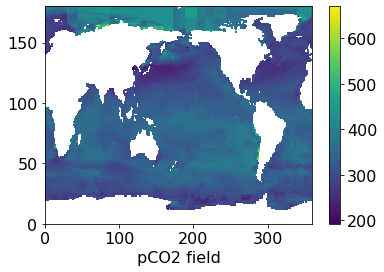

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [321.02082803456045 326

<class 'numpy.ndarray'>
global no Arc, apply some mask


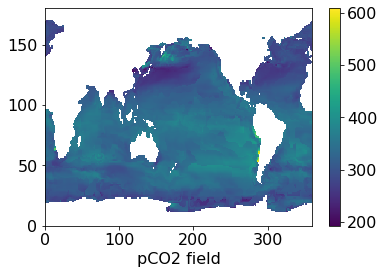

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [315.8750614597136 322.

<class 'numpy.ndarray'>
N_noArc, apply some mask


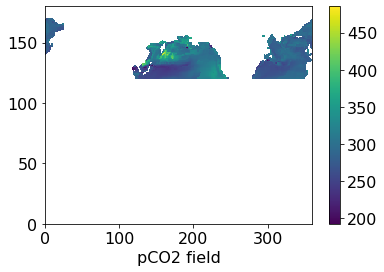

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [291.7454696671238 288.

<class 'numpy.ndarray'>
Arc, apply some mask


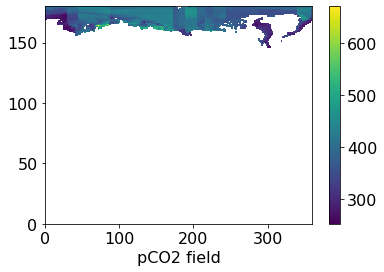

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [389.8670861881764 389.

<class 'numpy.ndarray'>
T, apply some mask


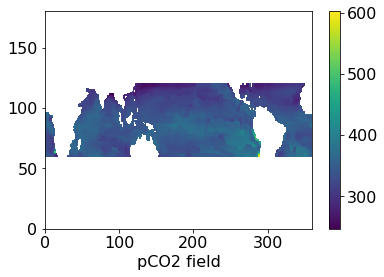

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [337.796228918111 337.6

<class 'numpy.ndarray'>
S, apply some mask


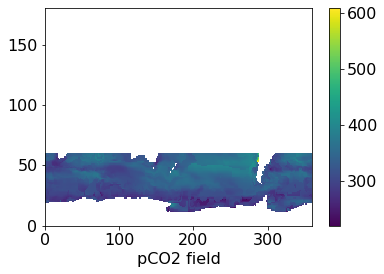

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [315.8750614597136 322.

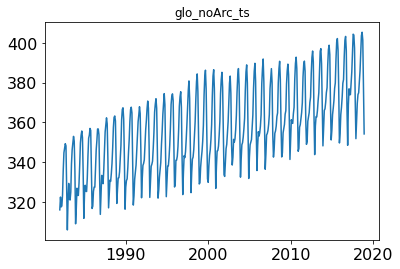

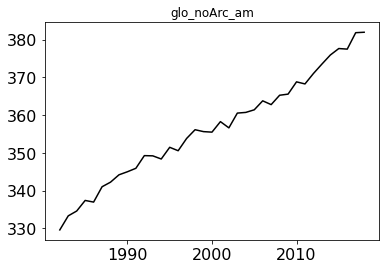

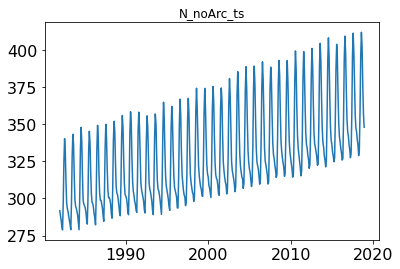

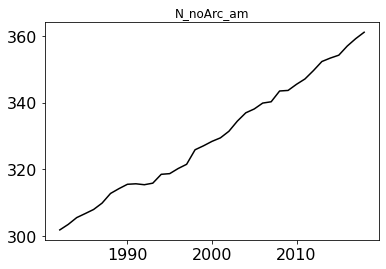

global
shape reg_arcT (756, 180, 360)
shape intYY (756, 180, 360)
<class 'numpy.ndarray'>
global, just return from if loop


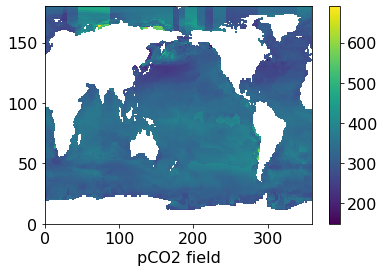

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [319.08170194117844 322

<class 'numpy.ndarray'>
global no Arc, apply some mask


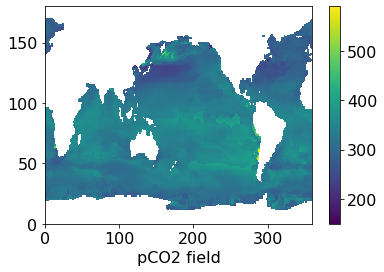

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [317.4073744217657 321.

<class 'numpy.ndarray'>
N_noArc, apply some mask


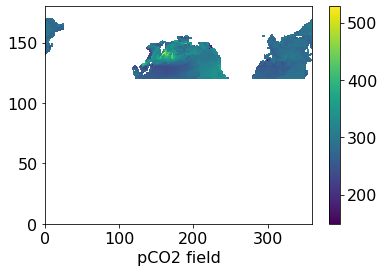

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [289.53363506906334 286

<class 'numpy.ndarray'>
Arc, apply some mask


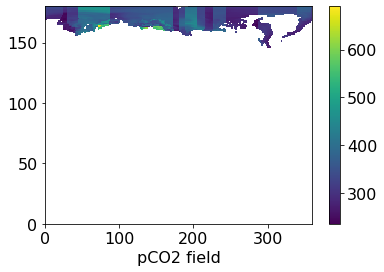

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [341.4828705442495 332.

<class 'numpy.ndarray'>
T, apply some mask


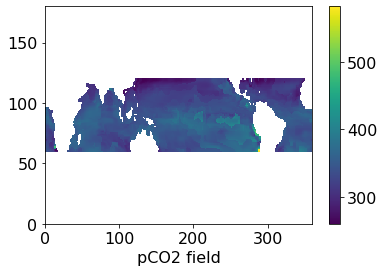

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [337.9537513809201 337.

<class 'numpy.ndarray'>
S, apply some mask


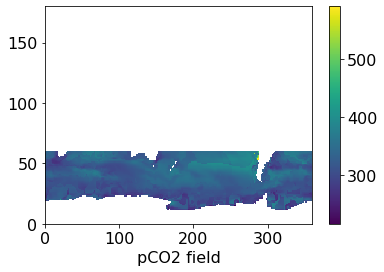

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [317.4073744217657 321.

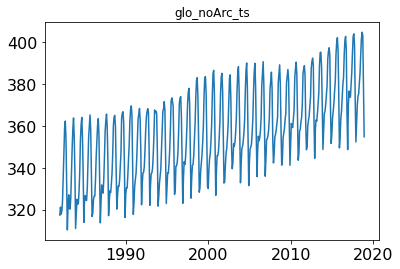

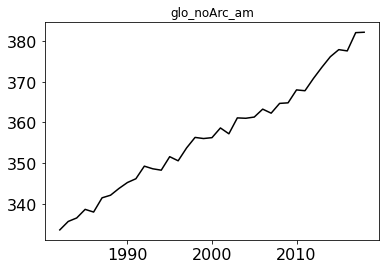

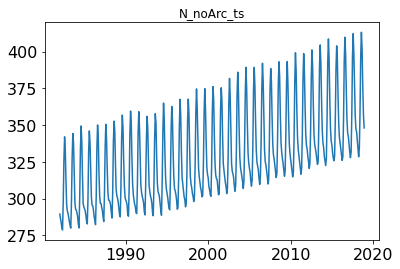

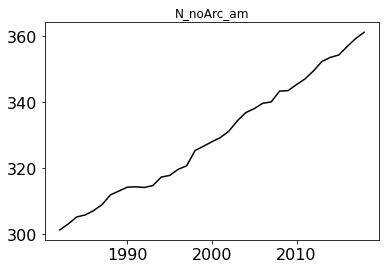

global
shape reg_arcT (756, 180, 360)
shape intYY (756, 180, 360)
<class 'numpy.ndarray'>
global, just return from if loop


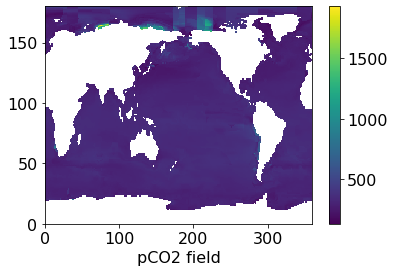

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [317.3819345219323 326.

<class 'numpy.ndarray'>
global no Arc, apply some mask


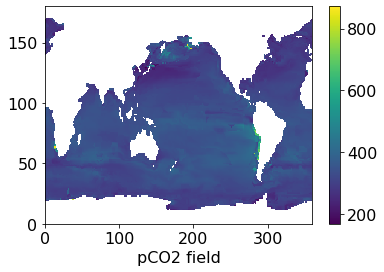

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [316.0196627294616 324.

<class 'numpy.ndarray'>
N_noArc, apply some mask


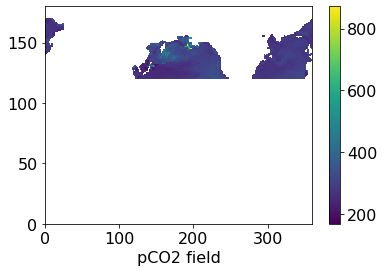

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [292.5239160647953 288.

<class 'numpy.ndarray'>
Arc, apply some mask


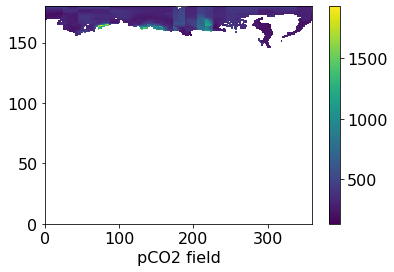

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [335.60804605180084 356

<class 'numpy.ndarray'>
T, apply some mask


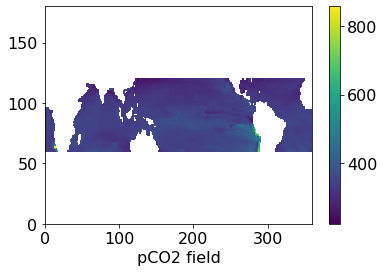

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [337.0740133898645 337.

<class 'numpy.ndarray'>
S, apply some mask


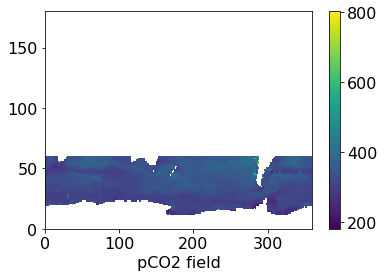

0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- -- --]
23 [-- -- -- -- -- -- -- -- -- -- -- --]
24 [316.0196627294616 324.

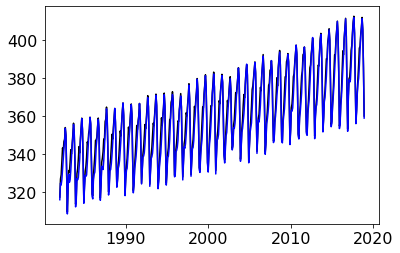

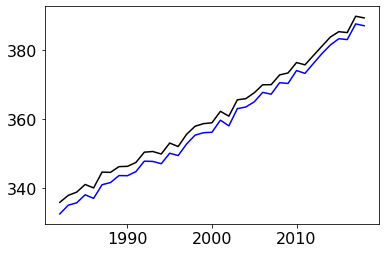

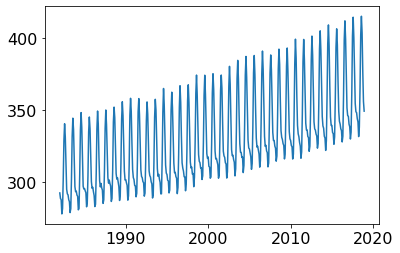

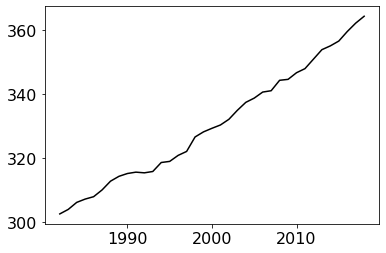

[         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan 335.95178593
 337.96002653 338.90207785 341.11244045 340.11813494 344.68895273
 344.60226725 346.26125707 346.34187152 347.454614   350.43095809
 350.62483303 349.90627706 353.06728108 352.05800729 355.59896597
 357.9048686  358.6635713  358.91194427 362.22281769 360.82361799
 365.53164148 365.87149111 367.56661265 369.87840691 369.91014038
 372.72460339 373.29196194 376.28990329 375.63593628 378.32611148
 381.00288387 383.64197613 385.200833   384.9429081  389.6562391
 389.17510568          nan          nan]


In [14]:
# spco2 for Landschützer 
#--------------------------------------------------------------------
# calculate means for spco2:
regions=('global','glo_noArc','N_noArc','Arc','T','S') #'N','Arc','N60',

# sim A
for reg in regions:
        print(reg)
        exec('land_spco2_A_'+reg+'_ts, land_spco2_A_'+reg+'_am = reg_ave_pCO2(land_spco2_1x1_A,"'+reg+'",areaT,YY,reg_arcT)')
        exec('land_spco2_A_'+reg+'_am[(gcb_years<1982) | (gcb_years>2018)]=np.nan')

plt.figure()
plt.plot(gcb_time,land_spco2_A_glo_noArc_ts)#, vmin=-60, vmax=750)
plt.title('glo_noArc_ts')
plt.show()

plt.figure()
plt.plot(gcb_years,land_spco2_A_glo_noArc_am,'k-')#, vmin=-60, vmax=750)
plt.title('glo_noArc_am')
plt.show()

plt.figure()
plt.plot(gcb_time,land_spco2_A_N_noArc_ts)#, vmin=-60, vmax=750)plt.show()
plt.title('N_noArc_ts')
plt.show()

plt.figure()
plt.plot(gcb_years,land_spco2_A_N_noArc_am,'k-')#, vmin=-60, vmax=750)
plt.title('N_noArc_am')
plt.show()

#print(land_spco2_A_N60_am, land_spco2_A_T_am)


# sim B
for reg in regions:
        print(reg)
        exec('land_spco2_B_'+reg+'_ts, land_spco2_B_'+reg+'_am = reg_ave_pCO2(land_spco2_1x1_B,"'+reg+'",areaT,YY,reg_arcT)')
        exec('land_spco2_B_'+reg+'_am[(gcb_years<1982) | (gcb_years>2018)]=np.nan')

plt.figure()
plt.plot(gcb_time,land_spco2_B_glo_noArc_ts)#, vmin=-60, vmax=750)
plt.title('glo_noArc_ts')

plt.show()

plt.figure()
plt.plot(gcb_years,land_spco2_B_glo_noArc_am,'k-')#, vmin=-60, vmax=750)
plt.title('glo_noArc_am')

plt.show()

plt.figure()
plt.plot(gcb_time,land_spco2_B_N_noArc_ts)#, vmin=-60, vmax=750)
plt.title('N_noArc_ts')

plt.show()

plt.figure()
plt.plot(gcb_years,land_spco2_B_N_noArc_am,'k-')#, vmin=-60, vmax=750)
plt.title('N_noArc_am')


plt.show()

#print(land_spco2_B_global_am, land_spco2_B_N_am)             
             
             
# sim C
for reg in regions:
        print(reg)
        exec('land_spco2_C_'+reg+'_ts, land_spco2_C_'+reg+'_am = reg_ave_pCO2(land_spco2_1x1_C,"'+reg+'",areaT,YY,reg_arcT)')
        exec('land_spco2_C_'+reg+'_am[(gcb_years<1982) | (gcb_years>2018)]=np.nan')

plt.figure()
plt.plot(gcb_time,land_spco2_C_global_ts,'k')#, vmin=-60, vmax=750)
plt.plot(gcb_time,land_spco2_C_glo_noArc_ts,'b')#, vmin=-60, vmax=750)

plt.show()

plt.figure()
plt.plot(gcb_years,land_spco2_C_global_am,'k-')#, vmin=-60, vmax=750)
plt.plot(gcb_years,land_spco2_C_glo_noArc_am,'b-')#, vmin=-60, vmax=750)

plt.show()

plt.figure()
plt.plot(gcb_time,land_spco2_C_N_noArc_ts)#, vmin=-60, vmax=750)
plt.show()

plt.figure()
plt.plot(gcb_years,land_spco2_C_N_noArc_am,'k-')#, vmin=-60, vmax=750)

plt.show()

print(land_spco2_C_global_am)#, land_spco2_C_N_am)             
                          
             
             

In [15]:
print(np.shape(land_spco2_A_N_noArc_ts))
print(land_spco2_A_N_noArc_ts)

index = np.where(land_spco2_A_N_noArc_ts>0)
print(np.shape(index))
print(444./12)
print(index[0])

(756,)
[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 291.7454696671238 288.28403307943415 285.4767442896281 281.0329142791021
 278.7983235255484 297.0899860665014 325.05

global
shape reg_arcT (756, 180, 360)
shape intYY (756, 180, 360)
<class 'numpy.ndarray'>
global, just return from if loop


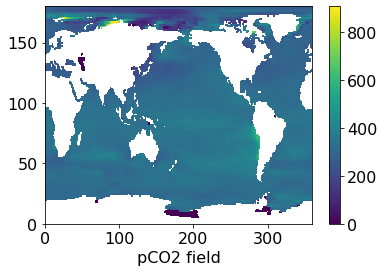

0 [283.9844161631685 290.7763440367133 293.73087567448397 293.7123125852586
 296.1010189569157 300.09145201875725 304.88325993542065 305.7586203582463
 302.6358154870881 296.01063565351166 285.790609009627 277.8526319066636]
1 [278.66305376976584 285.1662899889548 288.3573712852184 289.0381588978234
 291.7601674000877 297.63047895911393 304.04477876233415 308.2029535666098
 306.04447800249966 298.3847481167826 287.4848672403148 279.5292496471738]
2 [281.34435772794006 288.8018748630704 290.8638195898284 290.71337933189176
 292.472795622148 296.8997148766293 302.5011900538794 306.7932730615422
 305.4043889047373 297.76821666557976 288.3100171126162 282.5369628535313]
3 [283.7914230447162 289.4166991654648 291.95026182559053 291.0301553827733
 292.3928575128351 297.5131876169875 303.3641066050472 307.0968289574679
 306.48136724012767 298.64389898587876 287.75235168965577
 279.93482896276146]
4 [281.05260737855446 287.6025850515781 291.11872632996017
 292.77619474611316 295.12801234355675

<class 'numpy.ndarray'>
global no Arc, apply some mask


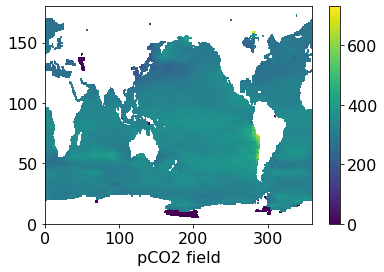

0 [307.4019021171521 315.534758538386 319.01047161500827 318.6918655785481
 320.3385021736663 323.28785649294247 327.8534533068003 327.8971099011892
 323.6024990656808 317.41627679198825 307.5396491160242 299.43711451048904]
1 [300.71858301389284 308.29293318591857 312.0864581518145 312.6037313063336
 314.5461846505695 319.15829516136387 324.4263013095474 327.6954417816157
 325.3596047817015 318.6993739957988 308.3506062462451 300.26249251901055]
2 [302.8147525338987 311.5564485699234 314.02197169028295 313.5195070211261
 314.39450766412796 317.6575263275576 322.42998421946817 325.5140054170886
 323.51765442156625 317.3059282466354 308.515968108522 302.940708170673]
3 [304.81280145181864 311.5098309907517 314.7382359440781 313.59131730170463
 314.0911265103521 318.3762115783118 323.858782045245 326.50781761965914
 325.06279349315594 318.35477503098406 307.79504228419677
 299.7682631088646]
4 [301.43530874641476 309.19073500353505 313.47245881700394
 315.07244598425154 316.5838124756967

<class 'numpy.ndarray'>
N_noArc, apply some mask


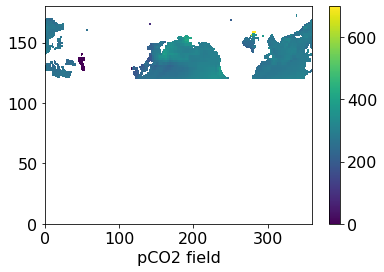

0 [272.0192784429293 269.75093467595514 266.5502693525975 265.1321564747046
 272.833255839933 291.7485611872156 314.58283497111137 326.93005692248335
 320.193196745971 303.0034041866456 287.7661955258777 277.11942574099953]
1 [271.93075240480204 269.9788525819564 267.2613120635272 265.7368140110438
 272.48627600488066 289.32771260764633 312.2426058474186 327.1658002424144
 319.78578190152535 302.73612363825794 287.98337028137723
 277.68870832427524]
2 [272.84472434795686 270.0233254873488 267.0057777072937 265.62940299121846
 272.54989819955455 290.8091852233529 313.7821874461 327.32195591854014
 320.72174109757907 304.16956753560834 287.7806893478597 277.1639031834458]
3 [272.29869760090276 269.7719119722722 266.9984352904392 265.5077513396952
 272.5332701061663 290.5400439090108 313.12170344489965 326.0098988815685
 318.05735055311527 302.63046889435594 288.1974897235925
 277.69611052689703]
4 [272.75848471731274 270.4679015283521 267.02944558193474 265.237288377456
 271.056809402688

<class 'numpy.ndarray'>
Arc, apply some mask


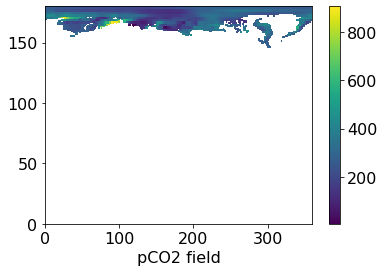

0 [120.30709778452425 117.72655974715067 117.03827590645443
 119.11687325103168 126.6923016863809 137.95939019872455 144.332308349315
 151.0208911048573 156.0884640685295 146.39517536856883 133.77494990258708
 126.98715308767618]
1 [124.5051783601569 123.52182700018503 122.50210767876548
 124.32578518434325 132.4965211053009 147.16107189053915 161.5874303707475
 171.95954102314022 171.04073927599117 156.39497627378324
 141.64307136220648 134.61354002642835]
2 [131.27629947114593 129.7580042910744 128.99912404327824
 131.30917043816046 139.25024012021004 151.81228233268064
 163.20820215785577 175.94407447287384 178.80110054574143
 161.20871385957636 147.0798320791308 139.92428765205548]
3 [136.8617802530678 134.99599922975355 132.67293793500073
 133.33814311239144 140.73206480643898 151.69036863594044
 160.11587220089328 171.42306032368128 176.60585341586008
 160.87405724042586 147.66328081100792 141.3083631819054]
4 [138.58701957976808 136.71147317749302 134.87654916275253
 136.9357847

<class 'numpy.ndarray'>
T, apply some mask


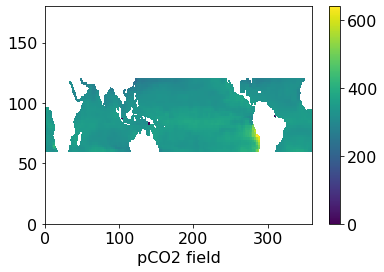

0 [318.08115389177703 320.7761801576591 321.621238628533 322.5670619213069
 322.6145666879628 320.3204133007763 317.40544166504264 315.8747804548234
 315.33336001306213 315.6437118116141 316.27468633379067 316.9253132821689]
1 [318.44271021594443 320.7126239944984 321.7367095639934 321.97865503844974
 321.80522311794675 320.2443263203377 318.40945370433457
 317.11838179386876 316.66391773616454 317.2277740904498 317.8717301618456
 317.98171955478165]
2 [319.33522735857633 321.5883968230076 322.3190002068883 323.08243835799874
 323.6126371669047 321.6153934971577 319.1426809528094 317.2476405586541
 316.7309097523846 317.4815875634664 318.1292713898304 318.2026122307786]
3 [319.5326442338268 321.6344694958214 322.15912564120424 322.8049098900081
 323.13322417783894 321.3863062356343 319.324254703853 318.04665152817955
 317.22626242614746 317.6572646014246 318.41880838826853
 318.51442595782623]
4 [319.6697393542146 321.825503516841 323.70044040635025 324.6546048270468
 324.7457673200864

<class 'numpy.ndarray'>
S, apply some mask


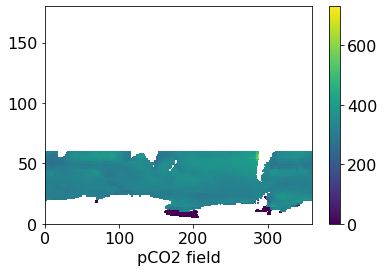

0 [307.4019021171521 315.534758538386 319.01047161500827 318.6918655785481
 320.3385021736663 323.28785649294247 327.8534533068003 327.8971099011892
 323.6024990656808 317.41627679198825 307.5396491160242 299.43711451048904]
1 [300.71858301389284 308.29293318591857 312.0864581518145 312.6037313063336
 314.5461846505695 319.15829516136387 324.4263013095474 327.6954417816157
 325.3596047817015 318.6993739957988 308.3506062462451 300.26249251901055]
2 [302.8147525338987 311.5564485699234 314.02197169028295 313.5195070211261
 314.39450766412796 317.6575263275576 322.42998421946817 325.5140054170886
 323.51765442156625 317.3059282466354 308.515968108522 302.940708170673]
3 [304.81280145181864 311.5098309907517 314.7382359440781 313.59131730170463
 314.0911265103521 318.3762115783118 323.858782045245 326.50781761965914
 325.06279349315594 318.35477503098406 307.79504228419677
 299.7682631088646]
4 [301.43530874641476 309.19073500353505 313.47245881700394
 315.07244598425154 316.5838124756967

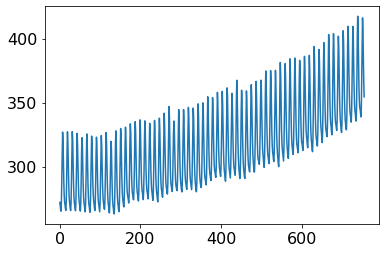

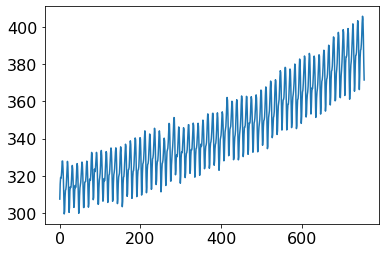

[288.96913084 288.69367583 289.15019654 288.61359435 287.2083847
 287.75663052 287.39372973 287.36017973 287.35847517 288.82933705
 285.13299426 287.28161242 289.84255966 292.13986419 295.05071803
 296.75855695 297.27907764 297.27851565 297.34238627 297.12402459
 297.54979844 300.64085351 303.96517492 302.11434982 304.51855865
 304.4842509  306.24019429 305.90487585 306.22805624 308.51745666
 311.74777149 313.44237146 316.36272075 316.8442684  316.53645602
 316.52576489 320.39882663 316.53152    317.2497917  320.90127943
 322.7775748  326.1059147  327.94784331 329.72370999 329.96291144
 331.03001732 333.7001561  336.39443387 337.62929618 337.92228221
 340.26903177 341.42511069 342.3843902  345.541599   348.34489552
 353.32450043 354.58540545 355.72131759 356.88567849 359.7643475
 363.46318514          nan          nan] [317.33428827 314.35000051 314.51574687 314.87224978 315.78477895
 316.57511978 319.37783185 321.26290975 319.98671055 320.17865714
 322.01625588 321.95188567 321.085496

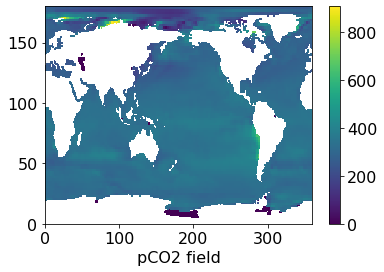

0 [283.67818784142264 290.23172255808527 292.91553643108614 292.910102904426
 295.4382649883224 300.1073347782441 305.4592843285998 306.81371628238617
 303.9087476096542 296.7164807741314 285.65102625755094 277.7304521041109]
1 [278.98900447467935 285.207405252126 288.1072398054935 288.70386394390204
 291.5501277375176 297.8312780326151 304.7476611721918 309.3068042463569
 307.38486698283714 299.2160889860346 287.46346875885735
 279.43658795994065]
2 [281.54501958239473 288.7467035501568 290.73897394314287 290.554042471674
 292.458224020776 297.3619199582871 303.41623215665925 307.9705251257924
 306.79309566752534 298.6933296039804 288.40322961655914
 282.48400826110816]
3 [284.08989558210754 289.32967603245726 291.5652358092214 290.6778517023782
 292.23807474281034 297.7769074722367 304.0669484292808 308.2277914176416
 307.8877458517278 299.5745578368949 287.76864661941113 279.7936920761663]
4 [281.2550371636827 287.613738156958 290.86706973374845 292.3902213876495
 295.02326737040755

<class 'numpy.ndarray'>
global no Arc, apply some mask


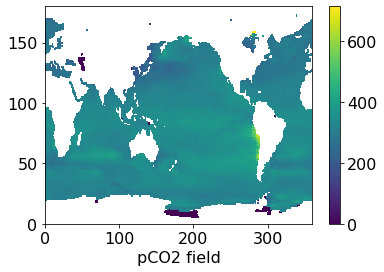

0 [307.0481256100818 314.90881991284175 318.07526774814085
 317.77168976282303 319.57708777569144 323.30095593372175
 328.5062302350055 329.09629748623087 325.04972985690455 318.2160062097638
 307.37470490089464 299.29345120555746]
1 [301.08759801854086 308.3364110324135 311.79713470366573
 312.21816485947977 314.30185202461223 319.3823920774158 325.2217686222683
 328.9479522852127 326.88220832108743 319.64192315140554 308.3202154576315
 300.1516436872573]
2 [303.0399432985955 311.4895431989322 313.87547442061464 313.33351894388477
 314.37333073290466 318.1802508877583 323.46752839201116 326.8499217537643
 325.09491917305286 318.3557146148158 308.61659569472647
 302.87525794742663]
3 [305.14953775092795 311.4061903699497 314.294297110993 313.18478162652013
 313.90975895597944 318.67216167770374 324.65562266282143
 327.7923785794623 326.66132545833193 319.41124695626263
 307.80798856844837 299.60210695054036]
4 [301.66227215503545 309.1993719887488 313.1810178934329 314.62735301869617
 

<class 'numpy.ndarray'>
N_noArc, apply some mask


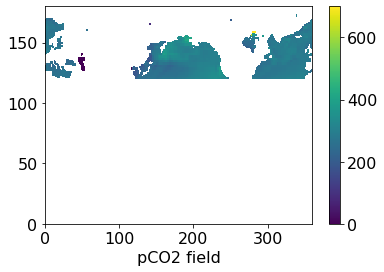

0 [272.02494339430183 269.75547376671443 266.5548687778969 265.1373892729681
 272.83839484763234 291.75496377402965 314.5909392247699
 326.93712633274737 320.1988159370333 303.0092702043329 287.77136965369897
 277.12357853987254]
1 [271.9342606852955 269.9821859306084 267.2646616123289 265.7405494241753
 272.48984556707853 289.33258166396257 312.249965724398 327.17239619238694
 319.7906668393424 302.7413893012447 287.9881155400126 277.69200160828905]
2 [272.84705675314524 270.0255495200764 267.0084874888624 265.6331114347636
 272.55397037697827 290.814323106373 313.78811715208457 327.3257366132783
 320.72423184834713 304.1728298517467 287.7839381309716 277.16630622201853]
3 [272.30055682623384 269.77381870136884 267.00073029327314
 265.51078230022745 272.5366295228539 290.54463275506725
 313.12750659324536 326.0144474136014 318.06054280352856 302.6336482427073
 288.20040308644013 277.698119014229]
4 [272.7600811825493 270.4692659301168 267.03128633455884 265.24029624555504
 271.0606516

<class 'numpy.ndarray'>
Arc, apply some mask


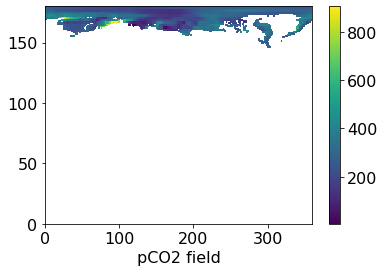

0 [120.33320912908496 117.75030724594448 117.06073454522594
 119.1391919015771 126.71913816071495 137.99472705943893
 144.37186827587695 151.06885344072583 156.14312968977626
 146.44481298568004 133.81263196326256 127.0151329592095]
1 [124.53012967033457 123.5464289064729 122.52590980174304
 124.34985408250012 132.52617328230255 147.19902989731742
 161.64318743791083 172.02432878357118 171.107533368593 156.4490230249646
 141.68452491893342 134.64799800737225]
2 [131.3055156691762 129.78484857811083 129.02561315538543
 131.33611317014683 139.2818366975742 151.85148445078264 163.2670118574618
 176.0123371825816 178.87187480246544 161.26241759976023
 147.12121661219302 139.9586716983158]
3 [136.89280692024982 135.02512459559532 132.69968506443973
 133.36489581298065 140.76309729516083 151.72881409827076
 160.16170624660526 171.4804408213957 176.66916959571248 160.9253413091654
 147.7029812129535 141.34209935010512]
4 [138.61797076504803 136.74021279076325 134.90296648226663
 136.963029888

<class 'numpy.ndarray'>
T, apply some mask


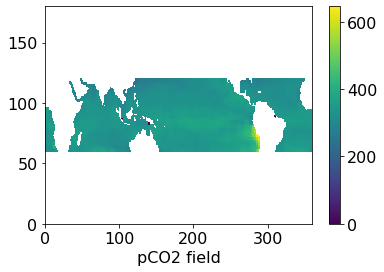

0 [317.83524677997696 320.52977812205415 321.43904403316174
 322.4334690632496 322.4555940665784 320.15995458546234 317.29820348535605
 315.80023279717966 315.23752890628543 315.52874589367485
 316.17488717728827 316.8312841989412]
1 [318.325673180929 320.59078295700584 321.65340247303067 321.92462566702955
 321.7162077021009 320.1261092434523 318.33017508741773 317.0656013797699
 316.5887598613731 317.1392024506507 317.8096160714335 317.95618302890205]
2 [319.27360348251807 321.4678568401557 322.2372439441274 323.04580613659584
 323.534695923439 321.51002783748567 319.07547498886004 317.2038318483636
 316.6649766567181 317.39877668837835 318.0852522382592 318.18981505985073]
3 [319.4918934095927 321.56642783969994 322.11923875993193
 322.78854069803987 323.08126255585313 321.3131426822495
 319.28394451296253 318.03041544652 317.18288532310316 317.5932208139143
 318.38222854317746 318.48792511379605]
4 [319.60137552262324 321.7133557207848 323.6275797443172 324.62695487277585
 324.6883

<class 'numpy.ndarray'>
S, apply some mask


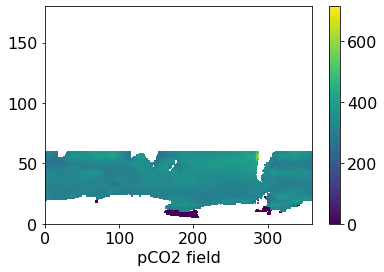

0 [307.0481256100818 314.90881991284175 318.07526774814085
 317.77168976282303 319.57708777569144 323.30095593372175
 328.5062302350055 329.09629748623087 325.04972985690455 318.2160062097638
 307.37470490089464 299.29345120555746]
1 [301.08759801854086 308.3364110324135 311.79713470366573
 312.21816485947977 314.30185202461223 319.3823920774158 325.2217686222683
 328.9479522852127 326.88220832108743 319.64192315140554 308.3202154576315
 300.1516436872573]
2 [303.0399432985955 311.4895431989322 313.87547442061464 313.33351894388477
 314.37333073290466 318.1802508877583 323.46752839201116 326.8499217537643
 325.09491917305286 318.3557146148158 308.61659569472647
 302.87525794742663]
3 [305.14953775092795 311.4061903699497 314.294297110993 313.18478162652013
 313.90975895597944 318.67216167770374 324.65562266282143
 327.7923785794623 326.66132545833193 319.41124695626263
 307.80798856844837 299.60210695054036]
4 [301.66227215503545 309.1993719887488 313.1810178934329 314.62735301869617
 

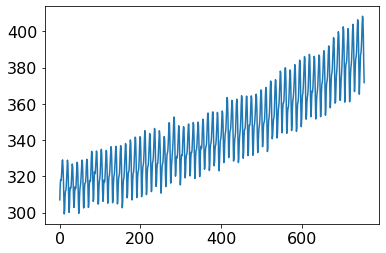

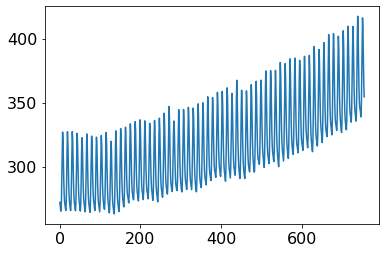

[317.35153055 314.69077202 314.96266659 315.21228306 316.24187209
 317.03473679 319.65604075 321.433396   320.39037558 320.51127454
 322.31323331 322.0912781  321.40983828 322.78642229 324.46017758
 325.68328472 326.11256539 328.11699963 328.32260257 330.17486787
 329.77345052 328.39166288 334.18621262 335.36948325 333.38492939
 333.83538557 335.08507614 335.43328007 336.1624571  338.00043903
 339.8828951  341.04636925 339.94652016 341.89625786 346.98227053
 346.9219279  345.50897995 346.77106908 348.4770164  349.4767275
 350.10163812 351.44702181 352.99005726 355.19984474 356.92758441
 361.14825321 363.48557799 362.12223296 364.8697233  365.10321771
 369.01577556 369.37076808 370.21109066 370.31302252 373.4549814
 375.03934691 379.7454081  381.21936605 381.59971004 383.97415084
 384.95865591          nan          nan] [288.97476114 288.69821834 289.15363821 288.61681813 287.21181245
 287.75930914 287.39532523 287.36136354 287.35980535 288.83080443
 285.13395586 287.28302107 289.843436

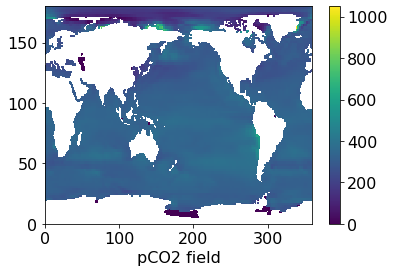

0 [294.0065023542374 299.00179948842805 299.23465526153626 297.4936420348877
 298.29400498691206 302.346926125944 308.78527365762267 314.1008797060925
 315.36704745562724 310.1870261154414 298.2740841548969 290.4458594829702]
1 [294.04232647045023 298.58139200838315 298.7572690766885 298.5223481085769
 300.6043559127651 304.9753229125204 310.5735061229963 315.469923933768
 316.7851779130625 311.4590669847766 299.35471426182477 290.86319086876176]
2 [293.89672044699915 299.4942237807916 300.1193289489085 298.6560533152051
 300.74592517113047 306.0038154181938 312.1613235601378 316.5790872626418
 316.62607619255033 310.5557511935064 299.6351200229866 293.18543250255857]
3 [296.5296671984611 300.29753956954596 299.40281207703526
 297.93721305208436 300.12615732142785 304.5155795863225 309.9730942756649
 314.4370508046029 315.7085722358634 310.53774587675423 298.3973659054875
 290.3507859172244]
4 [293.9974057996348 299.2529246258295 300.30669993233005 300.30766455775455
 303.0823411109034

<class 'numpy.ndarray'>
global no Arc, apply some mask


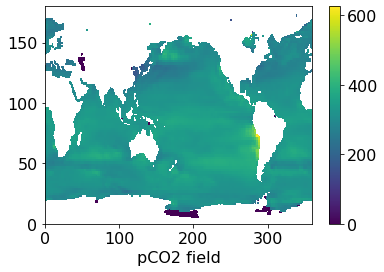

0 [303.54270774123063 309.7816694375894 309.83210969880184
 307.46869123986374 307.86895429055664 311.9678112429587 318.908964897177
 325.3142171494969 327.47017409000546 322.00376152951503 308.6508193781744
 299.80627837044153]
1 [303.9120016357668 309.0165695829359 309.0167840681826 308.37147516977507
 310.3054890166792 314.9286995023953 321.26305221765045 327.7379921156114
 329.9848402010039 324.0652689717823 310.2284662000147 300.3777960192621]
2 [303.7327603841124 309.9480049486312 310.34110556287806 308.2599397909056
 310.2361786453525 315.9768740281187 322.9120737038498 328.8066001218563
 329.7421364262739 322.88103423579133 310.35107475046846
 302.85132425019634]
3 [306.5902150921017 310.79960441087854 309.66778256413204
 307.82611017315566 309.9664397496999 314.7479592078513 321.0365603460733
 326.93442418189363 329.14224642414337 323.2668520740404 309.2435472102387
 299.85360478633413]
4 [303.9596598410629 309.83952412034967 310.78796813459235 310.3272519982052
 312.916185808

<class 'numpy.ndarray'>
N_noArc, apply some mask


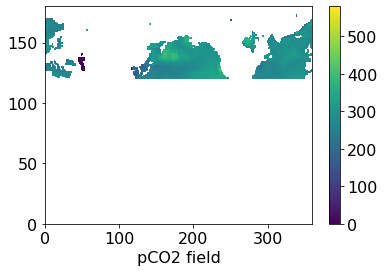

0 [267.0048759226662 265.2212768004827 262.6986919195974 261.21352310998697
 266.3393478279163 281.4159893020348 301.78427075601087 313.98571044120126
 308.77048506713027 294.08101511362406 280.5918706692073
 272.15449178710867]
1 [267.9964840930849 265.3852067800349 262.71489614335195 261.07096820351074
 265.1481480522542 278.68331923068524 299.40434429338717 313.3720900413917
 307.95563817067483 293.38086677451616 280.74539066845534
 273.49950953666155]
2 [270.7143124107884 268.5525415795413 265.77052080871914 263.2265488414347
 266.17811221851974 280.11841168927236 302.15959608760653
 317.0247849073066 311.1039232630881 295.39893440492125 280.5598974437122
 272.4858823377937]
3 [269.17180594348 266.9792614665084 264.6551626778621 263.0937060911256
 267.71536674334294 282.07056505628105 303.4407074458562 316.4123259862174
 310.2337073233738 296.4520300801464 283.0591245076711 273.9603794107981]
4 [269.4877511085554 266.7088467408983 263.41139175774117 261.7096376146389
 265.987253220

<class 'numpy.ndarray'>
Arc, apply some mask


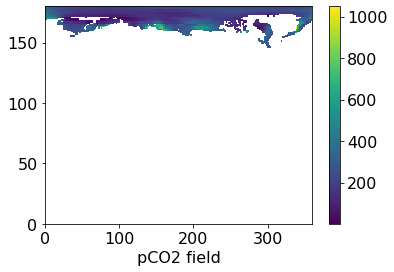

0 [227.35286889767437 223.65553007178693 225.16338529942428
 227.77269471484618 231.36956960082338 235.1014208024277
 238.02538775698665 235.72487442449 230.77183021476145 227.5935500964453
 225.74553868213422 225.02089177239947]
1 [225.05789460181433 225.64436172408747 227.04803842003093 229.681537915918
 232.7979545423036 235.40585707639963 235.85855837429276 229.7218421099412
 224.5256872470102 223.34758737389078 223.35225347440831
 224.36053300336394]
2 [225.14738315538955 226.4271630454316 228.67387197168523
 231.52936057609094 234.41347417930987 236.296781430292 237.0185880188674
 231.11446825232628 224.95092494159195 224.40776414728003
 224.73558823260595 225.62535179617979]
3 [226.2111238720418 226.89299844819027 227.65545004741884 228.8184286667819
 231.34716699287526 232.99601252540097 232.64462007754014
 227.08623248058737 221.81344739493147 221.56722308780547
 222.58761100273026 223.93050866840824]
4 [224.36589071249233 225.2575256570092 227.04751763049083
 230.275415718748

<class 'numpy.ndarray'>
T, apply some mask


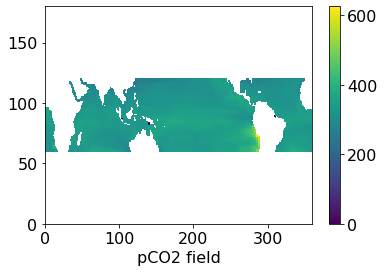

0 [317.53791731363134 319.65876754630216 321.4566493087853 322.1679011159003
 321.1301196992623 318.32266715835016 315.42724877746804
 314.46387251229896 314.6100318153741 315.15058164732704 315.7261772836216
 316.48855458390074]
1 [317.07327923155094 318.0718855198894 319.0790841670233 318.97868323116296
 318.17409818989057 316.48224389068537 314.50230671895184
 313.47916966298584 313.73263292911116 314.70653931136303 315.417721029873
 315.8510988624624]
2 [316.63799693790463 317.8253820960282 319.15218267128125 319.781460099063
 319.4108333973043 317.14946038535095 314.7438483527961 313.3232519889183
 313.52980276814736 314.84124519394373 315.902683427299 316.43528042077736]
3 [317.2562919397773 318.56835353772124 319.7837767262583 320.4754247206847
 319.84787597446365 317.5640012246589 315.44091269395994 314.7483115937202
 314.862040888551 316.0003430582814 317.21068119628865 317.70288472045513]
4 [318.257229669977 319.3860232560969 321.85282424816205 323.01962236674973
 322.5255138

<class 'numpy.ndarray'>
S, apply some mask


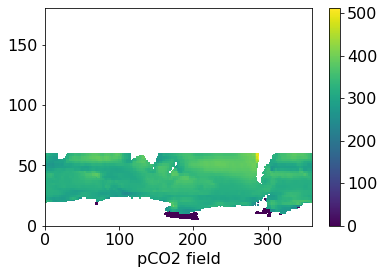

0 [303.54270774123063 309.7816694375894 309.83210969880184
 307.46869123986374 307.86895429055664 311.9678112429587 318.908964897177
 325.3142171494969 327.47017409000546 322.00376152951503 308.6508193781744
 299.80627837044153]
1 [303.9120016357668 309.0165695829359 309.0167840681826 308.37147516977507
 310.3054890166792 314.9286995023953 321.26305221765045 327.7379921156114
 329.9848402010039 324.0652689717823 310.2284662000147 300.3777960192621]
2 [303.7327603841124 309.9480049486312 310.34110556287806 308.2599397909056
 310.2361786453525 315.9768740281187 322.9120737038498 328.8066001218563
 329.7421364262739 322.88103423579133 310.35107475046846
 302.85132425019634]
3 [306.5902150921017 310.79960441087854 309.66778256413204
 307.82611017315566 309.9664397496999 314.7479592078513 321.0365603460733
 326.93442418189363 329.14224642414337 323.2668520740404 309.2435472102387
 299.85360478633413]
4 [303.9596598410629 309.83952412034967 310.78796813459235 310.3272519982052
 312.916185808

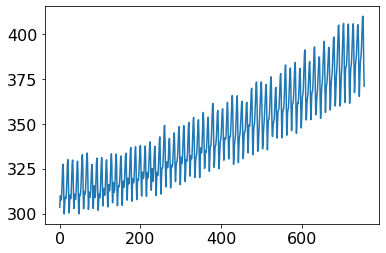

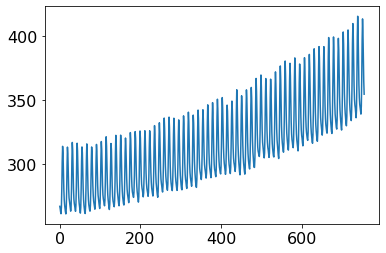

roeden pCO2 N_Arc, T
[229.44146186 228.06684216 229.19505998 226.96256861 233.0270208
 237.27102084 235.27045249 226.71294866 223.91130653 229.44661452
 231.92149364 237.45084063 239.62804719 231.38282248 221.01989361
 212.69787032 215.87782595 219.48754776 219.94903107 212.28842529
 206.66264142 207.184779   209.71050715 204.95954069 201.02136217
 196.91732837 192.31383403 189.34767438 187.10895612 186.85158445
 185.14888807 185.42866849 180.6444074  176.41786461 173.85964001
 179.31188451 177.65746643 171.30347764 167.22200961 161.04933195
 161.438471   162.82736606 159.69460246 154.37882048 150.26110602
 146.40771866 147.33040629 153.78522782 151.86048424 147.44414491
 141.514388   137.89860622 140.95124276 141.1175984  137.76652065
 136.21872462 132.19669258 127.25273338 127.12655743 130.43478909
 131.3352134           nan          nan] [229.44146186 228.06684216 229.19505998 226.96256861 233.0270208
 237.27102084 235.27045249 226.71294866 223.91130653 229.44661452
 231.92149364 23

In [16]:
# do pco2 averaging also from 1x1 fields for Rödenbeck rather than from native mesh

# spco2 for Rödenbeck
#--------------------------------------------------------------------
# calculate means for spco2:

# calculate means for spco2:
regions=('global','glo_noArc','N_noArc','Arc','T','S') #'N','Arc','N60',

# sim A
for reg in regions:
        print(reg)
        exec('roeden_spco2_A_'+reg+'_ts, roeden_spco2_A_'+reg+'_am = reg_ave_pCO2(roeden_spco2_1x1_A,"'+reg+'",areaT,YY,reg_arcT)')
        exec('roeden_spco2_A_'+reg+'_am[(gcb_years>2018)]=np.nan')  # only later than 2018 for roedenbeck, (gcb_years<1982) | 

plt.figure()
plt.plot(roeden_spco2_A_N_noArc_ts)#, vmin=-60, vmax=750)

plt.show()

plt.figure()
plt.plot(roeden_spco2_A_glo_noArc_ts)#, vmin=-60, vmax=750)

plt.show()

print(roeden_spco2_A_N_noArc_am, roeden_spco2_A_glo_noArc_am)


# sim B
for reg in regions:
        print(reg)
        exec('roeden_spco2_B_'+reg+'_ts, roeden_spco2_B_'+reg+'_am = reg_ave_pCO2(roeden_spco2_1x1_B,"'+reg+'",areaT,YY,reg_arcT)')
        exec('roeden_spco2_B_'+reg+'_am[(gcb_years>2018)]=np.nan')

plt.figure()
plt.plot(roeden_spco2_B_glo_noArc_ts)#, vmin=-60, vmax=750)

plt.show()

plt.figure()
plt.plot(roeden_spco2_B_N_noArc_ts)#, vmin=-60, vmax=750)

plt.show()

print(roeden_spco2_B_glo_noArc_am, roeden_spco2_B_N_noArc_am)             
             
             
# sim C
for reg in regions:
        print(reg)
        exec('roeden_spco2_C_'+reg+'_ts, roeden_spco2_C_'+reg+'_am = reg_ave_pCO2(roeden_spco2_1x1_C,"'+reg+'",areaT,YY,reg_arcT)')
        exec('roeden_spco2_C_'+reg+'_am[(gcb_years>2018)]=np.nan')

plt.figure()
plt.plot(roeden_spco2_C_glo_noArc_ts)#, vmin=-60, vmax=750)

plt.show()

plt.figure()
plt.plot(roeden_spco2_C_N_noArc_ts)#, vmin=-60, vmax=750)

plt.show()

print('roeden pCO2 N_Arc, T')
print(roeden_spco2_C_Arc_am, roeden_spco2_C_Arc_am)             
                          



# roeden_spco2_A_glo= reg_ave_pCO2(roeden_spco2_1x1_A,'global',areaT,xax,yax)
# roeden_spco2_A_N= reg_ave_pCO2(roeden_spco2_1x1_A,'N',areaT,xax,yax)
# roeden_spco2_A_N60= reg_ave_pCO2(roeden_spco2_1x1_A,'N60',areaT,xax,yax)
# roeden_spco2_A_Arc= reg_ave_pCO2(roeden_spco2_1x1_A,'Arc',areaT,xax,yax)
# roeden_spco2_A_T= reg_ave_pCO2(roeden_spco2_1x1_A,'T',areaT,xax,yax)
# roeden_spco2_A_S= reg_ave_pCO2(roeden_spco2_1x1_A,'S',areaT,xax,yax)

# roeden_spco2_A_glo[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_A_N[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_A_N60[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_A_Arc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_A_T[(gcb_years<1982) | (gcb_years>2018) ]=np.nan
# roeden_spco2_A_S[(gcb_years<1982) | (gcb_years>2018)]=np.nan


# print(roeden_spco2_A_glo)

# roeden_spco2_B_glo= reg_ave_pCO2(roeden_spco2_1x1_B,'global',areaT,xax,yax)
# roeden_spco2_B_N= reg_ave_pCO2(roeden_spco2_1x1_B,'N',areaT,xax,yax)
# roeden_spco2_B_N60= reg_ave_pCO2(roeden_spco2_1x1_B,'N60',areaT,xax,yax)
# roeden_spco2_B_Arc= reg_ave_pCO2(roeden_spco2_1x1_B,'Arc',areaT,xax,yax)
# roeden_spco2_B_T= reg_ave_pCO2(roeden_spco2_1x1_B,'T',areaT,xax,yax)
# roeden_spco2_B_S= reg_ave_pCO2(roeden_spco2_1x1_B,'S',areaT,xax,yax)

# roeden_spco2_B_glo[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_B_N[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_B_N60[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_B_Arc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_B_T[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_B_S[(gcb_years<1982) | (gcb_years>2018)]=np.nan

# print(roeden_spco2_B_glo)

# roeden_spco2_C_glo= reg_ave_pCO2(roeden_spco2_1x1_C,'global',areaT,xax,yax)
# roeden_spco2_C_N= reg_ave_pCO2(roeden_spco2_1x1_C,'N',areaT,xax,yax)
# roeden_spco2_C_N60= reg_ave_pCO2(roeden_spco2_1x1_C,'N60',areaT,xax,yax)
# roeden_spco2_C_Arc= reg_ave_pCO2(roeden_spco2_1x1_C,'Arc',areaT,xax,yax)
# roeden_spco2_C_T= reg_ave_pCO2(roeden_spco2_1x1_C,'T',areaT,xax,yax)
# roeden_spco2_C_S= reg_ave_pCO2(roeden_spco2_1x1_C,'S',areaT,xax,yax)

# roeden_spco2_C_glo[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_C_N[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_C_N60[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_C_Arc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_C_T[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# roeden_spco2_C_S[(gcb_years<1982) | (gcb_years>2018)]=np.nan

# print(roeden_spco2_C_glo)



In [17]:

# # Rödenbeck:
# roeden_fgco2_PgCyr_A_glo= integrate_CO2flux(roeden_fgco2_1x1_A,'global',areaT,xax,yax)
# roeden_fgco2_PgCyr_A_N= integrate_CO2flux(roeden_fgco2_1x1_A,'N',areaT,xax,yax)
# roeden_fgco2_PgCyr_A_T= integrate_CO2flux(roeden_fgco2_1x1_A,'T',areaT,xax,yax)
# roeden_fgco2_PgCyr_A_S= integrate_CO2flux(roeden_fgco2_1x1_A,'S',areaT,xax,yax)

# print(roeden_fgco2_PgCyr_A_glo)

# roeden_fgco2_PgCyr_B_glo= integrate_CO2flux(roeden_fgco2_1x1_B,'global',areaT,xax,yax)
# roeden_fgco2_PgCyr_B_N= integrate_CO2flux(roeden_fgco2_1x1_B,'N',areaT,xax,yax)
# roeden_fgco2_PgCyr_B_T= integrate_CO2flux(roeden_fgco2_1x1_B,'T',areaT,xax,yax)
# roeden_fgco2_PgCyr_B_S= integrate_CO2flux(roeden_fgco2_1x1_B,'S',areaT,xax,yax)

# print(roeden_fgco2_PgCyr_B_glo)

# roeden_fgco2_PgCyr_C_glo= integrate_CO2flux(roeden_fgco2_1x1_C,'global',areaT,xax,yax)
# roeden_fgco2_PgCyr_C_N= integrate_CO2flux(roeden_fgco2_1x1_C,'N',areaT,xax,yax)
# roeden_fgco2_PgCyr_C_T= integrate_CO2flux(roeden_fgco2_1x1_C,'T',areaT,xax,yax)
# roeden_fgco2_PgCyr_C_S= integrate_CO2flux(roeden_fgco2_1x1_C,'S',areaT,xax,yax)

# print(roeden_fgco2_PgCyr_C_glo)


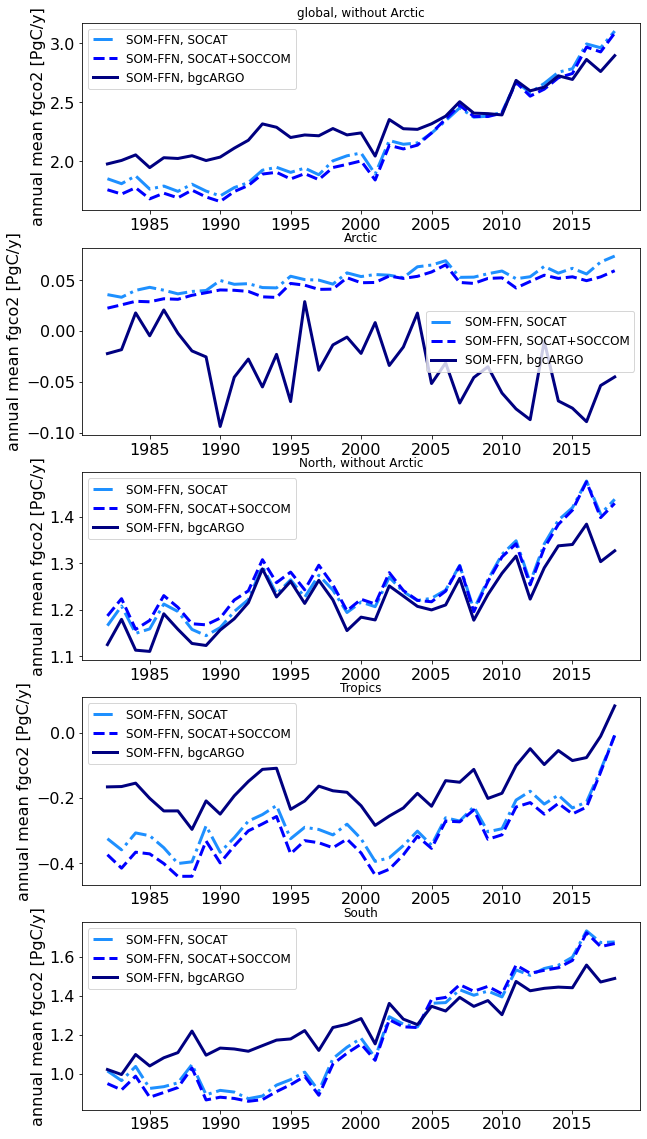

In [18]:
# plot: Landschützer CO2 flux

fig,ax = plt.subplots(5,1,figsize=(10,20))
#plt.figure(figsize=(8,8))

# global
ax1 = plt.subplot(5,1,1)
plt.plot(gcb_years,land_fgco2_PgCyr_A_glo_noArc,color='dodgerblue',linestyle='dashdot',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years,land_fgco2_PgCyr_B_glo_noArc,color='blue',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years,land_fgco2_PgCyr_C_glo_noArc,color='navy',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

plt.legend()
plt.title('global, without Arctic')
plt.ylabel('annual mean fgco2 [PgC/y]')

# N-Arc
ax1 = plt.subplot(5,1,2)
plt.plot(gcb_years,land_fgco2_PgCyr_A_Arc,color='dodgerblue',linestyle='dashdot',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years,land_fgco2_PgCyr_B_Arc,color='blue',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years,land_fgco2_PgCyr_C_Arc,color='navy',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

plt.legend()
plt.title('Arctic')
plt.ylabel('annual mean fgco2 [PgC/y]')

# N_noArc
ax1 = plt.subplot(5,1,3)
plt.plot(gcb_years,land_fgco2_PgCyr_A_N_noArc,color='dodgerblue',linestyle='dashdot',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years,land_fgco2_PgCyr_B_N_noArc,color='blue',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years,land_fgco2_PgCyr_C_N_noArc,color='navy',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

plt.legend()
plt.title('North, without Arctic')
plt.ylabel('annual mean fgco2 [PgC/y]')

# T
ax1 = plt.subplot(5,1,4)
plt.plot(gcb_years,land_fgco2_PgCyr_A_T,color='dodgerblue',linestyle='dashdot',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years,land_fgco2_PgCyr_B_T,color='blue',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years,land_fgco2_PgCyr_C_T,color='navy',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

plt.legend()
plt.title('Tropics')
plt.ylabel('annual mean fgco2 [PgC/y]')

# S
ax1 = plt.subplot(5,1,5)
plt.plot(gcb_years,land_fgco2_PgCyr_A_S,color='dodgerblue',linestyle='dashdot',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years,land_fgco2_PgCyr_B_S,color='blue',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years,land_fgco2_PgCyr_C_S,color='navy',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

plt.legend()
plt.title('South')
plt.ylabel('annual mean fgco2 [PgC/y]')

plt.savefig('subsampling_Lflux_gloNTS.png',dpi=300,facecolor='w',transparent=False)
plt.show()

In [19]:
print(np.shape(gcb_years),np.shape(roeden_fgco2_PgCyr_A_glo))

(63,) (63,)


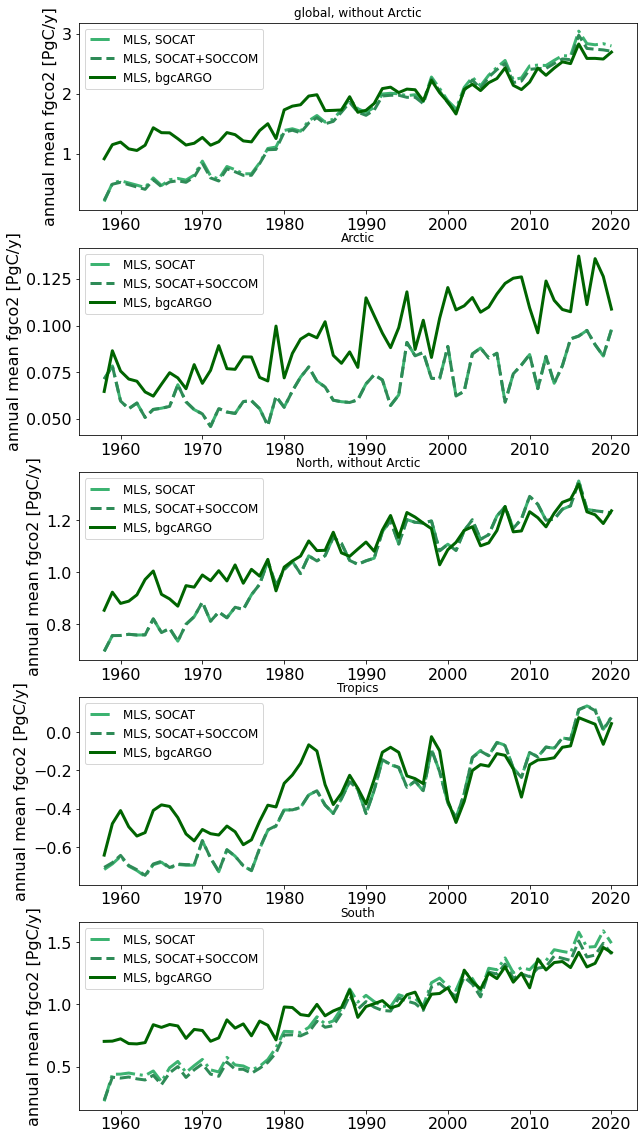

In [19]:
# plot: Rödenbeck
# here assuming the data came in Tmol/d, instead of Tmol/yr:

fig,ax = plt.subplots(5,1,figsize=(10,20))
#plt.figure(figsize=(8,8))

# global
ax1 = plt.subplot(5,1,1)
plt.plot(gcb_years,roeden_fgco2_PgCyr_A_glo_noArc,color='mediumseagreen',linewidth=3,linestyle='dashdot',label='MLS, SOCAT')
plt.plot(gcb_years,roeden_fgco2_PgCyr_B_glo_noArc,color='seagreen',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_fgco2_PgCyr_C_glo_noArc,color='darkgreen',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

plt.legend()
plt.title('global, without Arctic')
plt.ylabel('annual mean fgco2 [PgC/y]')

# N-Arc
ax1 = plt.subplot(5,1,2)
plt.plot(gcb_years,roeden_fgco2_PgCyr_A_Arc,color='mediumseagreen',linewidth=3,linestyle='dashdot',label='MLS, SOCAT')
plt.plot(gcb_years,roeden_fgco2_PgCyr_B_Arc,color='seagreen',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_fgco2_PgCyr_C_Arc,color='darkgreen',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

plt.legend()
plt.title('Arctic')
plt.ylabel('annual mean fgco2 [PgC/y]')

# N without Arctic
ax1 = plt.subplot(5,1,3)
plt.plot(gcb_years,roeden_fgco2_PgCyr_A_N_noArc,color='mediumseagreen',linewidth=3,linestyle='dashdot',label='MLS, SOCAT')
plt.plot(gcb_years,roeden_fgco2_PgCyr_B_N_noArc,color='seagreen',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_fgco2_PgCyr_C_N_noArc,color='darkgreen',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

plt.legend()
plt.title('North, without Arctic')
plt.ylabel('annual mean fgco2 [PgC/y]')

# T
ax1 = plt.subplot(5,1,4)
plt.plot(gcb_years,roeden_fgco2_PgCyr_A_T,color='mediumseagreen',linewidth=3,linestyle='dashdot',label='MLS, SOCAT')
plt.plot(gcb_years,roeden_fgco2_PgCyr_B_T,color='seagreen',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_fgco2_PgCyr_C_T,color='darkgreen',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

plt.legend()
plt.title('Tropics')
plt.ylabel('annual mean fgco2 [PgC/y]')

# S
ax1 = plt.subplot(5,1,5)
plt.plot(gcb_years,roeden_fgco2_PgCyr_A_S,color='mediumseagreen',linewidth=3,linestyle='dashdot',label='MLS, SOCAT')
plt.plot(gcb_years,roeden_fgco2_PgCyr_B_S,color='seagreen',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_fgco2_PgCyr_C_S,color='darkgreen',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

plt.legend()
plt.title('South')
plt.ylabel('annual mean fgco2 [PgC/y]')

plt.savefig('subsampling_Rflux_FESOMprior_gloNTS.png',dpi=300,facecolor='w',transparent=False)
plt.show()

[0.96770561 1.25058837 1.27311613 1.13532327 1.08198878 1.18142414
 1.47824954 1.38144235 1.39144186 1.27060581 1.14398605 1.21577289
 1.27562041 1.1891878  1.28510892 1.39192482 1.37601489 1.22804509
 1.21964372 1.39032311 1.53789461 1.27208932 1.76955498 1.80775627
 1.86081705 2.03494987 2.02051727 1.73869375 1.75836318 1.7522121
 1.98802134 1.7529628  1.80699431 1.94238364 2.16275064 2.19991826
 2.08259171 2.10131625 2.09333394 1.93550248 2.26504206 2.14367893
 1.95060537 1.696257   2.1921021  2.22627987 2.14891837 2.28548899
 2.35045267 2.46351463 2.19304439 2.1326243  2.24007792 2.51426946
 2.36161079 2.49876414 2.61885225 2.55684282 2.90710819 2.6710983
 2.71217935 2.67674127]
0.5 1339200.0 (744, 180, 360)


/work/ollie/jhauck/gcp2018/py_recom/GCB/code/2021/subsampling/integrate_CO2flux.py:27: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmap.set_bad('white',1.)


shape(reg_arcT) (744, 180, 360)
region global
shape(mask) (744, 180, 360)


/work/ollie/jhauck/gcp2018/py_recom/GCB/code/2021/subsampling/integrate_CO2flux.py:116: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(reg_lon,reg_lat,np.squeeze(mask[1,:,:]))#, vmin=-60, vmax=750)


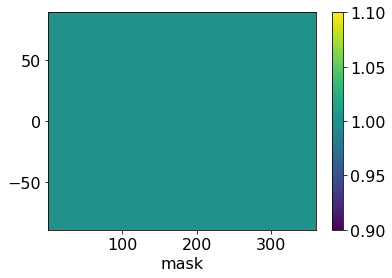

global
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
True
True
True
0 [1.1517664135668626 0.42674757364274535 0.46731912140906906
 0.9428513322646028 0.836355901496132 0.8708198152772764 0.981964205616793
 0.8564398485122265 0.5346966187672877 1.2643516993656065
 1.418989030182731 1.7236604812083205]
1 [1.228196975255577 0.8669653653641294 0.8914035065750471
 1.0200530109268888 1.1026784105916907 1.358247340663057 1.207156853817049
 1.041742028560982 0.7553453836271269 1.2544592613300536 2.129333965717803
 2.033304051449437]
2 [1.4303484651391223 0.8890233652381612 0.8279276351819035
 1.1152739818853428 1.3706166662674106 1.3113327163085422
 1.4366874800261011 0.782683280324746 0.9683316637022037
 1.1321055178170036 1.8242135869824825 2.013952164660032]
3 [1.32386481013642 0.848956637947975 0.7080952729820587 0.9245231207425848
 1.0638644830256183 1.1464202008131619 1.0887116859100132
 0.8422944751010871 0.6912126024888823 1.3163679398939319
 1.7193211129107615 1.842371953300534

shape(reg_arcT) (744, 180, 360)
region glo_noArc
shape(mask) (744, 180, 360)


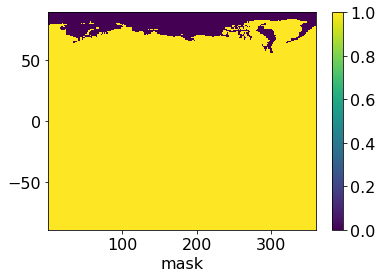

glo_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [1.1110681706818006 0.3851528683931458 0.43381254735149855
 0.9237480941549024 0.8081006307366104 0.8661289821323443
 0.9485569298406067 0.7966295357693309 0.47816234886888176
 1.21007871834028 1.3646631544733796 1.6770274872779283]
1 [1.186500959983193 0.8202403754905677 0.8529427386469347 1.00408139114648
 1.0887221357062815 1.3491900986360543 1.1462036862000609
 0.9534458254788024 0.6566636207516476 1.1892749678582306
 2.065762577263378 1.9776837236443972]
2 [1.3852032194481108 0.8454943856885561 0.7882594998146011
 1.086519897408194 1.3537424288067923 1.3140727294030001
 1.3965597328085244 0.6948427152773933 0.8920918481704458
 1.0586653062029325 1.775716494638024 1.9612406962822857]
3 [1.281465953422494 0.8153660251757227 0.7028569900847905
 0.9214552183412602 1.0537776382387618 1.1326453867340212
 1.051587267293727 0.7818600806447114 0.619261425277753 1.2650653460417567
 1.6499439613351983 1.7898110

shape(reg_arcT) (744, 180, 360)
region N
shape(mask) (744, 180, 360)


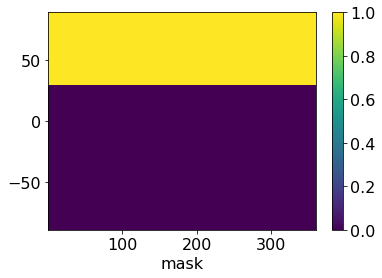

N
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [2.0260526069127303 1.8683973396574722 1.74831389078858 1.6612302542201576
 1.1510823685677578 0.4441752166383387 -0.1537512261609383
 -0.46419569494383195 -0.3866099416061635 0.28558666215324235
 0.9413516606059714 1.6496221285465282]
1 [1.9671898835092798 1.9666022012870548 2.0019470780159394
 1.6864164129964274 1.1412959345970675 0.6123624487318983
 -0.034796173053690434 -0.38987782118463676 -0.3081264094677766
 0.3963628139776841 1.2604554340171696 1.7954555556490706]
2 [1.846606130564416 1.9015352778925931 1.8106253220060091
 1.6191783192132199 1.2441384251771537 0.5523114314585127
 -0.09570729114680819 -0.455178688273305 -0.2811961327269132
 0.24636331511413928 1.1310047044767133 1.7641817047010184]
3 [1.9751311596565966 2.0032076480458545 1.8527276456252135
 1.638859682653455 1.2255548433808725 0.4933747046172444
 -0.15270286511292447 -0.4455221474897027 -0.2980229276208333
 0.2977512092357559 1.0492242849

shape(reg_arcT) (744, 180, 360)
region N_noArc
shape(mask) (744, 180, 360)


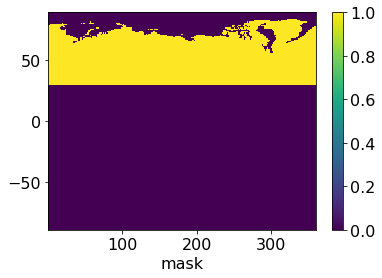

N_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [1.9853543640276679 1.8268026344078725 1.7148073167310094
 1.6421270161104573 1.1228270978082362 0.43948438349340674
 -0.18715850193712474 -0.5240060076867273 -0.44314421150456956
 0.23131368112791545 0.8870257848966195 1.602989134616136]
1 [1.9254938682368954 1.9198772114134928 1.963486310087827
 1.6704447932160182 1.127339659711658 0.6033052067048955
 -0.09574934067067839 -0.4781740242668162 -0.4068081723432557
 0.33117852050586105 1.1968840455627443 1.7398352278440314]
2 [1.8014608848734046 1.8580062983429877 1.770957186638707 1.590424234736071
 1.2272641877165353 0.5550514445529703 -0.13583503836438485
 -0.5430192533206577 -0.3574359482586712 0.1729231035000682
 1.0825076121322543 1.7114702363232726]
3 [1.93273230294267 1.9696170352736024 1.8474893627279454 1.6357917802521302
 1.2154679985940158 0.47959989053810365 -0.18982728372921076
 -0.5059565419460782 -0.3699741048319623 0.24644861538358057
 0.9798

shape(reg_arcT) (744, 180, 360)
region Arc
shape(mask) (744, 180, 360)


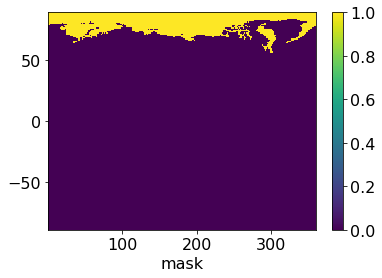

Arc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [0.04069824288506197 0.04159470524959958 0.03350657405757004
 0.019103238109700278 0.02825527075952152 0.004690833144931866
 0.03340727577618642 0.059810312742895486 0.05653426989840599
 0.054272981025326815 0.05432587570935144 0.0466329939303923]
1 [0.04169601527238447 0.04672498987356201 0.03846076792811241
 0.015971619780409285 0.013956274885409488 0.009057242027002836
 0.060953167616987956 0.08829620308217938 0.0986817628754791
 0.06518429347182303 0.06357138845442509 0.05562032780503889]
2 [0.045145245691011485 0.04352897954960523 0.03966813536730167
 0.028754084477148698 0.01687423746061842 -0.0027400130944576565
 0.040127747217576636 0.08784056504735267 0.07623981553175795
 0.07344021161407109 0.04849709234445896 0.052711468377746026]
3 [0.04239885671392655 0.03359061277225269 0.005238282897267879
 0.0030679024013248652 0.010086844786856525 0.013774814079140732
 0.03712441861628624 0.06043439445637563 0.

shape(reg_arcT) (744, 180, 360)
region T
shape(mask) (744, 180, 360)


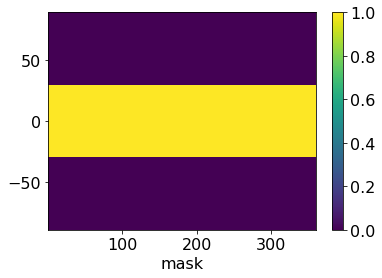

T
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-0.68433865761883 -0.8621722894991228 -0.7611195461428245
 -0.7743732544621936 -0.9098999204938081 -0.7773869465267351
 -0.4241677820987854 -0.2941488008524335 -0.4056010121413015
 -0.44841624685721354 -0.6027310469758627 -0.5580977897952643]
1 [-0.6006330787412201 -0.5138458029971474 -0.6029495591330136
 -0.6698944283526763 -0.6227218277322502 -0.37240961447191
 -0.2540878777631318 -0.17230930118209523 -0.2549252230651255
 -0.48334766615355385 -0.425786706035722 -0.47625442077662267]
2 [-0.377193976835936 -0.4342191254692499 -0.4790777805091006
 -0.4828135984070867 -0.5800173845622209 -0.4054396023565687
 -0.1202247917980598 -0.16521700054422114 -0.18154962157955912
 -0.38863138265115904 -0.4930209514984904 -0.4269657911196719]
3 [-0.4579588614615245 -0.5477573113665618 -0.6066264143741663
 -0.5774776196291034 -0.6165979092465288 -0.5346129849671528
 -0.25589649095136824 -0.2097668858029879 -0.4184509073334369


shape(reg_arcT) (744, 180, 360)
region S
shape(mask) (744, 180, 360)


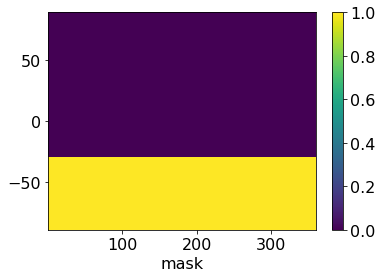

S
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-0.18994753572703713 -0.5794774765156034 -0.5198752232366864
 0.05599433250663867 0.5951734534221823 1.204031545165673
 1.5598832138765168 1.6147843443084917 1.3269075725147528
 1.4271812840695781 1.0803684165526226 0.6321361424570563]
1 [-0.13835982951248255 -0.5857910329257778 -0.5075940123078788
 0.003531026283138055 0.5841043037268734 1.1182945064030687
 1.4960409046338714 1.6039291509277136 1.3183970161600291
 1.341444113505923 1.2946652377363554 0.7141029165769889]
2 [-0.03906368858935761 -0.5782927871851818 -0.5036199063150052
 -0.02109073892079002 0.7064956256524778 1.1644608872065982
 1.6526195629709686 1.403078969142272 1.4310774180086763
 1.2743735853540232 1.18622983400426 0.6767362510786853]
3 [-0.19330748805865194 -0.6064936987313179 -0.5380059582689881
 -0.13685894228176693 0.4549075488912748 1.1876584811630706
 1.4973110419743059 1.4975835083937774 1.4076864374431524
 1.3839694405117298 1.1657002

(1, 120, 180, 360)
(180, 360)


<ipython-input-20-4ab31adaca09>:61: RuntimeWarning: Mean of empty slice
  fesom_fgco2_2009_2018 = np.nanmean(np.squeeze(fesom_fgco2_gridded[ind_2009_2018_monthly,:,:]),axis=0) # maybe double-check lengths of time-series,


In [20]:
# load model data, compare
# co2 flux

fesom= np.load('/work/ollie/jhauck/subsampling/fesom/fesom_reccap_A_1958_2019_fgco2_int.npz') 
co2flux_glo = fesom['co2flux']
co2flux_N = fesom['co2fluxN']
co2flux_T = fesom['co2fluxT']
co2flux_S = fesom['co2fluxS']

print(co2flux_glo)

#------------------------
# also gridded field:
# fgco2

in_data = Dataset('/work/ollie/jhauck/subsampling/fesom/fgco2_fesom_A_reg_1958_2019.nc',mode='r')

# mol/m2/s convert to mol/m2/yr later!! here keepin per s
fesom_fgco2_grid = in_data['fgco2'][:]

fesom_lon = in_data['Lon'][:]
fesom_lat = in_data['Lat'][:]
fesom_time = in_data['Time'][:]

# check whether it starts at 0 deg:
print(min(fesom_lon),min(fesom_time),np.shape(fesom_fgco2_grid))

# fill to have same length as Rö and filled Landschützer
#fesom_fgco2_1x1a = np.nan * np.zeros((tsteps,180,360))
#fesom_fgco2_1x1a[0:744,:,:] = fesom_fgco2_grid   # per s for integration routine
#fesom_fgco2_1x1 = np.ma.array(fesom_fgco2_1x1a, mask=np.isnan(fesom_fgco2_1x1a))
#print(np.shape(fesom_fgco2_1x1))

    


# calculate fesom for regions from gridded fields as well - incl Arc and N60
# routine assumes units mol/m2/s
fesom_fgco2_PgCyr_glo= integrate_CO2flux(fesom_fgco2_grid,'global',areaT[0:744,:,:],xax,yax)
fesom_fgco2_PgCyr_glo_noArc= integrate_CO2flux(fesom_fgco2_grid,'glo_noArc',areaT[0:744,:,:],xax,yax)
fesom_fgco2_PgCyr_N= integrate_CO2flux(fesom_fgco2_grid,'N',areaT[0:744,:,:],xax,yax)
fesom_fgco2_PgCyr_N_noArc= integrate_CO2flux(fesom_fgco2_grid,'N_noArc',areaT[0:744,:,:],xax,yax)
fesom_fgco2_PgCyr_Arc= integrate_CO2flux(fesom_fgco2_grid,'Arc',areaT[0:744,:,:],xax,yax)
fesom_fgco2_PgCyr_T= integrate_CO2flux(fesom_fgco2_grid,'T',areaT[0:744,:,:],xax,yax)
fesom_fgco2_PgCyr_S= integrate_CO2flux(fesom_fgco2_grid,'S',areaT[0:744,:,:],xax,yax)

print(fesom_fgco2_PgCyr_glo)

# fesom_fgco2_PgCyr_glo[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# fesom_fgco2_PgCyr_N[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# fesom_fgco2_PgCyr_N60[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# fesom_fgco2_PgCyr_Arc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# fesom_fgco2_PgCyr_T[(gcb_years<1982) | (gcb_years>2018) ]=np.nan
# fesom_fgco2_PgCyr_S[(gcb_years<1982) | (gcb_years>2018)]=np.nan


fesom_fgco2_gridded = fesom_fgco2_grid*365.25*86400

# average over last ten years (for maps plotting)
print(np.shape(fesom_fgco2_gridded[ind_2009_2018_monthly,:,:]))
fesom_fgco2_2009_2018 = np.nanmean(np.squeeze(fesom_fgco2_gridded[ind_2009_2018_monthly,:,:]),axis=0) # maybe double-check lengths of time-series, 
# but this should be 2009-2018

print(np.shape(fesom_fgco2_2009_2018))

# np.save('fesom_fgco2_1x1_A_subsampling.npy',fesom_fgco2_PgCyr_glo_noArc=fesom_fgco2_PgCyr_glo_noArc,
#        fesom_fgco2_PgCyr_N_noArc=fesom_fgco2_PgCyr_N_noArc,
#        fesom_fgco2_PgCyr_T=fesom_fgco2_PgCyr_T,
#        fesom_fgco2_PgCyr_S=fesom_fgco2_PgCyr_S)


In [21]:
np.save('fesom_fgco2_1x1_glonoArc_subsampling.npy',fesom_fgco2_PgCyr_glo_noArc)
np.save('fesom_fgco2_1x1_NnoArc_subsampling.npy',fesom_fgco2_PgCyr_N_noArc)
np.save('fesom_fgco2_1x1_T_subsampling.npy',fesom_fgco2_PgCyr_T)
np.save('fesom_fgco2_1x1_S_subsampling.npy',fesom_fgco2_PgCyr_S)


#=fesom_fgco2_PgCyr_glo_noArc,
#        fesom_fgco2_PgCyr_N_noArc=fesom_fgco2_PgCyr_N_noArc,
#        fesom_fgco2_PgCyr_T=fesom_fgco2_PgCyr_T,
#        fesom_fgco2_PgCyr_S=fesom_fgco2_PgCyr_S)

In [22]:
# uses spCO2 which is only loaded in the next cell

# plt.figure()
# #plt.subplot(2,2,3)
# plt.pcolor(np.squeeze(land_spco2_1x1_A[ind1,:,:]))#, vmin=-60, vmax=750)
# plt.colorbar()
# plt.xlabel('spco2, land')
# plt.show()

# plt.figure()
# #plt.subplot(2,2,3)
# plt.pcolor(np.squeeze(fesom_spco2_gridded[ind1,:,:]), vmin=-60, vmax=750)
# plt.colorbar()
# plt.xlabel('spco2, fesom')
# plt.show()

# print(type(fesom_spco2_gridded))
# fesom_spco2_gridded_nd = fesom_spco2_gridded.data
# print(type(fesom_spco2_gridded_nd))

# print(np.shape(fesom_spco2_gridded))
# print(np.shape(land_spco2_1x1_A))

# print(np.nanmin(fesom_spco2_gridded))
# print(np.min(land_spco2_1x1_A))

0.5 1339200.0 (744, 180, 360)
global
shape reg_arcT (744, 180, 360)
shape intYY (744, 180, 360)
<class 'numpy.ndarray'>
global, just return from if loop


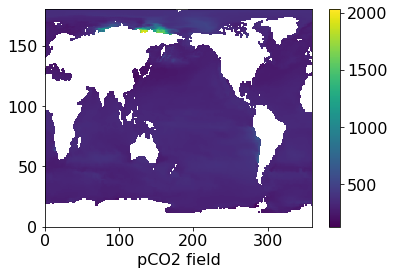

0 [304.367001911194 312.9504691242416 312.90249711619146 310.7781533179911
 313.2223925740311 319.1747134997625 325.53843485042165 332.63941361309844
 338.97935742609707 334.6282460929455 318.4732820349826 300.150528042138]
1 [304.71082803716996 312.6814795768301 312.23803515448594
 312.10506083325623 316.1570487526432 321.3711782900467 327.8068819774208
 331.03381453621165 337.8395764392834 336.2989587674926 320.13942765355773
 300.6650419094889]
2 [304.9066137740904 314.0647445779453 313.0337571517328 312.566013891415
 316.20318648865174 324.1376855025985 329.157273937175 333.2990356331167
 339.43668133348234 338.16656261259885 320.99514402022896
 302.08547882736354]
3 [307.8756714808405 314.32170734737053 312.72525652240694
 311.67133232468245 316.55987839618854 322.38983275949647
 327.64057790006376 332.3993110496313 337.8345845164831 336.68002861503254
 318.6191138606115 300.66435835740367]
4 [304.86596531311926 312.5586852784751 313.40092977778994
 314.11373619336746 318.98867418

<class 'numpy.ndarray'>
global no Arc, apply some mask


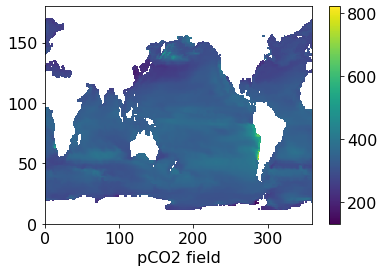

0 [300.5467941414559 309.68373278240557 309.5516189794181 307.20030195154686
 309.76859546575537 316.17769165935465 323.4715179588612 332.244677244616
 338.73437381705804 333.4503094015751 315.6696972720569 295.7776736454857]
1 [300.54845523910774 309.0136192489999 308.44040187192405 308.2196078576496
 312.53601696779987 318.29998773178926 326.829642003228 332.58109728879344
 339.00371305593654 335.71987171309854 317.5225412709618
 296.21199334157336]
2 [300.5602901504463 310.29313915170565 309.07931703973554
 308.50192853621223 312.37373913623173 321.23854130027416 329.162938167165
 335.63686082402694 340.8209561060759 337.7061605223305 318.4984774381637
 297.76236844660343]
3 [303.78337842455187 310.5914954739593 308.797468554778 307.69547523510954
 312.9407078105306 319.37289515485173 326.50747140760797 334.81839533119
 339.21019824370245 336.2272873935436 316.0556529357304 296.34213869911133]
4 [300.7133694583332 308.8891046488642 309.7066983454891 310.42210194288475
 315.602123963

<class 'numpy.ndarray'>
N_noArc, apply some mask


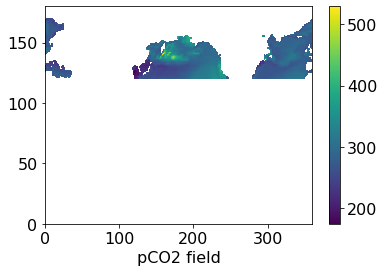

0 [270.43700821471515 269.08580430458403 267.6821809972629 264.4109433013255
 263.2242655069594 279.29414422363817 307.44226990920333
 322.35278049982446 316.03465497034836 296.69922038967417
 282.2140349391415 274.2127865049255]
1 [270.5123571458516 269.0889824267869 267.72324820707524 264.00925017395485
 262.4366063925184 276.9702823519797 303.5366201044982 321.8694488376248
 314.2324993814721 295.6457181003804 281.04605914105184 273.7318177410974]
2 [273.0077188222563 271.5757430760866 269.423894356388 265.9689599598923
 263.2029629406788 278.8719669243803 308.87241145742655 326.9399959435129
 317.97911261351817 297.8281763165146 280.9544297367267 273.43397375654297]
3 [271.2097880320903 270.217640270397 268.75204297477075 265.5321885692656
 263.67492669966083 280.53383352257623 309.2110173163421
 327.03939522043015 316.14061739335574 299.25020568866313
 283.7941766542807 275.4255320430717]
4 [272.11525794030655 270.6907357976352 269.0850688644114 264.89409368878705
 262.83480873520

<class 'numpy.ndarray'>
Arc, apply some mask


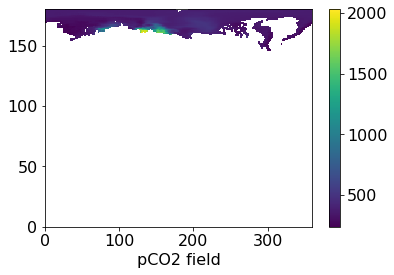

0 [355.47833906384466 356.6567994131425 357.7345776021738 358.6469548321407
 359.4314469234592 359.2724785879283 353.1921365542679 337.9206718147437
 342.25704298489256 350.3881007935279 355.98301309962454
 358.65583687827785]
1 [360.40006073337173 361.75452930192836 363.0473436493632 364.0893268724348
 364.6035698716461 362.4612617474434 340.88157445767763 310.33240372181706
 322.264355746618 344.0466823107855 355.1512830951825 360.24328488224296]
2 [363.0569619992171 364.5258210864934 365.94101612736586 366.94023888838734
 367.43814189823246 362.92592575302655 329.0814910514836 302.0207966632067
 320.9161874550061 344.3263758688037 354.39855428616903 359.9252523521179]
3 [362.6272930508257 364.2289710891573 365.2759310349012 364.86513340159405
 364.9814981525408 362.7540549101884 342.8006402465512 300.0338901699439
 319.429968526567 342.7373455488736 352.91617923154246 358.49221472500136]
4 [360.4243902956497 361.65475127117315 362.82680387604483
 363.50486206755767 364.2980187451144

<class 'numpy.ndarray'>
T, apply some mask


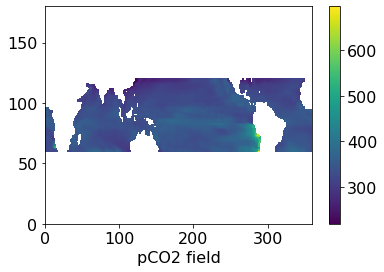

0 [318.4508924086528 320.17297173641583 322.004085730271 323.0145394967508
 321.5968570229111 318.86151615420584 315.5564940130926 314.98347661028555
 314.89248799378674 315.4545030222992 315.8097027286169 317.0363269054358]
1 [316.98549161791624 318.01009613617316 319.5487039592236
 319.28420662915886 318.73564135560406 317.08359812373794
 315.0942975160323 313.7233365734409 314.2674882204677 315.15120210335357
 315.84549839913825 316.1249932771538]
2 [317.1580148454104 317.9164032962949 319.68215834907045 320.1254824721149
 320.0029767808848 317.3786868874732 315.1587738172728 313.56959084949557
 314.03740903313485 315.5002981124548 316.23828665321014
 316.84120278289026]
3 [317.3713830546549 318.95185739541506 320.0940791776697 320.98820904489827
 320.32895884588277 317.93754718449827 315.7195930601299 314.9727333113202
 315.03084676212916 316.42201712816046 317.2262290987089
 317.97593373680263]
4 [318.61696981014114 319.13187802288917 322.32447078764085
 323.55892431346723 323.094

<class 'numpy.ndarray'>
S, apply some mask


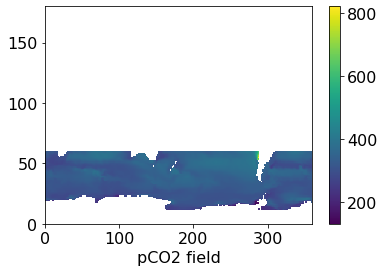

0 [300.5467941414559 309.68373278240557 309.5516189794181 307.20030195154686
 309.76859546575537 316.17769165935465 323.4715179588612 332.244677244616
 338.73437381705804 333.4503094015751 315.6696972720569 295.7776736454857]
1 [300.54845523910774 309.0136192489999 308.44040187192405 308.2196078576496
 312.53601696779987 318.29998773178926 326.829642003228 332.58109728879344
 339.00371305593654 335.71987171309854 317.5225412709618
 296.21199334157336]
2 [300.5602901504463 310.29313915170565 309.07931703973554
 308.50192853621223 312.37373913623173 321.23854130027416 329.162938167165
 335.63686082402694 340.8209561060759 337.7061605223305 318.4984774381637
 297.76236844660343]
3 [303.78337842455187 310.5914954739593 308.797468554778 307.69547523510954
 312.9407078105306 319.37289515485173 326.50747140760797 334.81839533119
 339.21019824370245 336.2272873935436 316.0556529357304 296.34213869911133]
4 [300.7133694583332 308.8891046488642 309.7066983454891 310.42210194288475
 315.602123963

(180, 360)


<ipython-input-23-87a1668ea4db>:51: RuntimeWarning: Mean of empty slice
  fesom_spco2_2009_2018 = np.nanmean(np.squeeze(fesom_spco2_gridded[ind_2009_2018_monthly,:,:]),axis=0) # maybe double-check lengths of time-series,


In [23]:
# fesom
#---------------------------
# now spco2

in_data = Dataset('/work/ollie/jhauck/subsampling/fesom/spco2_fesom_A_reg_1958_2019.nc',mode='r')

# mol/m2/s convert to mol/m2/yr
fesom_spco2_gridded = in_data['spco2'][:]

fesom_lon = in_data['Lon'][:]
fesom_lat = in_data['Lat'][:]
fesom_time = in_data['Time'][:]

# check whether it starts at 0 deg:
print(min(fesom_lon),min(fesom_time),np.shape(fesom_spco2_gridded))

# again trouble with negative numbers (ha, no data types trouble this time)
ftest = np.copy(fesom_spco2_gridded.data)
ftest[ftest<0]=np.nan

# # fill to have same length as Rö and filled Landschützer
# fesom_spco2_1x1 = np.nan * np.zeros((tsteps,180,360))
# fesom_spco2_1x1[0:744,:,:] = fesom_spco2_gridded
# print(np.shape(fesom_spco2_1x1))

# calc regional averages from gridded fields

for reg in regions:
        print(reg)
        exec('fesom_spco2_'+reg+'_ts, fesom_spco2_'+reg+'_am = reg_ave_pCO2(ftest,"'+reg+'",fareaT,fYY,freg_arcT)')
#        exec('fesom_spco2_'+reg+'_ts, fesom_spco2_'+reg+'_am = reg_ave_pCO2(fesom_spco2_gridded.data,"'+reg+'",fareaT,fYY)')
#        exec('fesom_spco2_'+reg+'_am[(gcb_years[:-1]>2018)]=np.nan')  # only later than 2018 for roedenbeck, (gcb_years<1982) | 


# fesom_spco2_glo= reg_ave_pCO2(fesom_spco2_gridded,'global',areaT[0:744,:,:],xax,yax)
# fesom_spco2_N= reg_ave_pCO2(fesom_spco2_gridded,'N',areaT[0:744,:,:],xax,yax)
# fesom_spco2_N60= reg_ave_pCO2(fesom_spco2_gridded,'N60',areaT[0:744,:,:],xax,yax)
# fesom_spco2_Arc= reg_ave_pCO2(fesom_spco2_gridded,'Arc',areaT[0:744,:,:],xax,yax)
# fesom_spco2_T= reg_ave_pCO2(fesom_spco2_gridded,'T',areaT[0:744,:,:],xax,yax)
# fesom_spco2_S= reg_ave_pCO2(fesom_spco2_gridded,'S',areaT[0:744,:,:],xax,yax)

print(fesom_spco2_global_am)
# fesom_spco2_glo[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# fesom_spco2_N[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# fesom_spco2_N60[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# fesom_spco2_Arc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
# fesom_spco2_T[(gcb_years<1982) | (gcb_years>2018) ]=np.nan
# fesom_spco2_S[(gcb_years<1982) | (gcb_years>2018)]=np.nan

# average over last ten years (for maps plotting)
fesom_spco2_2009_2018 = np.nanmean(np.squeeze(fesom_spco2_gridded[ind_2009_2018_monthly,:,:]),axis=0) # maybe double-check lengths of time-series, 
# but this should be 2009-2018

print(np.shape(fesom_spco2_2009_2018))

In [24]:
# print(np.shape(fesom_fgco2_gridded))


# plt.figure()
# #plt.subplot(2,2,3)
# plt.pcolor(np.squeeze(fesom_fgco2_gridded[ind1,:,:]))#, vmin=-60, vmax=750)
# plt.colorbar()
# plt.xlabel('fgco2, fesom gridded')
# plt.show()


# plt.figure()
# #plt.subplot(2,2,3)
# plt.pcolor(np.squeeze(fesom_fgco2_grid[ind1,:,:]))#, vmin=-60, vmax=750)
# plt.colorbar()
# plt.xlabel('fgco2, fesom grid')
# plt.show()


# plt.figure()
# #plt.subplot(2,2,3)
# plt.pcolor(np.squeeze(fesom_fgco2_1x1a[ind1,:,:]))#, vmin=-60, vmax=750)
# plt.colorbar()
# plt.xlabel('fgco2, fesom 1x1')
# plt.show()

In [25]:
print(np.shape(co2flux_glo))

(62,)


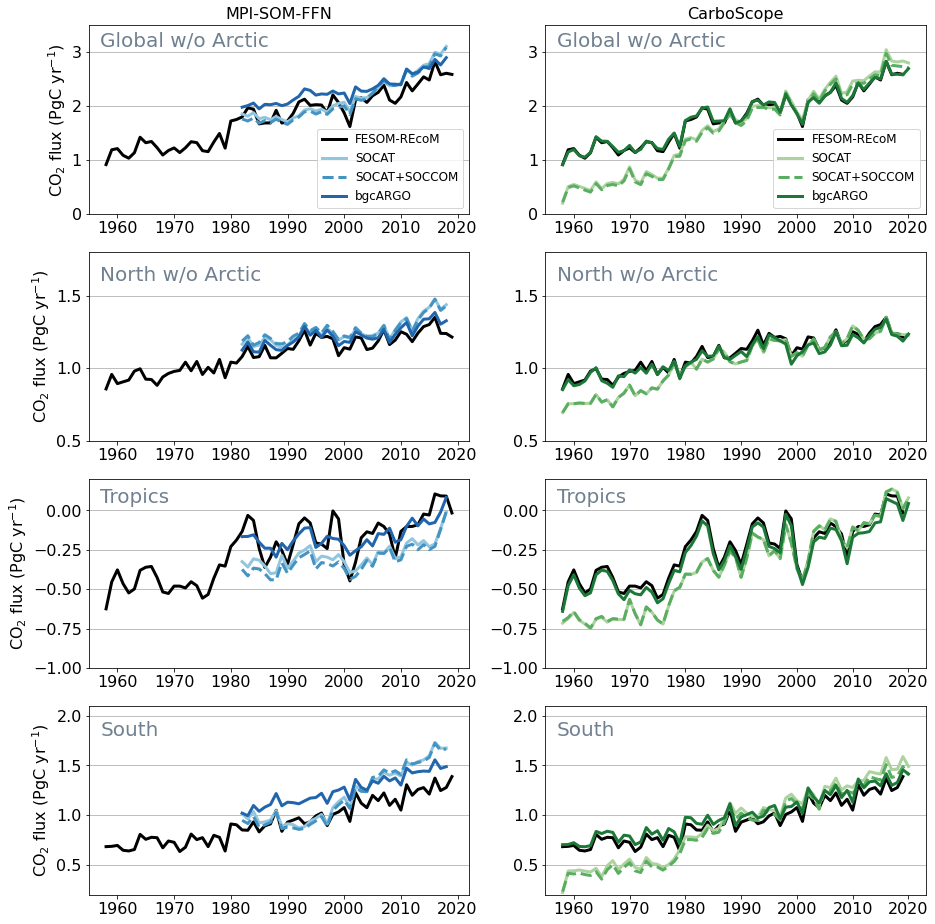

In [27]:
# now plot both products together with the known truth:


fig,ax = plt.subplots(4,2,figsize=(15,16))
#plt.figure(figsize=(8,8))

# left: Landschützer

# global
ax1 = plt.subplot(4,2,1)
plt.plot(gcb_years[:-1],fesom_fgco2_PgCyr_glo_noArc,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM')

plt.plot(gcb_years,land_fgco2_PgCyr_A_glo_noArc,color='#92C5DE',linestyle='solid',linewidth='3',label='SOCAT')
plt.plot(gcb_years,land_fgco2_PgCyr_B_glo_noArc,color='#4393C3',linestyle='dashed',linewidth='3',label='SOCAT+SOCCOM')
plt.plot(gcb_years,land_fgco2_PgCyr_C_glo_noArc,color='#2166AC',linestyle='solid',linewidth='3',label='bgcARGO')

plt.legend(loc=4)
plt.title('MPI-SOM-FFN', fontsize=16)#Global without Arctic')
plt.text(1957,3.1,'Global w/o Arctic',fontsize=20,color='slategrey')

plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(0,3.5) 
plt.grid(b=None, which='major', axis='y')

# # N-Arc
# ax1 = plt.subplot(5,2,3)
# plt.plot(gcb_years[:-1],fesom_fgco2_PgCyr_Arc,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

# plt.plot(gcb_years,land_fgco2_PgCyr_A_Arc,color='#92C5DE',linestyle='solid',linewidth='3',label='SOM-FFN, SOCAT')
# plt.plot(gcb_years,land_fgco2_PgCyr_B_Arc,color='#4393C3',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
# plt.plot(gcb_years,land_fgco2_PgCyr_C_Arc,color='#2166AC',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

# #plt.legend()
# plt.title('Arctic')
# plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
# plt.ylim(-0.15,0.2) 
# plt.grid(b=None, which='major', axis='y')

# N-60
ax1 = plt.subplot(4,2,3)
plt.plot(gcb_years[:-1],fesom_fgco2_PgCyr_N_noArc,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years,land_fgco2_PgCyr_A_N_noArc,color='#92C5DE',linestyle='solid',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years,land_fgco2_PgCyr_B_N_noArc,color='#4393C3',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years,land_fgco2_PgCyr_C_N_noArc,color='#2166AC',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

#plt.legend()
#plt.title('North without Arctic')
plt.text(1957,1.6,'North w/o Arctic',fontsize=20,color='slategrey')
plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(0.5,1.8) 
plt.grid(b=None, which='major', axis='y')

# T
ax1 = plt.subplot(4,2,5)
plt.plot(gcb_years[:-1],fesom_fgco2_PgCyr_T,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years,land_fgco2_PgCyr_A_T,color='#92C5DE',linestyle='solid',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years,land_fgco2_PgCyr_B_T,color='#4393C3',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years,land_fgco2_PgCyr_C_T,color='#2166AC',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

#plt.legend()
#plt.title('Tropics')
plt.text(1957,0.05,'Tropics',fontsize=20,color='slategrey')
plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(-1.0,0.2) 
plt.grid(b=None, which='major', axis='y')

# S
ax1 = plt.subplot(4,2,7)
plt.plot(gcb_years[:-1],fesom_fgco2_PgCyr_S,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM')

plt.plot(gcb_years,land_fgco2_PgCyr_A_S,color='#92C5DE',linestyle='solid',linewidth='3',label='SSOCAT')
plt.plot(gcb_years,land_fgco2_PgCyr_B_S,color='#4393C3',linestyle='dashed',linewidth='3',label='SOCAT+SOCCOM')
plt.plot(gcb_years,land_fgco2_PgCyr_C_S,color='#2166AC',linestyle='solid',linewidth='3',label='bgcARGO')

#plt.title('South')
plt.text(1957,1.8,'South',fontsize=20,color='slategrey')

#plt.legend()
plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(0.2,2.1) 
plt.grid(b=None, which='major', axis='y')

#------------------------------------------------------------
# right: Rödenbeck

# global
ax1 = plt.subplot(4,2,2)
plt.plot(gcb_years[:-1],fesom_fgco2_PgCyr_glo_noArc,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM')

plt.plot(gcb_years,roeden_fgco2_PgCyr_A_glo_noArc,color='#ACD39E',linewidth=3,linestyle='solid',label='SOCAT')
plt.plot(gcb_years,roeden_fgco2_PgCyr_B_glo_noArc,color='#5AAE61',linewidth=3,linestyle='dashed',label='SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_fgco2_PgCyr_C_glo_noArc,color='#1B7837',linewidth=3,linestyle='solid',label='bgcARGO')

plt.legend(loc=4)
plt.title('CarboScope',fontsize=16)# global without Arctic')
#plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(0,3.5) 
plt.grid(b=None, which='major', axis='y')
plt.text(1957,3.1,'Global w/o Arctic',fontsize=20,color='slategrey')

# # Arc
# ax1 = plt.subplot(5,2,4)
# plt.plot(gcb_years[:-1],fesom_fgco2_PgCyr_Arc,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

# plt.plot(gcb_years,roeden_fgco2_PgCyr_A_Arc,color='#ACD39E',linewidth=3,linestyle='solid',label='MLS, SOCAT')
# plt.plot(gcb_years,roeden_fgco2_PgCyr_B_Arc,color='#5AAE61',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
# plt.plot(gcb_years,roeden_fgco2_PgCyr_C_Arc,color='#1B7837',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

# #plt.legend()
# plt.title('Arctic')
# plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
# plt.ylim(-0.15,0.2) 
# plt.grid(b=None, which='major', axis='y')

# N-60
ax1 = plt.subplot(4,2,4)
plt.plot(gcb_years[:-1],fesom_fgco2_PgCyr_N_noArc,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years,roeden_fgco2_PgCyr_A_N_noArc,color='#ACD39E',linewidth=3,linestyle='solid',label='MLS, SOCAT')
plt.plot(gcb_years,roeden_fgco2_PgCyr_B_N_noArc,color='#5AAE61',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_fgco2_PgCyr_C_N_noArc,color='#1B7837',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

#plt.legend()
#plt.title('North without Arctic')
plt.text(1957,1.6,'North w/o Arctic',fontsize=20,color='slategrey')
#plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(0.5,1.8) 
plt.grid(b=None, which='major', axis='y')

# T
ax1 = plt.subplot(4,2,6)
plt.plot(gcb_years[:-1],fesom_fgco2_PgCyr_T,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years,roeden_fgco2_PgCyr_A_T,color='#ACD39E',linewidth=3,linestyle='solid',label='MLS, SOCAT')
plt.plot(gcb_years,roeden_fgco2_PgCyr_B_T,color='#5AAE61',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_fgco2_PgCyr_C_T,color='#1B7837',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

#plt.legend()
#plt.title('Tropics')
plt.text(1957,0.05,'Tropics',fontsize=20,color='slategrey')

#plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(-1.0,0.2) 
plt.grid(b=None, which='major', axis='y')

# S
ax1 = plt.subplot(4,2,8)
plt.plot(gcb_years[:-1],fesom_fgco2_PgCyr_S,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM')

plt.plot(gcb_years,roeden_fgco2_PgCyr_A_S,color='#ACD39E',linewidth=3,linestyle='solid',label='SOCAT')
plt.plot(gcb_years,roeden_fgco2_PgCyr_B_S,color='#5AAE61',linewidth=3,linestyle='dashed',label='SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_fgco2_PgCyr_C_S,color='#1B7837',linewidth=3,linestyle='solid',label='bgcARGO')

#plt.title('South')
plt.text(1957,1.8,'South',fontsize=20,color='slategrey')
#plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(0.2,2.1) 
plt.grid(b=None, which='major', axis='y')
#plt.legend()
plt.savefig('subsampling_FLRflux_gloNTS_noArc_FESOMprior_fesomkw.png',dpi=300,facecolor='w',transparent=False)
plt.savefig('subsampling_FLRflux_gloNTS_noArc_FESOMprior_fesomkw.pdf',facecolor='w',transparent=False)

plt.show()

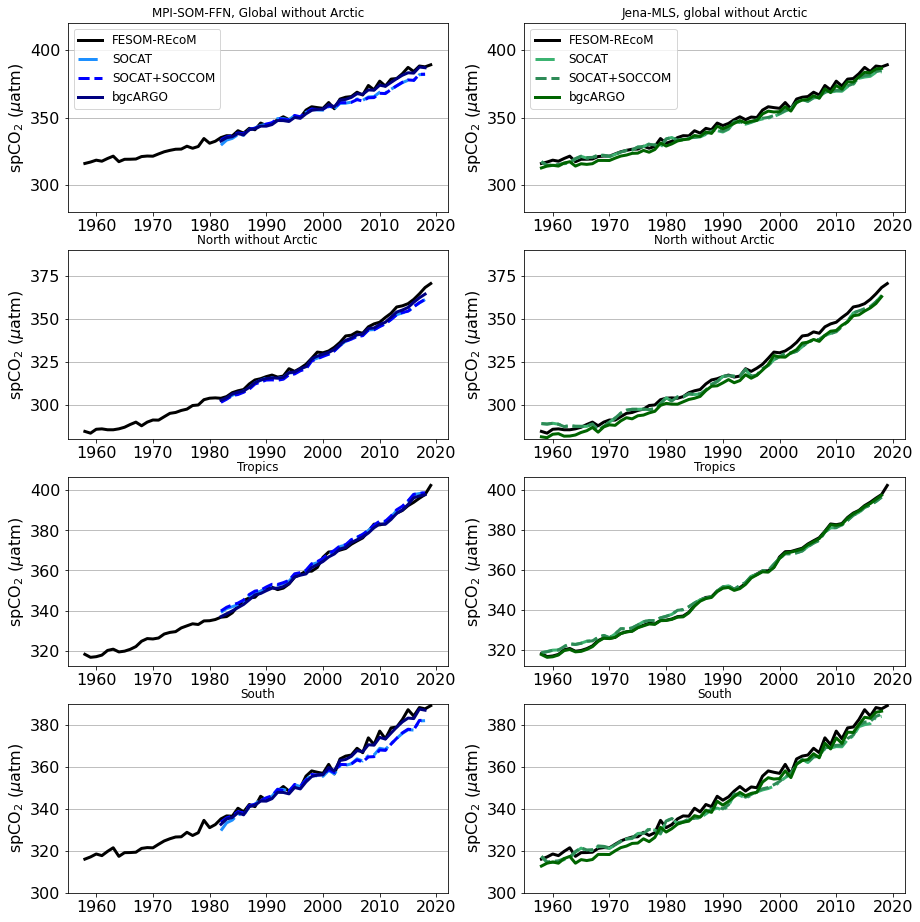

In [30]:
# same figure for pco2

# now plot both products together with the known truth:


fig,ax = plt.subplots(5,2,figsize=(15,16))
#plt.figure(figsize=(8,8))

# left: Landschützer

# global
ax1 = plt.subplot(4,2,1)
plt.plot(gcb_years[:-1],fesom_spco2_glo_noArc_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM')

plt.plot(gcb_years,land_spco2_A_glo_noArc_am,color='dodgerblue',linestyle='dashdot',linewidth='3',label='SOCAT')
plt.plot(gcb_years,land_spco2_B_glo_noArc_am,color='blue',linestyle='dashed',linewidth='3',label='SOCAT+SOCCOM')
plt.plot(gcb_years,land_spco2_C_glo_noArc_am,color='navy',linestyle='solid',linewidth='3',label='bgcARGO')

plt.legend()
plt.title('MPI-SOM-FFN, Global without Arctic')
plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(280,420) 
plt.grid(b=None, which='major', axis='y')

# # N-Arc
# ax1 = plt.subplot(5,2,3)
# plt.plot(gcb_years[:-1],fesom_spco2_Arc_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

# plt.plot(gcb_years,land_spco2_A_Arc_am,color='dodgerblue',linestyle='dashdot',linewidth='3',label='SOM-FFN, SOCAT')
# plt.plot(gcb_years,land_spco2_B_Arc_am,color='blue',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
# plt.plot(gcb_years,land_spco2_C_Arc_am,color='navy',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

# #plt.legend()
# plt.title('Arctic')
# plt.ylabel('spCO$_2$ ($\mu$atm)')
# plt.ylim(180,660) 
# plt.grid(b=None, which='major', axis='y')

# N-60
ax1 = plt.subplot(4,2,3)
plt.plot(gcb_years[:-1],fesom_spco2_N_noArc_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years,land_spco2_A_N_noArc_am,color='dodgerblue',linestyle='dashdot',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years,land_spco2_B_N_noArc_am,color='blue',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years,land_spco2_C_N_noArc_am,color='navy',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

#plt.legend()
plt.title('North without Arctic')
plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(280,390) 
plt.grid(b=None, which='major', axis='y')

# T
ax1 = plt.subplot(4,2,5)
plt.plot(gcb_years[:-1],fesom_spco2_T_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years,land_spco2_A_T_am,color='dodgerblue',linestyle='dashdot',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years,land_spco2_B_T_am,color='blue',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years,land_spco2_C_T_am,color='navy',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

#plt.legend()
plt.title('Tropics')
plt.ylabel('spCO$_2$ ($\mu$atm)')
#plt.ylim(280,420) 
plt.grid(b=None, which='major', axis='y')

# S
ax1 = plt.subplot(4,2,7)
plt.plot(gcb_years[:-1],fesom_spco2_S_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years,land_spco2_A_S_am,color='dodgerblue',linestyle='dashdot',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years,land_spco2_B_S_am,color='blue',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years,land_spco2_C_S_am,color='navy',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

plt.title('South')
plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(300,390) 
plt.grid(b=None, which='major', axis='y')

#------------------------------------------------------------
# right: Rödenbeck

# global
ax1 = plt.subplot(4,2,2)
plt.plot(gcb_years[:-1],fesom_spco2_glo_noArc_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM')

plt.plot(gcb_years,roeden_spco2_A_glo_noArc_am,color='mediumseagreen',linewidth=3,linestyle='dashdot',label='SOCAT')
plt.plot(gcb_years,roeden_spco2_B_glo_noArc_am,color='seagreen',linewidth=3,linestyle='dashed',label='SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_spco2_C_glo_noArc_am,color='darkgreen',linewidth=3,linestyle='solid',label='bgcARGO')

plt.legend()
plt.title('Jena-MLS, global without Arctic')
plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(280,420) 
plt.grid(b=None, which='major', axis='y')

# # Arc
# ax1 = plt.subplot(5,2,4)
# plt.plot(gcb_years[:-1],fesom_spco2_Arc_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

# plt.plot(gcb_years,roeden_spco2_A_Arc_am,color='mediumseagreen',linewidth=3,linestyle='dashdot',label='MLS, SOCAT')
# plt.plot(gcb_years,roeden_spco2_B_Arc_am,color='seagreen',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
# plt.plot(gcb_years,roeden_spco2_C_Arc_am,color='darkgreen',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

# #plt.legend()
# plt.title('Arctic')
# plt.ylabel('spCO$_2$ ($\mu$atm)')
# plt.ylim(180,660) 
# plt.grid(b=None, which='major', axis='y')

# N-60
ax1 = plt.subplot(4,2,4)
plt.plot(gcb_years[:-1],fesom_spco2_N_noArc_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years,roeden_spco2_A_N_noArc_am,color='mediumseagreen',linewidth=3,linestyle='dashdot',label='MLS, SOCAT')
plt.plot(gcb_years,roeden_spco2_B_N_noArc_am,color='seagreen',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_spco2_C_N_noArc_am,color='darkgreen',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

#plt.legend()
plt.title('North without Arctic')
plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(280,390) 
plt.grid(b=None, which='major', axis='y')

# T
ax1 = plt.subplot(4,2,6)
plt.plot(gcb_years[:-1],fesom_spco2_T_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years,roeden_spco2_A_T_am,color='mediumseagreen',linewidth=3,linestyle='dashdot',label='MLS, SOCAT')
plt.plot(gcb_years,roeden_spco2_B_T_am,color='seagreen',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_spco2_C_T_am,color='darkgreen',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

#plt.legend()
plt.title('Tropics')
plt.ylabel('spCO$_2$ ($\mu$atm)')
#plt.ylim(280,420) 
plt.grid(b=None, which='major', axis='y')

# S
ax1 = plt.subplot(4,2,8)
plt.plot(gcb_years[:-1],fesom_spco2_S_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years,roeden_spco2_A_S_am,color='mediumseagreen',linewidth=3,linestyle='dashdot',label='MLS, SOCAT')
plt.plot(gcb_years,roeden_spco2_B_S_am,color='seagreen',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years,roeden_spco2_C_S_am,color='darkgreen',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

plt.title('South')
plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(300,390) 
plt.grid(b=None, which='major', axis='y')

plt.savefig('subsampling_FLRspco2_gloNTS_noArc.png',dpi=300,facecolor='w',transparent=False)
plt.show()




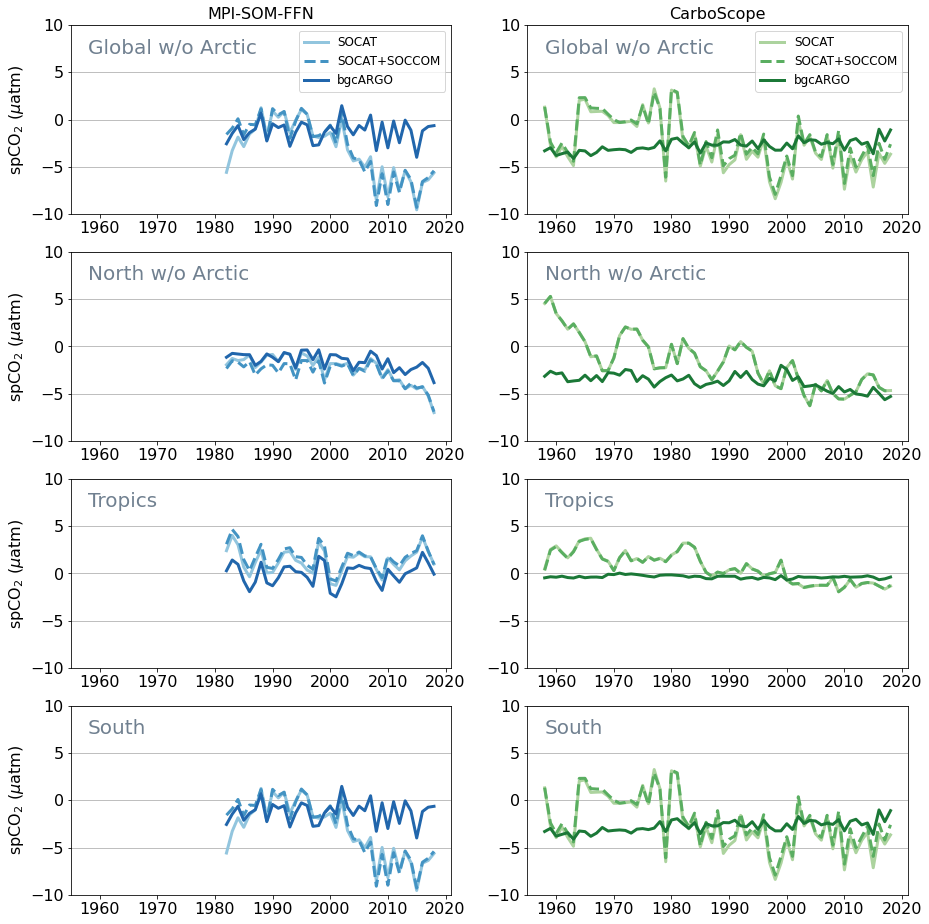

In [31]:
# plot difference in pCO2 rather than absolute values


fig,ax = plt.subplots(4,2,figsize=(15,16))
#plt.figure(figsize=(8,8))

# left: Landschützer

# global
ax1 = plt.subplot(4,2,1)
#plt.plot(gcb_years[:-1],fesom_spco2_global_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM')

plt.plot(gcb_years[:-1],land_spco2_A_glo_noArc_am[:-1]-fesom_spco2_glo_noArc_am,color='#92C5DE',linestyle='solid',linewidth='3',label='SOCAT')
plt.plot(gcb_years[:-1],land_spco2_B_glo_noArc_am[:-1]-fesom_spco2_glo_noArc_am,color='#4393C3',linestyle='dashed',linewidth='3',label='SOCAT+SOCCOM')
plt.plot(gcb_years[:-1],land_spco2_C_glo_noArc_am[:-1]-fesom_spco2_glo_noArc_am,color='#2166AC',linestyle='solid',linewidth='3',label='bgcARGO')

plt.legend(loc='upper right')
plt.title('MPI-SOM-FFN', fontsize=16)#Global without Arctic')
plt.text(1958,7,'Global w/o Arctic',fontsize=20,color='slategrey')

#plt.text()
plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(-10,10) 
plt.xlim(1955,2021) 

plt.grid(b=None, which='major', axis='y')

# # N-Arc
# ax1 = plt.subplot(5,2,3)
# #plt.plot(gcb_years[:-1],fesom_spco2_Arc_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

# plt.plot(gcb_years[:-1],land_spco2_A_Arc_am[:-1]-fesom_spco2_Arc_am,color='#92C5DE',linestyle='solid',linewidth='3',label='SOM-FFN, SOCAT')
# plt.plot(gcb_years[:-1],land_spco2_B_Arc_am[:-1]-fesom_spco2_Arc_am,color='#4393C3',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
# plt.plot(gcb_years[:-1],land_spco2_C_Arc_am[:-1]-fesom_spco2_Arc_am,color='#2166AC',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

# #plt.legend()
# plt.title('Arctic')
# plt.ylabel('spCO$_2$ ($\mu$atm)')
# plt.ylim(-250,300) 
# plt.grid(b=None, which='major', axis='y')

# N-60
ax1 = plt.subplot(4,2,3)
#plt.plot(gcb_years[:-1],fesom_spco2_N60_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years[:-1],land_spco2_A_N_noArc_am[:-1]-fesom_spco2_N_noArc_am,color='#92C5DE',linestyle='solid',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years[:-1],land_spco2_B_N_noArc_am[:-1]-fesom_spco2_N_noArc_am,color='#4393C3',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years[:-1],land_spco2_C_N_noArc_am[:-1]-fesom_spco2_N_noArc_am,color='#2166AC',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

#plt.legend()
plt.text(1958,7,'North w/o Arctic',fontsize=20,color='slategrey')
#plt.title('North without Arctic')
plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(-10,10) 
plt.xlim(1955,2021) 
plt.grid(b=None, which='major', axis='y')

# T
ax1 = plt.subplot(4,2,5)
#plt.plot(gcb_years[:-1],fesom_spco2_T_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years[:-1],land_spco2_A_T_am[:-1]-fesom_spco2_T_am,color='#92C5DE',linestyle='solid',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years[:-1],land_spco2_B_T_am[:-1]-fesom_spco2_T_am,color='#4393C3',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years[:-1],land_spco2_C_T_am[:-1]-fesom_spco2_T_am,color='#2166AC',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

#plt.legend()
#plt.title('Tropics')
plt.text(1958,7,'Tropics',fontsize=20,color='slategrey')
plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(-10,10) 
plt.xlim(1955,2021) 
plt.grid(b=None, which='major', axis='y')

# S
ax1 = plt.subplot(4,2,7)
#plt.plot(gcb_years[:-1],fesom_spco2_S_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years[:-1],land_spco2_A_S_am[:-1]-fesom_spco2_S_am,color='#92C5DE',linestyle='solid',linewidth='3',label='SOM-FFN, SOCAT')
plt.plot(gcb_years[:-1],land_spco2_B_S_am[:-1]-fesom_spco2_S_am,color='#4393C3',linestyle='dashed',linewidth='3',label='SOM-FFN, SOCAT+SOCCOM')
plt.plot(gcb_years[:-1],land_spco2_C_S_am[:-1]-fesom_spco2_S_am,color='#2166AC',linestyle='solid',linewidth='3',label='SOM-FFN, bgcARGO')

#plt.title('South')
plt.text(1958,7,'South',fontsize=20,color='slategrey')
plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(-10,10) 
plt.xlim(1955,2021) 
plt.grid(b=None, which='major', axis='y')

#------------------------------------------------------------
# right: Rödenbeck

# global
ax1 = plt.subplot(4,2,2)
#plt.plot(gcb_years[:-1],fesom_spco2_global_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM')

plt.plot(gcb_years[:-1],roeden_spco2_A_glo_noArc_am[:-1]-fesom_spco2_glo_noArc_am,color='#ACD39E',linewidth=3,linestyle='solid',label='SOCAT')
plt.plot(gcb_years[:-1],roeden_spco2_B_glo_noArc_am[:-1]-fesom_spco2_glo_noArc_am,color='#5AAE61',linewidth=3,linestyle='dashed',label='SOCAT+SOCCOM')
plt.plot(gcb_years[:-1],roeden_spco2_C_glo_noArc_am[:-1]-fesom_spco2_glo_noArc_am,color='#1B7837',linewidth=3,linestyle='solid',label='bgcARGO')

plt.legend()
plt.title('CarboScope', fontsize=16)#Global without Arctic')
plt.text(1958,7,'Global w/o Arctic',fontsize=20,color='slategrey')

#plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(-10,10) 
plt.grid(b=None, which='major', axis='y')

# # Arc
# ax1 = plt.subplot(5,2,4)
# #plt.plot(gcb_years[:-1],fesom_spco2_Arc_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

# plt.plot(gcb_years[:-1],roeden_spco2_A_Arc_am[:-1]-fesom_spco2_Arc_am,color='#ACD39E',linewidth=3,linestyle='solid',label='MLS, SOCAT')
# plt.plot(gcb_years[:-1],roeden_spco2_B_Arc_am[:-1]-fesom_spco2_Arc_am,color='#5AAE61',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
# plt.plot(gcb_years[:-1],roeden_spco2_C_Arc_am[:-1]-fesom_spco2_Arc_am,color='#1B7837',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

# #plt.legend()
# plt.title('Arctic')
# plt.ylabel('spCO$_2$ ($\mu$atm)')
# plt.ylim(-250,300) 
# plt.grid(b=None, which='major', axis='y')

# N-60
ax1 = plt.subplot(4,2,4)
#plt.plot(gcb_years[:-1],fesom_spco2_N60_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years[:-1],roeden_spco2_A_N_noArc_am[:-1]-fesom_spco2_N_noArc_am,color='#ACD39E',linewidth=3,linestyle='solid',label='MLS, SOCAT')
plt.plot(gcb_years[:-1],roeden_spco2_B_N_noArc_am[:-1]-fesom_spco2_N_noArc_am,color='#5AAE61',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years[:-1],roeden_spco2_C_N_noArc_am[:-1]-fesom_spco2_N_noArc_am,color='#1B7837',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

#plt.legend()
#plt.title('North without Arctic')
plt.text(1958,7,'North w/o Arctic',fontsize=20,color='slategrey')
#plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(-10,10) 
plt.grid(b=None, which='major', axis='y')

# T
ax1 = plt.subplot(4,2,6)
#plt.plot(gcb_years[:-1],fesom_spco2_T_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years[:-1],roeden_spco2_A_T_am[:-1]-fesom_spco2_T_am,color='#ACD39E',linewidth=3,linestyle='solid',label='MLS, SOCAT')
plt.plot(gcb_years[:-1],roeden_spco2_B_T_am[:-1]-fesom_spco2_T_am,color='#5AAE61',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years[:-1],roeden_spco2_C_T_am[:-1]-fesom_spco2_T_am,color='#1B7837',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

#plt.legend()
#plt.title('Tropics')
plt.text(1958,7,'Tropics',fontsize=20,color='slategrey')
#plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(-10,10) 
plt.grid(b=None, which='major', axis='y')

# S
ax1 = plt.subplot(4,2,8)
#plt.plot(gcb_years[:-1],fesom_spco2_S_am,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM (known truth)')

plt.plot(gcb_years[:-1],roeden_spco2_A_S_am[:-1]-fesom_spco2_S_am,color='#ACD39E',linewidth=3,linestyle='solid',label='MLS, SOCAT')
plt.plot(gcb_years[:-1],roeden_spco2_B_S_am[:-1]-fesom_spco2_S_am,color='#5AAE61',linewidth=3,linestyle='dashed',label='MLS, SOCAT+SOCCOM')
plt.plot(gcb_years[:-1],roeden_spco2_C_S_am[:-1]-fesom_spco2_S_am,color='#1B7837',linewidth=3,linestyle='solid',label='MLS, bgcARGO')

#plt.title('South')
plt.text(1958,7,'South',fontsize=20,color='slategrey')
#plt.ylabel('spCO$_2$ ($\mu$atm)')
plt.ylim(-10,10) 
plt.grid(b=None, which='major', axis='y')

plt.savefig('subsampling_FLRspco2diff_gloNTS_noArc.png',dpi=300,facecolor='w',transparent=False)
plt.show()


In [32]:
###-----------------------------
### calculate some statistics
###-----------------------------
# first again some definitions:

# moved to top, need them earlier already
# ind = np.where((gcb_years>=2009) & (gcb_years<=2018))
# print(ind,gcb_years[ind])

# # for trend 2000 - 2018:

# ind2000 = np.where((gcb_years>=2000) & (gcb_years<=2018))
# print(ind2000,gcb_years[ind2000])

# # common years 1982 to 2018
# ind_com = np.where((gcb_years>=1982) & (gcb_years<=2018))


# names for loops:
products = ['Roedenbeck','Landschuetzer']
products_short=['roeden','land']

regions = ['glo','glo_noArc','Arc','N_noArc','T','S']

cases = ['A','B','C']
cases_long = ['SOCAT','SOCAT+SOCCOM','bgcArgo']

#----------------------------------
#..................................
# calculate the mean 2009-2018
#..................................
print('CO2 flux')
for region in regions:
    print('......................')
    
    exec("x = np.nanmean(fesom_fgco2_PgCyr_"+region+"[ind])")
    exec("fesom_"+region+"_mean = x")
    print('fesom ',region,'{:04.2f}'.format(x))
    
    for product in products_short:
        print('......................')

        for case in cases:
            
            exec("tmp = np.nanmean(" +product+"_fgco2_PgCyr_"+case+"_"+region+"[ind])") 
            exec(product+"_"+region+"_"+case+"_mean = tmp") 
                 
            print(product,region,case)
            print('{:04.2f}'.format(tmp))


#-------------------
# same for pCO2         

regions = ['global','glo_noArc','Arc','N_noArc','T','S']

print('--------')
print('pCO2')

for region in regions:
    print('......................')

    exec("x = np.nanmean(fesom_spco2_"+region+"_am[ind])")
    exec("fesom_"+region+"_mean_spco2 = x")
    print('fesom ',region,'{:04.2f}'.format(x))
    
    for product in products_short:
        print('......................')
    
        for case in cases:
            
            exec("tmp2 = np.nanmean(" +product+"_spco2_"+case+"_"+region+"_am[ind])") 
            exec(product+"_"+region+"_"+case+"_mean_spco2 = tmp2") 
                 
            print(product,region,case)
            print('{:04.2f}'.format(tmp2))

print('glo, SOCAT: Land-FESOM (%): ', 100*(land_glo_noArc_A_mean-fesom_glo_noArc_mean)/fesom_glo_noArc_mean)
print('glo, SOCAT: Roeden-FESOM (%): ', 100*(roeden_glo_noArc_A_mean-fesom_glo_noArc_mean)/fesom_glo_noArc_mean)

print('glo, bgcArgo: Land-FESOM (%): ', 100*(land_glo_noArc_C_mean-fesom_glo_noArc_mean)/fesom_glo_noArc_mean)
print('glo, bgcArgo: Roeden-FESOM (%): ', 100*(roeden_glo_noArc_C_mean-fesom_glo_noArc_mean)/fesom_glo_noArc_mean)

print('L: ', land_glo_A_mean, land_glo_B_mean,land_glo_C_mean)
print('R: ', roeden_glo_A_mean, roeden_glo_B_mean,roeden_glo_C_mean)

print('......................')

print('N_noArc, SOCAT: Land-FESOM (%): ', 100*(land_N_noArc_A_mean-fesom_N_noArc_mean)/fesom_N_noArc_mean)
print('N_norc, SOCAT: Roeden-FESOM (%): ', 100*(roeden_N_noArc_A_mean-fesom_N_noArc_mean)/fesom_N_noArc_mean)


print('N_noArc, bgcArgo: Land-FESOM (%): ', 100*(land_N_noArc_C_mean-fesom_N_noArc_mean)/fesom_N_noArc_mean)
print('N_norc, bgcArgo: Roeden-FESOM (%): ', 100*(roeden_N_noArc_C_mean-fesom_N_noArc_mean)/fesom_N_noArc_mean)
print('......................')

print('S, SOCAT: Land-FESOM (%): ', 100*(land_S_A_mean-fesom_S_mean)/fesom_S_mean)
print('S, SOCAT: Roeden-FESOM (%): ', 100*(roeden_S_A_mean-fesom_S_mean)/fesom_S_mean)


print('S, bgcArgo: Land-FESOM (%): ', 100*(land_S_C_mean-fesom_S_mean)/fesom_S_mean)
print('S, bgcArgo: Roeden-FESOM (%): ', 100*(roeden_S_C_mean-fesom_S_mean)/fesom_S_mean)
# print('N: Fesom: ', fesom_N_mean)
# print('L: ', land_N_A_mean, land_N_B_mean,land_N_C_mean)
# print('R: ', roeden_N_A_mean, roeden_N_B_mean,roeden_N_C_mean)

# print('Fesom: ', fesom_T_mean)
# print('L: ', land_T_A_mean, land_T_B_mean,land_T_C_mean)
# print('R: ', roeden_T_A_mean, roeden_T_B_mean,roeden_T_C_mean)

print('Fesom: ', fesom_S_mean)
print('L: ', land_S_A_mean, land_S_B_mean,land_S_C_mean)
print('R: ', roeden_S_A_mean, roeden_S_B_mean,roeden_S_C_mean)
print(land_S_A_mean-land_S_B_mean)
print('R: ', roeden_S_A_mean-roeden_S_B_mean)

CO2 flux
......................
fesom  glo 2.49
......................
roeden glo A
2.70
roeden glo B
2.64
roeden glo C
2.56
......................
land glo A
2.79
land glo B
2.79
land glo C
2.61
......................
fesom  glo_noArc 2.44
......................
roeden glo_noArc A
2.62
roeden glo_noArc B
2.56
roeden glo_noArc C
2.45
......................
land glo_noArc A
2.73
land glo_noArc B
2.73
land glo_noArc C
2.67
......................
fesom  Arc 0.06
......................
roeden Arc A
0.08
roeden Arc B
0.08
roeden Arc C
0.12
......................
land Arc A
0.06
land Arc B
0.06
land Arc C
-0.06
......................
fesom  N_noArc 1.25
......................
roeden N_noArc A
1.25
roeden N_noArc B
1.25
roeden N_noArc C
1.23
......................
land N_noArc A
1.37
land N_noArc B
1.37
land N_noArc C
1.30
......................
fesom  T -0.05
......................
roeden T A
-0.03
roeden T B
-0.03
roeden T C
-0.09
......................
land T A
-0.20
land T B
-0.20
land T 

In [33]:
#del a, b
#........................
# trend since 2000
#........................

x=gcb_years[ind2000]
regions = ['glo','glo_noArc','Arc','N_noArc','T','S']


for region in regions:
    print('......................')
    
    exec("a,b = np.polyfit(x,fesom_fgco2_PgCyr_"+region+"[ind2000],1)")
    exec("fesom_"+region+"_trend2000 = a")
    # b is offset, trend gets its own name
    print('fesom', region, '{:04.2f}'.format(a*10)) # this is trend in PgC/yr/decade
    
    for product in products_short:
        print('......................')
        
        for case in cases:
            exec("a,b =np.polyfit(x," +product+"_fgco2_PgCyr_"+case+"_"+region+"[ind2000],1)") 
            exec(product+"_"+region+"_"+case+"_trend2000 =a") 
            print(product, region, case,'{:04.2f}'.format(a*10)) # this is trend in PgC/yr/decade


# print('glo: Fesom: ', fesom_glo_trend2000)
# print('L: ', land_glo_A_trend2000, land_glo_B_trend2000,land_glo_C_trend2000)
# print('R: ', roeden_glo_A_trend2000, roeden_glo_B_trend2000,roeden_glo_C_trend2000)

# print('N: Fesom: ', fesom_N_trend2000)
# print('L: ', land_N_A_trend2000, land_N_B_trend2000,land_N_C_trend2000)
# print('R: ', roeden_N_A_trend2000, roeden_N_B_trend2000,roeden_N_C_trend2000)

# print('Fesom: ', fesom_T_trend2000)
# print('L: ', land_T_A_trend2000, land_T_B_trend2000,land_T_C_trend2000)
# print('R: ', roeden_T_A_trend2000, roeden_T_B_trend2000,roeden_T_C_trend2000)

# print('Fesom: ', fesom_S_trend2000)
# print('L: ', land_S_A_trend2000, land_S_B_trend2000,land_S_C_trend2000)
# print('R: ', roeden_S_A_trend2000, roeden_S_B_trend2000,roeden_S_C_trend2000)

#-----------
# same for pCO2
                 
print('------------')
print('pCO2')
                 
regions = ['global','glo_noArc','Arc','N_noArc','T','S']


for region in regions:
    print('......................')
   
    exec("a,b = np.polyfit(x,fesom_spco2_"+region+"_am[ind2000],1)")
    exec("fesom_"+region+"_trend2000_spco2 = a")
    # b is offset, trend gets its own name
    print('fesom', region, '{:04.2f}'.format(a*10)) # this is trend in PgC/yr/decade

    for product in products_short:
        print('......................')
        
        for case in cases:
            exec("a,b =np.polyfit(x," +product+"_spco2_"+case+"_"+region+"_am[ind2000],1)") 
            exec(product+"_"+region+"_"+case+"_trend2000_spco2 =a") 
            print(product, region, case,'{:04.2f}'.format(a*10)) # this is trend in PgC/yr/decade
            


print('glo, SOCAT: Land-FESOM (%): ', 100*(land_glo_noArc_A_trend2000-fesom_glo_noArc_trend2000)/fesom_glo_noArc_trend2000)
print('glo, SOCAT: Roeden-FESOM (%): ', 100*(roeden_glo_noArc_A_trend2000-fesom_glo_noArc_trend2000)/fesom_glo_noArc_trend2000)

print('glo, bgcArgo: Land-FESOM (%): ', 100*(land_glo_noArc_C_trend2000-fesom_glo_noArc_trend2000)/fesom_glo_noArc_trend2000)
print('glo, bgcArgo: Roeden-FESOM (%): ', 100*(roeden_glo_noArc_C_trend2000-fesom_glo_noArc_trend2000)/fesom_glo_noArc_trend2000)


......................
fesom glo 0.43
......................
roeden glo A 0.52
roeden glo B 0.51
roeden glo C 0.44
......................
land glo A 0.59
land glo B 0.59
land glo C 0.36
......................
fesom glo_noArc 0.43
......................
roeden glo_noArc A 0.52
roeden glo_noArc B 0.50
roeden glo_noArc C 0.44
......................
land glo_noArc A 0.58
land glo_noArc B 0.58
land glo_noArc C 0.39
......................
fesom Arc -0.00
......................
roeden Arc A 0.01
roeden Arc B 0.01
roeden Arc C 0.00
......................
land Arc A 0.00
land Arc B 0.00
land Arc C -0.03
......................
fesom N_noArc 0.08
......................
roeden N_noArc A 0.09
roeden N_noArc B 0.09
roeden N_noArc C 0.09
......................
land N_noArc A 0.14
land N_noArc B 0.14
land N_noArc C 0.09
......................
fesom T 0.23
......................
roeden T A 0.23
roeden T B 0.23
roeden T C 0.21
......................
land T A 0.15
land T B 0.15
land T C 0.15
............

In [34]:
# standard deviation of detrended time-series, do this for 1982 to 2018 where all data sets are available

regions = ['glo','glo_noArc','Arc','N_noArc','T','S']

for region in regions:
    print('......................')

    # detrending
    exec("fesom_"+region+"_det = scipy.signal.detrend(fesom_fgco2_PgCyr_"+region+"[ind_com])")
    
    # standard deviation of detrended time-series
    exec("tmp = np.std(fesom_"+region+"_det)")
    exec("fesom_"+region+"_std = tmp")
    print('fesom','{:04.2f}'.format(tmp))
    
    for product in products_short:
        print('......................')
        
        for case in cases:
            # detrending
            exec(product+"_"+region+"_"+case+"_det= scipy.signal.detrend(" +product+"_fgco2_PgCyr_"+case+"_"+region+"[ind_com])") 
            
            # standard deviation of detrended time-series:
            exec("tmp= np.std(" +product+"_"+region+"_"+case+"_det)") 
            exec(product+"_"+region+"_"+case+"_std= tmp") 
            print(product,region,case,'std','{:04.2f}'.format(tmp))

            # correlation coefficient with fesom time-series:
            exec("corr= np.corrcoef(fesom_"+region+"_det," +product+"_"+region+"_"+case+"_det)[0,1]") 
            exec(product+"_"+region+"_"+case+"_corr= corr") 
            print(product,region,case,'corr','{:04.2f}'.format(corr))
            
            
            
#---------------
# pCO2
#---------------
print('----------------------')
print('pCO2')
regions = ['global','glo_noArc','Arc','N_noArc','T','S']

for region in regions:
    print('......................')

    # detrending
    exec("fesom_"+region+"_det = scipy.signal.detrend(fesom_spco2_"+region+"_am[ind_com])")
    
    # standard deviation of detrended time-series
    exec("tmp = np.std(fesom_"+region+"_det)")
    exec("fesom_"+region+"_std_spco2 = tmp")
    print('fesom','{:04.2f}'.format(tmp))
    
    for product in products_short:
        print('......................')
        
        for case in cases:
            # detrending
            exec(product+"_"+region+"_"+case+"_det= scipy.signal.detrend(" +product+"_spco2_"+case+"_"+region+"_am[ind_com])") 
            
            # standard deviation of detrended time-series:
            exec("tmp= np.std(" +product+"_"+region+"_"+case+"_det)") 
            exec(product+"_"+region+"_"+case+"_std_spco2= tmp") 
            print(product,region,case,'std','{:04.2f}'.format(tmp))

            # correlation coefficient with fesom time-series:
            exec("corr= np.corrcoef(fesom_"+region+"_det," +product+"_"+region+"_"+case+"_det)[0,1]") 
            exec(product+"_"+region+"_"+case+"_corr_spco2= corr") 
            print(product,region,case,'corr','{:04.2f}'.format(corr))
                       
            
            
            
            
            
# # print std:
# print('std of detrended time-series:')
# print('glo: Fesom: ', fesom_glo_std)
# print('L: ', land_glo_A_std, land_glo_B_std,land_glo_C_std)
# print('R: ', roeden_glo_A_std, roeden_glo_B_std,roeden_glo_C_std)

# print('N: Fesom: ', fesom_N_std)
# print('L: ', land_N_A_std, land_N_B_std,land_N_C_std)
# print('R: ', roeden_N_A_std, roeden_N_B_std,roeden_N_C_std)

# print('T: Fesom: ', fesom_T_std)
# print('L: ', land_T_A_std, land_T_B_std,land_T_C_std)
# print('R: ', roeden_T_A_std, roeden_T_B_std,roeden_T_C_std)

# print('S: Fesom: ', fesom_S_std)
# print('L: ', land_S_A_std, land_S_B_std,land_S_C_std)
# print('R: ', roeden_S_A_std, roeden_S_B_std,roeden_S_C_std)

# # print corr:
# print('correlation coefficient of product and fesom, both detrended time-series:')

# print('glo, L: ', land_glo_A_corr, land_glo_B_corr,land_glo_C_corr)
# print('R: ', roeden_glo_A_corr, roeden_glo_B_corr,roeden_glo_C_corr)

# print('N, L: ', land_N_A_corr, land_N_B_corr,land_N_C_corr)
# print('R: ', roeden_N_A_corr, roeden_N_B_corr,roeden_N_C_corr)

# print('T, L: ', land_T_A_corr, land_T_B_corr,land_T_C_corr)
# print('R: ', roeden_T_A_corr, roeden_T_B_corr,roeden_T_C_corr)

# print('S, L: ', land_S_A_corr, land_S_B_corr,land_S_C_corr)
# print('R: ', roeden_S_A_corr, roeden_S_B_corr,roeden_S_C_corr)




# # f_glo_det =scipy.signal.detrend(co2flux_glo[ind_com])
# # f_glo_std = np.std(f_glo_det)
# # print('f, glo, std: ',f_glo_std)

# # # L, global
# # l_glo_A_det = scipy.signal.detrend(land_fgco2_PgCyr_A_glo[ind_com])
# # l_glo_A_std = np.std(l_glo_A_det)
# # print('l, glo, A std: ',l_glo_A_std)
# # # corr coeff F, L
# # l_glo_A_corr = np.corrcoef(f_glo_det,l_glo_A_det)
# # print('l, glo, A corr: ',l_glo_A_corr[0,1])

# # # B
# # l_glo_B_det = scipy.signal.detrend(land_fgco2_PgCyr_B_glo[ind_com])
# # l_glo_B_std = np.std(l_glo_B_det)
# # print('l, glo, B std: ',l_glo_B_std)
# # # corr coeff F, L
# # l_glo_B_corr = np.corrcoef(f_glo_det,l_glo_B_det)
# # print('f, glo, B corr: ',l_glo_B_corr[0,1])





......................
fesom 0.16
......................
roeden glo A std 0.14
roeden glo A corr 0.84
roeden glo B std 0.14
roeden glo B corr 0.84
roeden glo C std 0.16
roeden glo C corr 0.99
......................
land glo A std 0.14
land glo A corr 0.68
land glo B std 0.14
land glo B corr 0.68
land glo C std 0.09
land glo C corr 0.80
......................
fesom 0.16
......................
roeden glo_noArc A std 0.14
roeden glo_noArc A corr 0.83
roeden glo_noArc B std 0.14
roeden glo_noArc B corr 0.83
roeden glo_noArc C std 0.16
roeden glo_noArc C corr 0.99
......................
land glo_noArc A std 0.14
land glo_noArc A corr 0.69
land glo_noArc B std 0.14
land glo_noArc B corr 0.69
land glo_noArc C std 0.10
land glo_noArc C corr 0.83
......................
fesom 0.01
......................
roeden Arc A std 0.01
roeden Arc A corr 0.18
roeden Arc B std 0.01
roeden Arc B corr 0.18
roeden Arc C std 0.01
roeden Arc C corr 0.43
......................
land Arc A std 0.01
land Arc A corr 0

glo_noArc


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


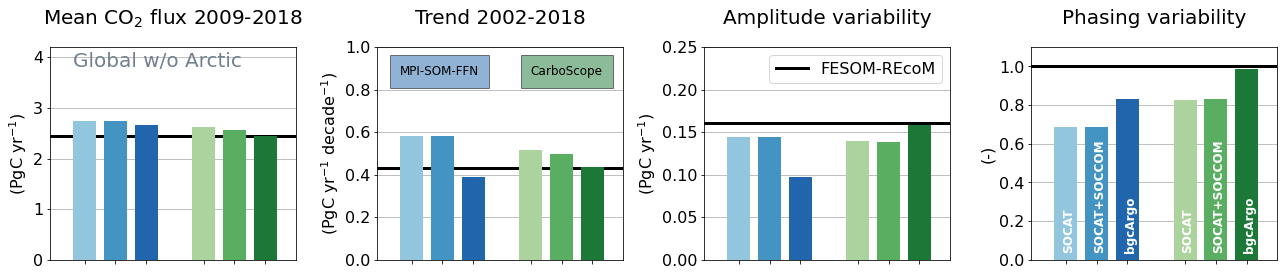

N_noArc


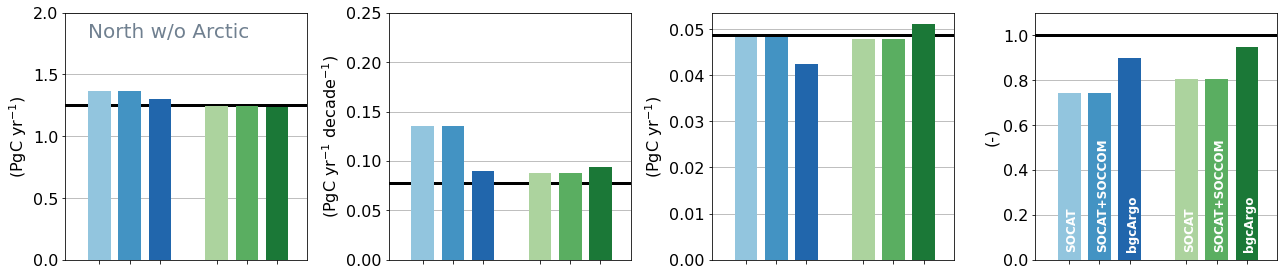

Arc
0.0008144165591126958
0.027825685776503732


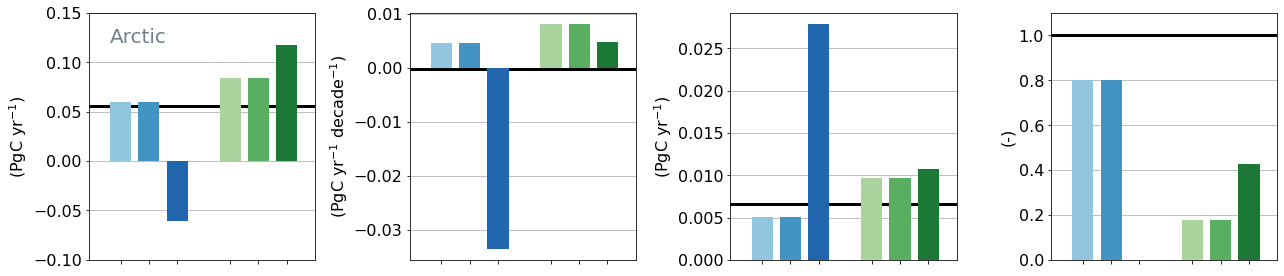

T
[-0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617
 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617
 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617
 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617
 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617
 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617
 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617
 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617 -0.04997617
 -0.04997617 -0.04997617]


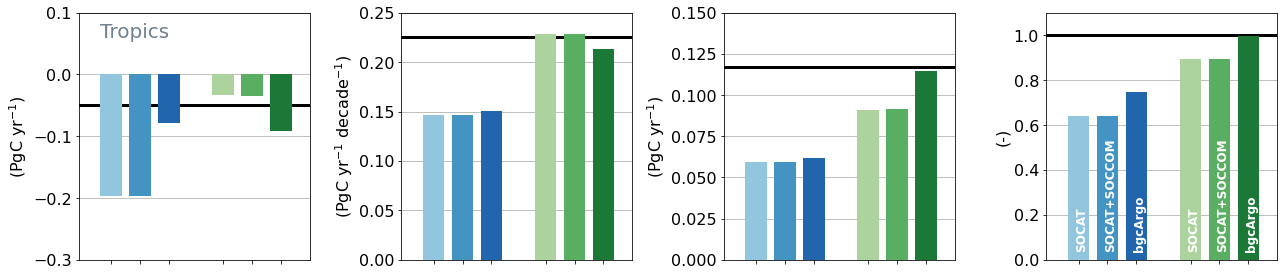

S
[1.23635533 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533
 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533
 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533
 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533
 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533
 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533
 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533
 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533 1.23635533
 1.23635533 1.23635533]


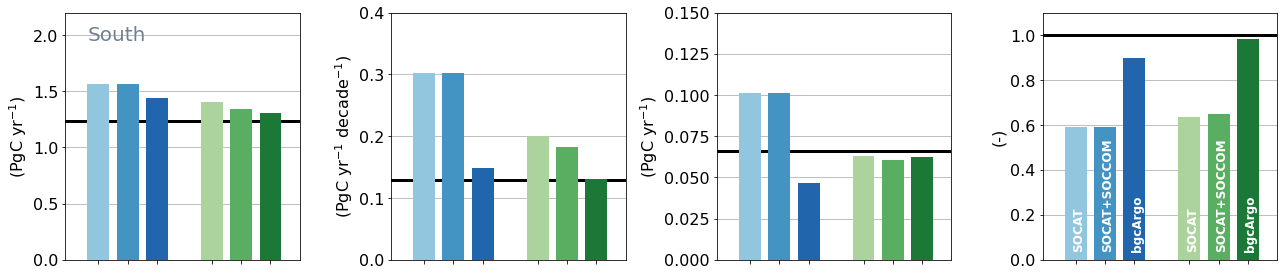

In [35]:
#del xbars, width, color
#---------------------------
# some illustrations of these statistics:
# for plots 1-3:
#xbars = np.array([1, 2.25, 2.65,3.05,3.8,4.2,4.6])
#width = np.array([0.3,0.3,0.3,0.3,0.3,0.3]) #0.8,
color=['#92C5DE','#4393C3','#2166AC','#ACD39E','#5AAE61','#1B7837'] #'black',
#color=['dodgerblue','blue','navy','mediumseagreen','seagreen','darkgreen'] #'black',

#for subplot 4:
xbars2 = np.array([2.25, 2.65,3.05,3.8,4.2,4.6])
width2 = np.array([0.3,0.3,0.3,0.3,0.3,0.3])
#color2=['dodgerblue','blue','navy','mediumseagreen','seagreen','darkgreen']
tick_labels = ['','A','B','C','A','B','C']


#-----------------

# loop over regions rather than repeating all

regions=('glo_noArc','N_noArc','Arc','T','S') #'N','Arc','N60',

# sim A
for reg in regions:
        print(reg)

# mean 2009 - 2018 ----------------------------------------------
#fesom'+reg+'mean,
        exec('data_mean = np.hstack([land_'+reg+'_A_mean,land_'+reg+'_B_mean,land_'+reg+'_C_mean,roeden_'+reg+'_A_mean,roeden_'+reg+'_B_mean,roeden_'+reg+'_C_mean])')
        #fesom'+reg+'trend2000,
        exec('data_trend = np.hstack([land_'+reg+'_A_trend2000,land_'+reg+'_B_trend2000,land_'+reg+'_C_trend2000,roeden_'+reg+'_A_trend2000,roeden_'+reg+'_B_trend2000,roeden_'+reg+'_C_trend2000])')
        #fesom'+reg+'std,
        exec('data_std = np.hstack([land_'+reg+'_A_std,land_'+reg+'_B_std,land_'+reg+'_C_std,roeden_'+reg+'_A_std,roeden_'+reg+'_B_std,roeden_'+reg+'_C_std])')

        exec('data_corr = np.hstack([land_'+reg+'_A_corr,land_'+reg+'_B_corr,land_'+reg+'_C_corr,roeden_'+reg+'_A_corr,roeden_'+reg+'_B_corr,roeden_'+reg+'_C_corr])')


        # ---------------------------
        # plot
        fig,ax = plt.subplots(1,4,figsize=(18,4))

        #----------------------------
        # mean 2009 - 2018
        x = np.linspace(0, 5)
        y=np.copy(x)
        exec('y[:]=fesom_'+reg+'_mean')

        ax1 = plt.subplot(1,4,1)
        plt.grid(b=None, which='major', axis='y',zorder=0)

        bar1=plt.bar(xbars2,data_mean,width2,color=color,tick_label='',zorder=3)#tick_labels)
        plt.plot(x,y,'k',linewidth=3)
        #plt.xticks(rotation = 90)
        
        if (reg=='glo_noArc'):
            plt.ylim(0,4.2) 
            plt.title('Mean CO$_2$ flux 2009-2018',fontsize=20,y=1.08)

        elif (reg=='Arc'): 
            plt.ylim(-0.1,0.15) 
        elif (reg=='N_noArc'): 
            plt.ylim(0,2) 
        elif (reg=='T'): 
            plt.ylim(-0.3,0.1) 
        elif (reg=='S'): 
            plt.ylim(0,2.2) 

        plt.xlim(1.8,5)
        plt.ylabel('(PgC yr$^{-1}$)')

        # plt.text(0.6, 3.8, 'known truth', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
        # #plt.legend(bar1,['REcoM','MPI-SOM-FFN SOCAT','MPI-SOM-FFN SOCAT+SOCCOM','MPI-SOM-FFN bgcArgo','Jena-MLS SOCAT','Jena-MLS SOCAT+SOCCOM','Jena-MLS bgcArgo'])
        # plt.text(2.1, 3.8, 'MPI-SOM-FFN', bbox={'facecolor': color[2], 'alpha': 0.5, 'pad': 10})
        # plt.text(3.8, 3.8, 'Jena-MLS', bbox={'facecolor': color[5], 'alpha': 0.5, 'pad': 10})
        if (reg=='glo_noArc'):
            plt.text(2.1,3.8,'Global w/o Arctic',fontsize=20,color='slategrey')
#             plt.text(2.2, 0.2, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(2.6, 0.2, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(3.0, 0.2, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

#             plt.text(3.75, 0.2, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.15, 0.2, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.55, 0.2, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

        elif (reg=='Arc'): 
            plt.text(2.1,0.12,'Arctic',fontsize=20,color='slategrey')
        elif (reg=='N_noArc'): 
            plt.text(2.1,1.8,'North w/o Arctic',fontsize=20,color='slategrey')
#             plt.text(2.2, 0.1, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(2.6, 0.1, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(3.0, 0.1, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

#             plt.text(3.75, 0.1, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.15, 0.1, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.55, 0.1, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

        elif (reg=='T'): 
            print(y)
            plt.text(2.1,0.06,'Tropics',fontsize=20,color='slategrey')
        elif (reg=='S'): 
            print(y)
            plt.text(2.1,1.95,'South',fontsize=20,color='slategrey')






        #----------------------------
        # trend 2000 - 2018
        x = np.linspace(0, 5)
        y=np.copy(x)
        exec('y[:]=10*fesom_'+reg+'_trend2000')  # trend per decade!

        ax1 = plt.subplot(1,4,2)
        plt.grid(b=None, which='major', axis='y',zorder=0)
### trend per decade!!
        bar2=plt.bar(xbars2,10*data_trend,width2,color=color,tick_label='',zorder=3)#tick_labels)
        plt.plot(x,y,'k',linewidth=3)#,label='FESOM-REcoM')
       # plt.legend()
        #plt.xticks(rotation = 90)
        if (reg=='glo_noArc'):
            plt.ylim(0,1.0) 
        elif (reg=='Arc'): 
            print(max(data_trend))
        elif (reg=='N_noArc'): 
            plt.ylim(0,0.25) 
        elif (reg=='T'): 
            plt.ylim(0,0.25) 
        elif (reg=='S'): 
            plt.ylim(0,0.4) 
            
        plt.xlim(1.8,5)

        if (reg=='glo_noArc'):        
            plt.title('Trend 2002-2018',fontsize=20,y=1.08)
        plt.ylabel('(PgC yr$^{-1}$ decade$^{-1}$)')

        # plt.text(0.6, 0.085, 'known truth', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
        # #plt.legend(bar1,['REcoM','MPI-SOM-FFN SOCAT','MPI-SOM-FFN SOCAT+SOCCOM','MPI-SOM-FFN bgcArgo','Jena-MLS SOCAT','Jena-MLS SOCAT+SOCCOM','Jena-MLS bgcArgo'])
        if (reg=='glo_noArc'): 
            plt.text(2.1, 0.87, 'MPI-SOM-FFN', bbox={'facecolor': color[2], 'alpha': 0.5, 'pad': 10})
            plt.text(3.8, 0.87, 'CarboScope', bbox={'facecolor': color[5], 'alpha': 0.5, 'pad': 10})
#         elif (reg=='N_noArc'): 
#             plt.text(2.1, 0.23, 'MPI-SOM-FFN', bbox={'facecolor': color[2], 'alpha': 0.5, 'pad': 10})
#             plt.text(3.8, 0.23, 'Jena-MLS', bbox={'facecolor': color[5], 'alpha': 0.5, 'pad': 10})


#         plt.text(2.2, 0.005, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#         plt.text(2.6, 0.005, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#         plt.text(3.0, 0.005, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

#         plt.text(3.75, 0.005, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#         plt.text(4.15, 0.005, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#         plt.text(4.55, 0.005, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')



        #----------------------------
        # std 1982 - 2018
        x = np.linspace(0, 5)
        y=np.copy(x)
        exec('y[:]=fesom_'+reg+'_std')

        ax1 = plt.subplot(1,4,3)
        plt.grid(b=None, which='major', axis='y',zorder=0)

        bar3=plt.bar(xbars2,data_std,width2,color=color,tick_label='',zorder=3)#tick_labels)
        plt.plot(x,y,'k',linewidth=3,label='FESOM-REcoM')
        

        #plt.xticks(rotation = 90)
        if (reg=='glo_noArc'):
            plt.ylim(0,0.25) 
            plt.legend(fontsize=16)

        elif (reg=='Arc'): 
            print(max(data_std))
#         elif (reg=='N_noArc'): 
#             print(max(data_std))
#             plt.ylim(0,0.15) 
#             plt.legend(fontsize=16)


        elif (reg=='T'): 
            plt.ylim(0,0.15) 

        elif (reg=='S'): 
            plt.ylim(0,0.15) 

        plt.xlim(1.8,5)

        if (reg=='glo_noArc'):
            plt.title('Amplitude variability',fontsize=20,y=1.08)  # 1982-2018
        plt.ylabel('(PgC yr$^{-1}$)')

        # plt.text(0.6, 0.22, 'known truth', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
        # #plt.legend(bar1,['REcoM','MPI-SOM-FFN SOCAT','MPI-SOM-FFN SOCAT+SOCCOM','MPI-SOM-FFN bgcArgo','Jena-MLS SOCAT','Jena-MLS SOCAT+SOCCOM','Jena-MLS bgcArgo'])
        # plt.text(2.1, 0.22, 'MPI-SOM-FFN', bbox={'facecolor': 'dodgerblue', 'alpha': 0.5, 'pad': 10})
        # plt.text(3.8, 0.22, 'Jena-MLS', bbox={'facecolor': 'mediumseagreen', 'alpha': 0.5, 'pad': 10})
#         if (reg=='glo_noArc'):
#             plt.text(2.2, 0.01, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(2.6, 0.01, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(3.0, 0.01, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

#             plt.text(3.75, 0.01, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.15, 0.01, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.55, 0.01, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

#         elif (reg=='N_noArc'): 
#             print(max(data_std))

#             plt.text(2.2, 0.01, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(2.6, 0.01, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(3.0, 0.01, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

#             plt.text(3.75, 0.01, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.15, 0.01, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.55, 0.01, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')


        #----------------------------
        # corr 1982 - 2018
        x = np.linspace(0, 5)
        y=np.copy(x)
        y[:]=1

        ax1 = plt.subplot(1,4,4)
        plt.grid(b=None, which='major', axis='y',zorder=0)

        bar4=plt.bar(xbars2,data_corr,width2,color=color,tick_label='',zorder=3)#tick_labels)
        plt.plot(x,y,'k',linewidth=3)

        #plt.xticks(rotation = 90)
 
        plt.ylim(0,1.1) 
          
        plt.xlim(1.8,5)

        if (reg=='glo_noArc'):
            plt.title('Phasing variability',fontsize=20,y=1.08) # 1982-2018
        plt.ylabel('(-)')

        # #plt.text(0.6, 0.82, 'known truth', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
        # #plt.legend(bar1,['REcoM','MPI-SOM-FFN SOCAT','MPI-SOM-FFN SOCAT+SOCCOM','MPI-SOM-FFN bgcArgo','Jena-MLS SOCAT','Jena-MLS SOCAT+SOCCOM','Jena-MLS bgcArgo'])
        # plt.text(2.2, 0.87, 'MPI-SOM-FFN', bbox={'facecolor': 'dodgerblue', 'alpha': 0.5, 'pad': 10})
        # plt.text(3.9, 0.87, 'Jena-MLS', bbox={'facecolor': 'mediumseagreen', 'alpha': 0.5, 'pad': 10})

        if (reg != 'Arc'):
            plt.text(2.2, 0.05, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
            plt.text(2.6, 0.05, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
            plt.text(3.0, 0.05, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

            plt.text(3.75, 0.05, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
            plt.text(4.15, 0.05, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
            plt.text(4.55, 0.05, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

        fig.tight_layout()

        plt.savefig('subsampling_barstats_'+reg+'_fesomkw.png',dpi=300,facecolor='w',transparent=False)
        plt.savefig('subsampling_barstats_'+reg+'_fesomkw.eps',facecolor='w',transparent=False)
        plt.savefig('subsampling_barstats_'+reg+'_fesomkw.pdf',facecolor='w',transparent=False)
        plt.show()



glo_noArc


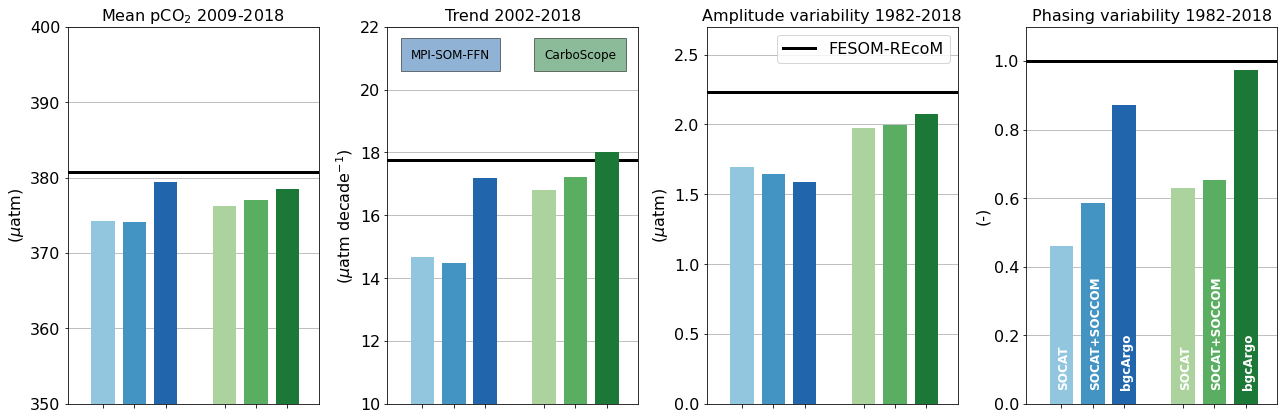

N_noArc


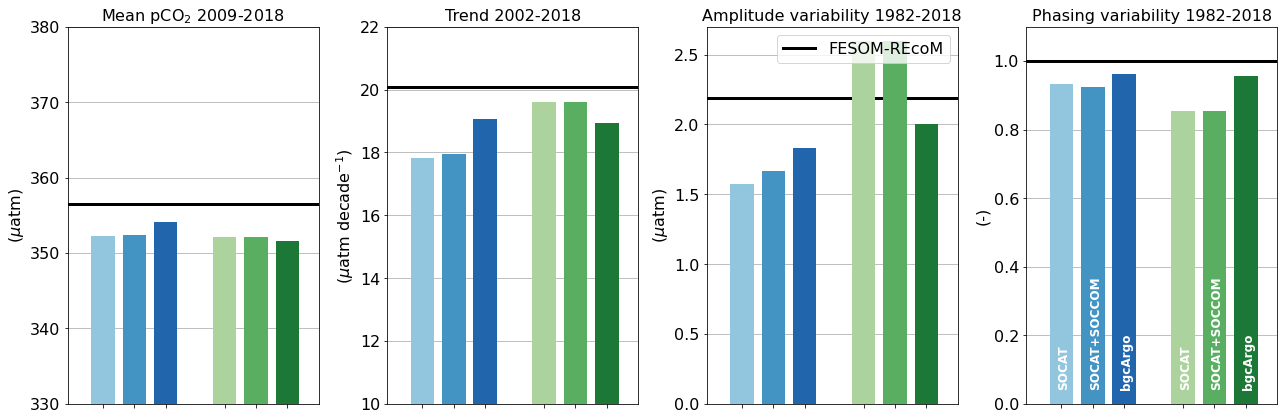

Arc
0.030229162829888356
19.14364631414568


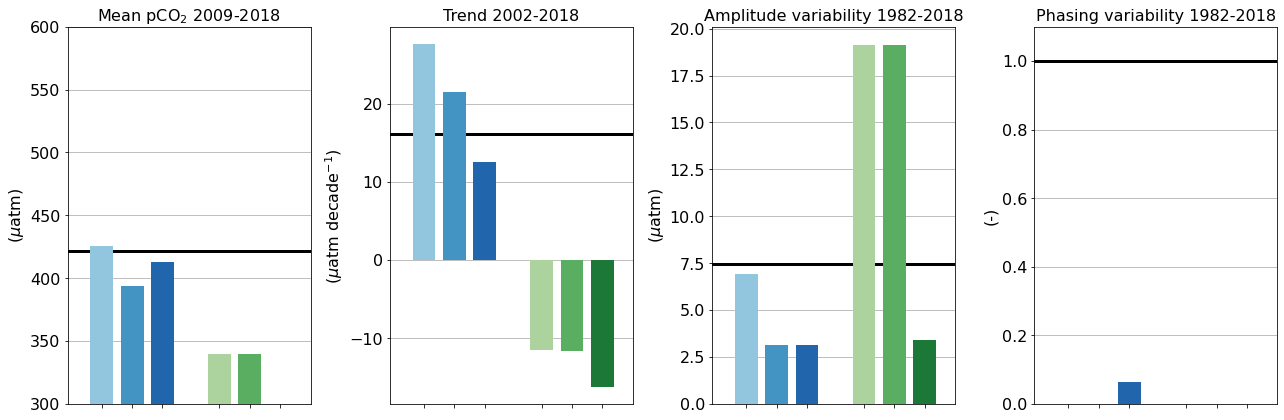

T


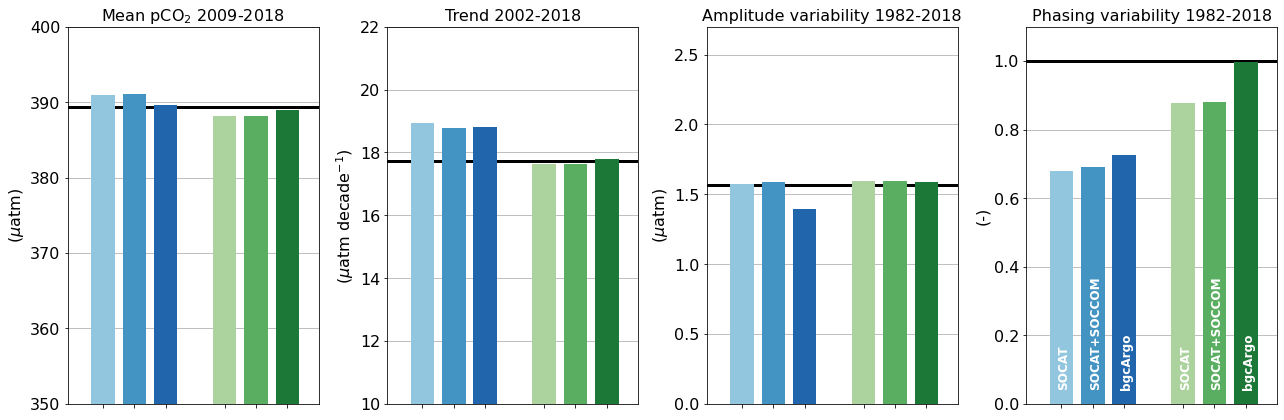

S


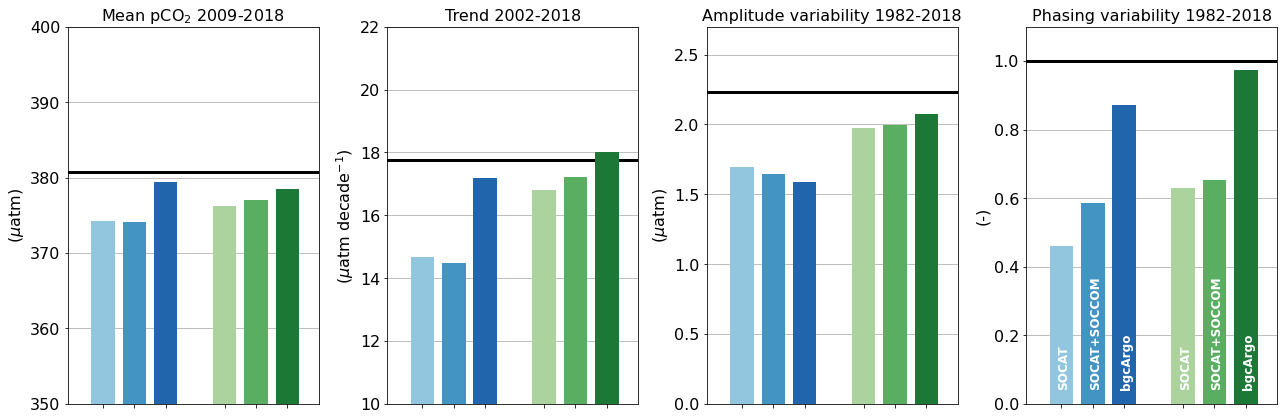

In [36]:
# same for spco2

#del xbars, width, color
#---------------------------
# some illustrations of these statistics:
# for plots 1-3:
#xbars = np.array([1, 2.25, 2.65,3.05,3.8,4.2,4.6])
#width = np.array([0.3,0.3,0.3,0.3,0.3,0.3]) #0.8,
color=['#92C5DE','#4393C3','#2166AC','#ACD39E','#5AAE61','#1B7837'] #'black',
#color=['dodgerblue','blue','navy','mediumseagreen','seagreen','darkgreen'] #'black',

#for subplot 4:
xbars2 = np.array([2.25, 2.65,3.05,3.8,4.2,4.6])
width2 = np.array([0.3,0.3,0.3,0.3,0.3,0.3])
#color2=['dodgerblue','blue','navy','mediumseagreen','seagreen','darkgreen']
tick_labels = ['','A','B','C','A','B','C']


#-----------------

# loop over regions rather than repeating all

regions=('glo_noArc','N_noArc','Arc','T','S') #'N','Arc','N60',

# sim A
for reg in regions:
        print(reg)

# mean 2009 - 2018 ----------------------------------------------
#fesom'+reg+'mean,
        exec('data_mean_spco2 = np.hstack([land_'+reg+'_A_mean_spco2,land_'+reg+'_B_mean_spco2,land_'+reg+'_C_mean_spco2,roeden_'+reg+'_A_mean_spco2,roeden_'+reg+'_B_mean_spco2,roeden_'+reg+'_C_mean_spco2])')
        #fesom'+reg+'trend2000,
        exec('data_trend_spco2 = np.hstack([land_'+reg+'_A_trend2000_spco2,land_'+reg+'_B_trend2000_spco2,land_'+reg+'_C_trend2000_spco2,roeden_'+reg+'_A_trend2000_spco2,roeden_'+reg+'_B_trend2000_spco2,roeden_'+reg+'_C_trend2000_spco2])')
        #fesom'+reg+'std,
        exec('data_std_spco2 = np.hstack([land_'+reg+'_A_std_spco2,land_'+reg+'_B_std_spco2,land_'+reg+'_C_std_spco2,roeden_'+reg+'_A_std_spco2,roeden_'+reg+'_B_std_spco2,roeden_'+reg+'_C_std_spco2])')

        exec('data_corr_spco2 = np.hstack([land_'+reg+'_A_corr_spco2,land_'+reg+'_B_corr_spco2,land_'+reg+'_C_corr_spco2,roeden_'+reg+'_A_corr_spco2,roeden_'+reg+'_B_corr_spco2,roeden_'+reg+'_C_corr_spco2])')


        # ---------------------------
        # plot
        fig,ax = plt.subplots(1,4,figsize=(18,6))

        #----------------------------
        # mean 2009 - 2018
        x = np.linspace(0, 5)
        y=np.copy(x)
        exec('y[:]=fesom_'+reg+'_mean_spco2')

        ax1 = plt.subplot(1,4,1)
        plt.grid(b=None, which='major', axis='y',zorder=0)

        bar1=plt.bar(xbars2,data_mean_spco2,width2,color=color,tick_label='',zorder=3)#tick_labels)
        plt.plot(x,y,'k',linewidth=3)
        #plt.xticks(rotation = 90)
        
        if (reg=='glo_noArc'):
            plt.ylim(350,400) 
        elif (reg=='Arc'): 
            plt.ylim(300,600) 
        elif (reg=='N_noArc'): 
            plt.ylim(330,380) 
        elif (reg=='T'): 
            plt.ylim(350,400) 
        elif (reg=='S'): 
            plt.ylim(350,400) 
#        print(np.max(data_mean_spco2))

        plt.xlim(1.8,5)
        plt.title('Mean pCO$_2$ 2009-2018',fontsize=16)
        plt.ylabel('($\mu$atm)')

#         if (reg=='glo_noArc'):
#             plt.text(2.1,3.8,'Global w/o Arctic',fontsize=20,color='slategrey')


#         elif (reg=='Arc'): 
#             plt.text(2.1,0.12,'Arctic',fontsize=20,color='slategrey')
#         elif (reg=='N_noArc'): 
#             plt.text(2.1,1.8,'North w/o Arctic',fontsize=20,color='slategrey')

#         elif (reg=='T'): 
#             print(y)
#             plt.text(2.1,0.06,'Tropics',fontsize=20,color='slategrey')
#         elif (reg=='S'): 
#             print(y)
#             plt.text(2.1,1.84,'South',fontsize=20,color='slategrey')






        #----------------------------
        # trend 2000 - 2018
        x = np.linspace(0, 5)
        y=np.copy(x)
        exec('y[:]=10*fesom_'+reg+'_trend2000_spco2')  # trend per decade!

        ax1 = plt.subplot(1,4,2)
        plt.grid(b=None, which='major', axis='y',zorder=0)
### trend per decade!!
        bar2=plt.bar(xbars2,10*data_trend_spco2,width2,color=color,tick_label='',zorder=3)#tick_labels)
        plt.plot(x,y,'k',linewidth=3)#,label='FESOM-REcoM')

        if (reg=='glo_noArc'):
            plt.ylim(10,22) 
        elif (reg=='Arc'): 
            print(max(data_trend))
        elif (reg=='N_noArc'): 
            plt.ylim(10,22) 
        elif (reg=='T'): 
            plt.ylim(10,22) 
        elif (reg=='S'): 
            plt.ylim(10,22) 
#        print(np.max(10*data_trend_spco2))

            
        plt.xlim(1.8,5)

        plt.title('Trend 2002-2018',fontsize=16)
        plt.ylabel('($\mu$atm decade$^{-1}$)')

        if (reg=='glo_noArc'): 
            plt.text(2.1, 21, 'MPI-SOM-FFN', bbox={'facecolor': color[2], 'alpha': 0.5, 'pad': 10})
            plt.text(3.8, 21, 'CarboScope', bbox={'facecolor': color[5], 'alpha': 0.5, 'pad': 10})
#         elif (reg=='N_noArc'): 
#             plt.text(2.1, 21, 'MPI-SOM-FFN', bbox={'facecolor': color[2], 'alpha': 0.5, 'pad': 10})
#             plt.text(3.8, 21, 'Jena-MLS', bbox={'facecolor': color[5], 'alpha': 0.5, 'pad': 10})






        #----------------------------
        # std 1982 - 2018
        x = np.linspace(0, 5)
        y=np.copy(x)
        exec('y[:]=fesom_'+reg+'_std_spco2')

        ax1 = plt.subplot(1,4,3)
        plt.grid(b=None, which='major', axis='y',zorder=0)

        bar3=plt.bar(xbars2,data_std_spco2,width2,color=color,tick_label='',zorder=3)#tick_labels)
        plt.plot(x,y,'k',linewidth=3,label='FESOM-REcoM')
        

        #plt.xticks(rotation = 90)
        if (reg=='glo_noArc'):
            plt.ylim(0,2.7) 
            plt.legend(fontsize=16)
        elif (reg=='Arc'): 
            print(max(data_std_spco2))
        elif (reg=='N_noArc'): 
            plt.ylim(0,2.7) 
            plt.legend(fontsize=16)
        elif (reg=='T'): 
            plt.ylim(0,2.7) 
        elif (reg=='S'): 
            plt.ylim(0,2.7) 

        plt.xlim(1.8,5)

        plt.title('Amplitude variability 1982-2018',fontsize=16)
        plt.ylabel('($\mu$atm)')

        # plt.text(0.6, 0.22, 'known truth', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
        # #plt.legend(bar1,['REcoM','MPI-SOM-FFN SOCAT','MPI-SOM-FFN SOCAT+SOCCOM','MPI-SOM-FFN bgcArgo','Jena-MLS SOCAT','Jena-MLS SOCAT+SOCCOM','Jena-MLS bgcArgo'])
        # plt.text(2.1, 0.22, 'MPI-SOM-FFN', bbox={'facecolor': 'dodgerblue', 'alpha': 0.5, 'pad': 10})
        # plt.text(3.8, 0.22, 'Jena-MLS', bbox={'facecolor': 'mediumseagreen', 'alpha': 0.5, 'pad': 10})
#         if (reg=='glo_noArc'):
#             plt.text(2.2, 0.01, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(2.6, 0.01, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(3.0, 0.01, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

#             plt.text(3.75, 0.01, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.15, 0.01, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.55, 0.01, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

#         elif (reg=='N_noArc'): 
#             print(max(data_std_spco2))

#             plt.text(2.2, 0.01, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(2.6, 0.01, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(3.0, 0.01, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

#             plt.text(3.75, 0.01, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.15, 0.01, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
#             plt.text(4.55, 0.01, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')


        #----------------------------
        # corr 1982 - 2018
        x = np.linspace(0, 5)
        y=np.copy(x)
        y[:]=1

        ax1 = plt.subplot(1,4,4)
        plt.grid(b=None, which='major', axis='y',zorder=0)

        bar4=plt.bar(xbars2,data_corr_spco2,width2,color=color,tick_label='',zorder=3)#tick_labels)
        plt.plot(x,y,'k',linewidth=3)

        #plt.xticks(rotation = 90)
 
        plt.ylim(0,1.1) 
          
        plt.xlim(1.8,5)

        plt.title('Phasing variability 1982-2018',fontsize=16)
        plt.ylabel('(-)')

        # #plt.text(0.6, 0.82, 'known truth', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
        # #plt.legend(bar1,['REcoM','MPI-SOM-FFN SOCAT','MPI-SOM-FFN SOCAT+SOCCOM','MPI-SOM-FFN bgcArgo','Jena-MLS SOCAT','Jena-MLS SOCAT+SOCCOM','Jena-MLS bgcArgo'])
        # plt.text(2.2, 0.87, 'MPI-SOM-FFN', bbox={'facecolor': 'dodgerblue', 'alpha': 0.5, 'pad': 10})
        # plt.text(3.9, 0.87, 'Jena-MLS', bbox={'facecolor': 'mediumseagreen', 'alpha': 0.5, 'pad': 10})

        if (reg != 'Arc'):
            plt.text(2.2, 0.05, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
            plt.text(2.6, 0.05, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
            plt.text(3.0, 0.05, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

            plt.text(3.75, 0.05, 'SOCAT',color='white',rotation=90,fontsize=12,weight='bold')
            plt.text(4.15, 0.05, 'SOCAT+SOCCOM',color='white',rotation=90,fontsize=12,weight='bold')
            plt.text(4.55, 0.05, 'bgcArgo',color='white',rotation=90,fontsize=12,weight='bold')

        fig.tight_layout()

        plt.savefig('subsampling_barstats_'+reg+'_spco2.png',dpi=300,facecolor='w',transparent=False)
        plt.show()


(180, 360)


<ipython-input-37-079ff5886579>:47: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar2 = fig.colorbar(image,
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists wi

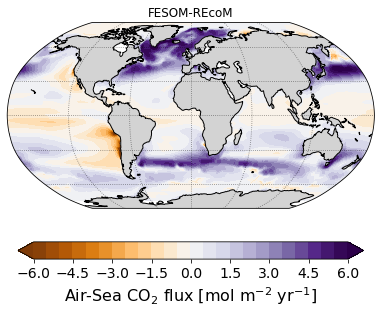

In [37]:
# continue with some difference maps of CO2 flux and also pCO2...

cmap = cm.coolwarm_r
cmap2 = cm.PuOr



#### fgco2

fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.Robinson()),  #ccrs.PlateCarree()
            constrained_layout=False,
            figsize=(6,4),sharex=True,sharey=True,
        )

#ax = ax.flatten()


# first one: fesom only



x = fesom_fgco2_2009_2018
x_m = np.ma.array(x, mask=np.isnan(x))
print(np.shape(x_m))
levels = np.arange(-6,6.5,0.5)
image = ax.contourf(xax,yax,x_m, levels, cmap=cmap2, extend='both',transform=ccrs.PlateCarree())#vmin=np.nanmin(x), vmax=np.nanmax(x)) 
ax.set_title('FESOM-REcoM')
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
#ax.set_xticks([-180, -90, 0, 90, 180], crs=ccrs.Robinson())  #crs=ccrs.PlateCarree()
#ax.set_yticks([-60, 30,0, 30,60], crs=ccrs.Robinson())#crs=ccrs.PlateCarree()
#ax.set_yticks([-60, 30,0, 30,60], crs=ccrs.Robinson())#crs=ccrs.PlateCarree()
#lon_formatter = LongitudeFormatter() #zero_direction_label=True
#lat_formatter = LatitudeFormatter()
#ax.xaxis.set_major_formatter(lon_formatter)
#ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines()
ax.gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 

#------------
# plt.colorbar()    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

cbar2_ax = fig.add_axes([0.125, 0.001, 0.8, 0.06])
cbar2 = fig.colorbar(image,
                    cax = cbar2_ax, 
                    orientation = 'horizontal',
                    pad=0.01,  extend='both') #shrink=0.9,
cbar2.set_label('Air-Sea CO$_2$ flux [mol m$^{-2}$ yr$^{-1}$]', fontsize=16)
cbar2.ax.tick_params(labelsize=14)


plt.savefig('FESOM_CO2flux_map_2009_2018.png',transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('FESOM_CO2flux_map_2009_2018.eps',transparent=False, bbox_inches='tight')
plt.savefig('FESOM_CO2flux_map_2009_2018.pdf',transparent=False, bbox_inches='tight')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

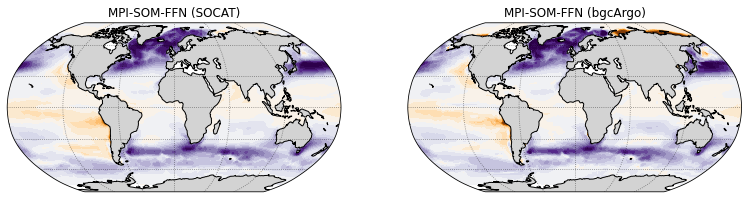

In [38]:
# then the three versions of Landschützer - skip SOCCOM

fig, ax = plt.subplots(
            1,
            2, #3
            subplot_kw=dict(projection=ccrs.Robinson()),
            constrained_layout=False,
            figsize=(12,4),sharex=True,sharey=True,
        )

ax = ax.flatten()



#----------------------------------------------------------------------
# 3. landschuetzer, A:
x3 = land_fgco2_A_2009_2018
x_m3 = np.ma.array(x3, mask=np.isnan(x3))
levels = np.arange(-6,6.5,0.5)
image3 = ax[0].contourf(xax,yax,x_m3, levels, cmap=cmap2, extend='both',transform=ccrs.PlateCarree())
#image3 = ax[0].pcolor(xax,yax,x_m3, vmin=-5, vmax=5, cmap=cmap)
ax[0].set_title('MPI-SOM-FFN (SOCAT)')
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# ax[0].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[0].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[0].coastlines()
ax[0].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 

# #----------------------------------------------------------------------
# # 4. landschuetzer, B:
# x4 = land_fgco2_B_2009_2018
# x_m4 = np.ma.array(x4, mask=np.isnan(x4))
# image4 = ax[1].pcolor(xax,yax,x_m4, vmin=-5, vmax=5, cmap=cmap)
# ax[1].set_title('MPI-SOM-FFN, SOCAT+ SOCCOM')
# ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())

# ax[1].coastlines()
#----------------------------------------------------------------------
# 5. landschuetzer, C:
x5 = land_fgco2_C_2009_2018
x_m5 = np.ma.array(x5, mask=np.isnan(x5))
image3 = ax[1].contourf(xax,yax,x_m5, levels, cmap=cmap2, extend='both',transform=ccrs.PlateCarree())
ax[1].set_title('MPI-SOM-FFN (bgcArgo)')
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[1].coastlines()
ax[1].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 

# ax[1] for second subplot


# plt.colorbar()    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

# cbar2_ax = fig.add_axes([0.2, 0.001, 0.66, 0.06])
# cbar2 = fig.colorbar(image3,
#                     cax = cbar2_ax, 
#                     orientation = 'horizontal',
#                     pad=0.1, shrink=0.9, extend='both') #
# cbar2.set_label('Air-Sea CO$_2$ exchange [mol m$^{-2}$ yr$^{-1}$]', fontsize=16)
# cbar2.ax.tick_params(labelsize=14)


plt.savefig('L_CO2flux_map_AC_2009_2018_fesomkw.png',transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('L_CO2flux_map_AC_2009_2018_fesomkw.eps',transparent=False, bbox_inches='tight')
plt.savefig('L_CO2flux_map_AC_2009_2018_fesomkw.pdf',transparent=False, bbox_inches='tight')

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

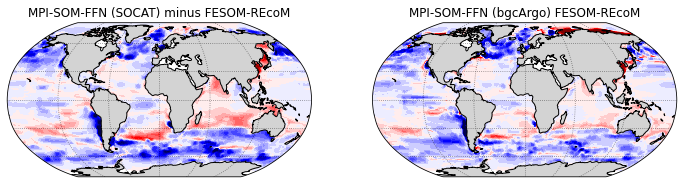

In [39]:
# three times Landschuetzer minus fesom

cmap = cm.seismic_r


fig, ax = plt.subplots(
            1,
            2,
            subplot_kw=dict(projection=ccrs.Robinson()),
            constrained_layout=False,
            figsize=(12,4),sharex=True,sharey=True,
        )

ax = ax.flatten()



#----------------------------------------------------------------------
# 3. landschuetzer, A:
x3 = land_fgco2_A_2009_2018 - fesom_fgco2_2009_2018
x_m3 = np.ma.array(x3, mask=np.isnan(x3))
levels=np.arange(-3,3.2,0.2)
image3 = ax[0].contourf(xax,yax,x_m3, levels, cmap=cmap,extend='both',transform=ccrs.PlateCarree())
ax[0].set_title('MPI-SOM-FFN (SOCAT) minus FESOM-REcoM')
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# ax[0].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[0].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[0].coastlines()
ax[0].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 

# #----------------------------------------------------------------------
# # 4. landschuetzer, B:
# x4 = land_fgco2_B_2009_2018 - fesom_fgco2_2009_2018
# x_m4 = np.ma.array(x4, mask=np.isnan(x4))
# image4 = ax[1].pcolor(xax,yax,x_m4, vmin=-3, vmax=3, cmap=cmap)
# ax[1].set_title('MPI-SOM-FFN minus FESOM-REcoM, SOCAT+SOCCOM')
# ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())

# ax[1].coastlines()
#----------------------------------------------------------------------
# 5. landschuetzer, C:
x5 = land_fgco2_C_2009_2018 -fesom_fgco2_2009_2018
x_m5 = np.ma.array(x5, mask=np.isnan(x5))
image5 = ax[1].contourf(xax,yax,x_m5, levels, cmap=cmap,extend='both',transform=ccrs.PlateCarree())
ax[1].set_title('MPI-SOM-FFN (bgcArgo) FESOM-REcoM')
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[1].coastlines()
ax[1].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 




# # plt.colorbar()    
# plt.subplots_adjust(top=0.9, bottom=0.2, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

# cbar2_ax = fig.add_axes([0.2, 0.001, 0.66, 0.06])
# cbar2 = fig.colorbar(image3,
#                     cax = cbar2_ax, 
#                     orientation = 'horizontal',
#                     pad=0.01, shrink=0.9, extend='both') 
# cbar2.set_label('Air-Sea CO$_2$ exchange [mol m$^{-2}$ yr$^{-1}$]', fontsize=16)
# cbar2.ax.tick_params(labelsize=14)


plt.savefig('LminusF_CO2flux_map_AC_2009_2018_fesomkw.png',transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('LminusF_CO2flux_map_AC_2009_2018_fesomkw.eps',transparent=False, bbox_inches='tight')
plt.savefig('LminusF_CO2flux_map_AC_2009_2018_fesomkw.pdf',transparent=False, bbox_inches='tight')

plt.show()




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

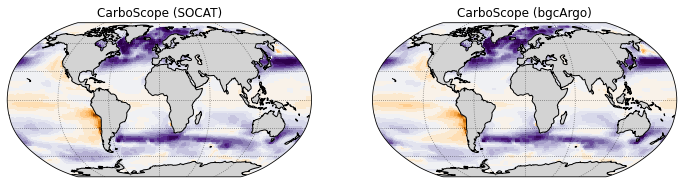

In [40]:
# three times Rödenbeck



fig, ax = plt.subplots(
            1,
            2,
            subplot_kw=dict(projection=ccrs.Robinson()),
            constrained_layout=False,
            figsize=(12,4),sharex=True,sharey=True,
        )

ax = ax.flatten()



#----------------------------------------------------------------------
# 3. roedenbeck, A:
x3 = roeden_fgco2_A_2009_2018
x_m3 = np.ma.array(x3, mask=np.isnan(x3))
levels = np.arange(-6,6.5,0.5)
image3 = ax[0].contourf(xax,yax,x_m3, levels, cmap=cmap2,extend='both',transform=ccrs.PlateCarree())
ax[0].set_title('CarboScope (SOCAT)')
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# ax[0].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[0].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[0].coastlines()
ax[0].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 

#----------------------------------------------------------------------
# 4. roedenbeck, B:
# x4 = roeden_fgco2_B_2009_2018
# x_m4 = np.ma.array(x4, mask=np.isnan(x4))
# image4 = ax[1].pcolor(xax,yax,x_m4, vmin=-5, vmax=5, cmap=cmap)
# ax[1].set_title('Jena-MLS, SOCAT+ SOCCOM')
# ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())

# ax[1].coastlines()
#----------------------------------------------------------------------
# 5. roedenbeck, C:
x5 = roeden_fgco2_C_2009_2018
x_m5 = np.ma.array(x5, mask=np.isnan(x5))
image5 = ax[1].contourf(xax,yax,x_m5, levels, cmap=cmap2,extend='both',transform=ccrs.PlateCarree())
ax[1].set_title('CarboScope (bgcArgo)')
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[1].coastlines()
ax[1].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 




# plt.colorbar()    
# plt.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

# cbar2_ax = fig.add_axes([0.2, 0.001, 0.66, 0.06])
# cbar2 = fig.colorbar(image3,
#                     cax = cbar2_ax, 
#                     orientation = 'horizontal',
#                     pad=0.01, shrink=0.9, extend='both') 
# cbar2.set_label('Air-Sea CO$_2$ exchange [mol m$^{-2}$ yr$^{-1}$]', fontsize=16)
# cbar2.ax.tick_params(labelsize=14)


plt.savefig('R_CO2flux_map_AC_2009_2018.png',transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('R_CO2flux_map_AC_2009_2018.eps',transparent=False, bbox_inches='tight')
plt.savefig('R_CO2flux_map_AC_2009_2018.pdf',transparent=False, bbox_inches='tight')

plt.show()


<ipython-input-41-ff7436779422>:61: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar2 = fig.colorbar(image3,
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists w

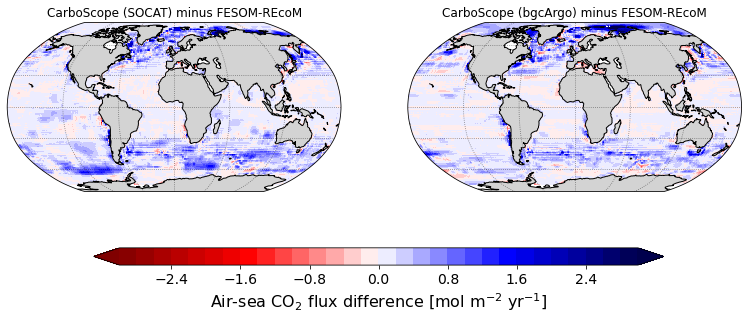

In [41]:
# three times Roedenbeck minus fesom

cmap = cm.seismic_r


fig, ax = plt.subplots(
            1,
            2,
            subplot_kw=dict(projection=ccrs.Robinson()),
            constrained_layout=False,
            figsize=(12,4),sharex=True,sharey=True,
        )

ax = ax.flatten()



#----------------------------------------------------------------------
# 3. roedenbeck, A:
x3 = roeden_fgco2_A_2009_2018 - fesom_fgco2_2009_2018
x_m3 = np.ma.array(x3, mask=np.isnan(x3))
levels=np.arange(-3,3.2,0.2)
image3 = ax[0].contourf(xax,yax,x_m3,levels, cmap=cmap,extend='both',transform=ccrs.PlateCarree())
ax[0].set_title('CarboScope (SOCAT) minus FESOM-REcoM')
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# ax[0].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[0].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[0].coastlines()
ax[0].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 

#----------------------------------------------------------------------
# 4. roedenbeck, B:
# x4 = roeden_fgco2_B_2009_2018 - fesom_fgco2_2009_2018
# x_m4 = np.ma.array(x4, mask=np.isnan(x4))
# image4 = ax[1].pcolor(xax,yax,x_m4, vmin=-3, vmax=3, cmap=cmap)
# ax[1].set_title('Jena-MLS minus FESOM-REcoM, SOCAT+SOCCOM')
# ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())

# ax[1].coastlines()
#----------------------------------------------------------------------
# 5. roedenbeck, C:
x5 = roeden_fgco2_C_2009_2018 -fesom_fgco2_2009_2018
x_m5 = np.ma.array(x5, mask=np.isnan(x5))
image5 = ax[1].contourf(xax,yax,x_m5, levels, cmap=cmap,extend='both',transform=ccrs.PlateCarree())
ax[1].set_title('CarboScope (bgcArgo) minus FESOM-REcoM')
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[1].coastlines()
ax[1].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 




# plt.colorbar()    
plt.subplots_adjust(top=0.9, bottom=0.2, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

cbar2_ax = fig.add_axes([0.2, 0.001, 0.66, 0.06])
cbar2 = fig.colorbar(image3,
                    cax = cbar2_ax, 
                    orientation = 'horizontal',
                    pad=0.01, shrink=0.9, extend='both') 
cbar2.set_label('Air-sea CO$_2$ flux difference [mol m$^{-2}$ yr$^{-1}$]', fontsize=16)
cbar2.ax.tick_params(labelsize=14)


plt.savefig('RminusF_CO2flux_map_AC_2009_2018.png',transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('RminusF_CO2flux_map_AC_2009_2018.pdf',transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('RminusF_CO2flux_map_AC_2009_2018.eps', dpi=300, bbox_inches='tight')

plt.show()

(180, 360)


/home/ollie/jhauck/.conda/envs/pyfesom2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be 

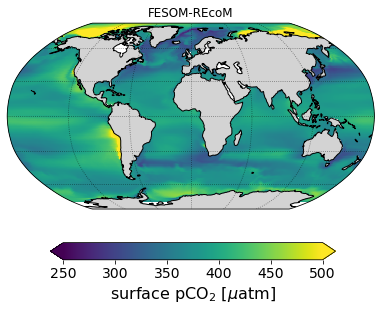

In [42]:
# pCO2 maps


cmap = cm.viridis




fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.Robinson()),
            constrained_layout=False,
            figsize=(6,4),sharex=True,sharey=True,
        )

#ax = ax.flatten()


# first one: fesom only



x = fesom_spco2_2009_2018
x_m = np.ma.array(x, mask=np.isnan(x))
print(np.shape(x_m))
image = ax.pcolor(xax,yax,x_m, vmin=250, vmax=500, cmap=cmap,transform=ccrs.PlateCarree())#vmin=np.nanmin(x), vmax=np.nanmax(x)) 
ax.set_title('FESOM-REcoM')
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# ax.set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax.set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
# lon_formatter = LongitudeFormatter(zero_direction_label=True)
# lat_formatter = LatitudeFormatter()
# ax.xaxis.set_major_formatter(lon_formatter)
# ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines()
ax.gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 


#------------
# plt.colorbar()    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

cbar2_ax = fig.add_axes([0.2, 0.001, 0.66, 0.06])
cbar2 = fig.colorbar(image,
                    cax = cbar2_ax, 
                    orientation = 'horizontal',
                    pad=0.01, shrink=0.9, extend='both') 
cbar2.set_label('surface pCO$_2$ [$\mu$atm]', fontsize=16)
cbar2.ax.tick_params(labelsize=14)


plt.savefig('FESOM_spCO2_map_2009_2018.png',transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('FESOM_spCO2_map_2009_2018.eps',bbox_inches='tight')
plt.savefig('FESOM_spCO2_map_2009_2018.pdf',transparent=False, bbox_inches='tight')

plt.show()






/home/ollie/jhauck/.conda/envs/pyfesom2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


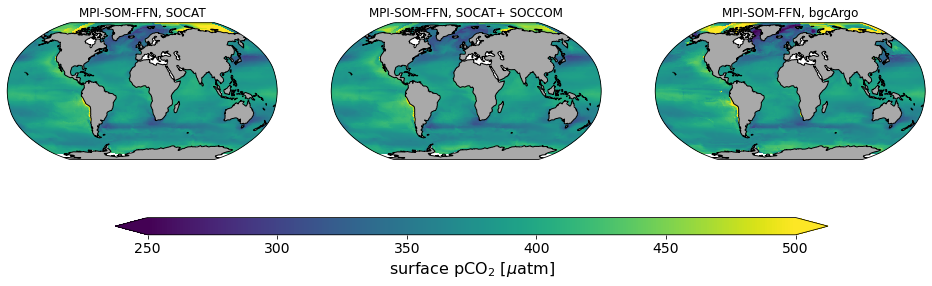

In [43]:
# then the three versions of Landschützer

fig, ax = plt.subplots(
            1,
            3,
            subplot_kw=dict(projection=ccrs.Robinson()),
            constrained_layout=False,
            figsize=(15,4),sharex=True,sharey=True,
        )

ax = ax.flatten()



#----------------------------------------------------------------------
# 3. landschuetzer, A:
x3 = land_spco2_A_2009_2018
x_m3 = np.ma.array(x3, mask=np.isnan(x3))
image3 = ax[0].pcolor(xax,yax,x_m3, vmin=250, vmax=500, cmap=cmap,transform=ccrs.PlateCarree())
ax[0].set_title('MPI-SOM-FFN, SOCAT')
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[0].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[0].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[0].coastlines()

#----------------------------------------------------------------------
# 4. landschuetzer, B:
x4 = land_spco2_B_2009_2018
x_m4 = np.ma.array(x4, mask=np.isnan(x4))
image4 = ax[1].pcolor(xax,yax,x_m4, vmin=250, vmax=500, cmap=cmap,transform=ccrs.PlateCarree())
ax[1].set_title('MPI-SOM-FFN, SOCAT+ SOCCOM')
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())

ax[1].coastlines()
#----------------------------------------------------------------------
# 5. landschuetzer, C:
x5 = land_spco2_C_2009_2018
x_m5 = np.ma.array(x5, mask=np.isnan(x5))
image5 = ax[2].pcolor(xax,yax,x_m5, vmin=250, vmax=500, cmap=cmap,transform=ccrs.PlateCarree())
ax[2].set_title('MPI-SOM-FFN, bgcArgo')
ax[2].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[2].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[2].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[2].coastlines()




# plt.colorbar()    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

cbar2_ax = fig.add_axes([0.2, 0.001, 0.66, 0.06])
cbar2 = fig.colorbar(image3,
                    cax = cbar2_ax, 
                    orientation = 'horizontal',
                    pad=0.01, shrink=0.9, extend='both') 
cbar2.set_label('surface pCO$_2$ [$\mu$atm]', fontsize=16)
cbar2.ax.tick_params(labelsize=14)


plt.savefig('L_spco2_map_ABC_2009_2018.png',transparent=False, dpi=300, bbox_inches='tight')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

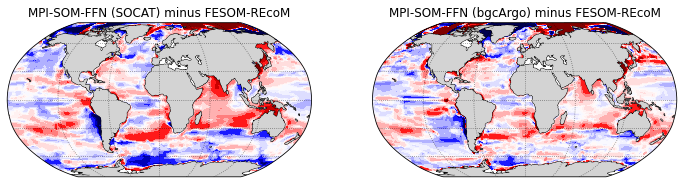

In [44]:
# three times Landschuetzer minus fesom

cmap = cm.seismic


fig, ax = plt.subplots(
            1,
            2,
            subplot_kw=dict(projection=ccrs.Robinson()),
            constrained_layout=False,
            figsize=(12,4),sharex=True,sharey=True,
        )

ax = ax.flatten()



#----------------------------------------------------------------------
# 3. landschuetzer, A:
x3 = land_spco2_A_2009_2018 - fesom_spco2_2009_2018
x_m3 = np.ma.array(x3, mask=np.isnan(x3))
levels=[-50,-40,-30,-15,-10,-5,-2,-1,0,1,2,5,10,15,30,40,50]
image3 = ax[0].contourf(xax,yax,x_m3, levels, cmap=cmap,extend='both',transform=ccrs.PlateCarree())
ax[0].set_title('MPI-SOM-FFN (SOCAT) minus FESOM-REcoM')
# ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[0].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[0].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[0].coastlines()
ax[0].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# #----------------------------------------------------------------------
# # 4. landschuetzer, B:
# x4 = land_spco2_B_2009_2018 - fesom_spco2_2009_2018
# x_m4 = np.ma.array(x4, mask=np.isnan(x4))
# image4 = ax[1].contourf(xax,yax,x_m4, levels, cmap=cmap,extend='both')
# ax[1].set_title('MPI-SOM-FFN minus FESOM-REcoM, SOCAT+SOCCOM')
# ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())

# ax[1].coastlines()
#----------------------------------------------------------------------
# 5. landschuetzer, C:
x5 = land_spco2_C_2009_2018 -fesom_spco2_2009_2018
x_m5 = np.ma.array(x5, mask=np.isnan(x5))
image5 = ax[1].contourf(xax,yax,x_m5, levels, cmap=cmap,extend='both',transform=ccrs.PlateCarree())
ax[1].set_title('MPI-SOM-FFN (bgcArgo) minus FESOM-REcoM')
# ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[1].coastlines()
ax[1].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')



# # plt.colorbar()    
# plt.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

# cbar2_ax = fig.add_axes([0.2, 0.001, 0.66, 0.06])
# cbar2 = fig.colorbar(image3,
#                     cax = cbar2_ax, 
#                     orientation = 'horizontal',
#                     pad=0.01, shrink=0.9, extend='both', ticks=[-50,-30,-10,-5,-2,-1,0,1,2,5,10,30,50]) 
# cbar2.set_label('surface pCO$_2$ [$\mu$atm]', fontsize=16)
# cbar2.ax.tick_params(labelsize=14)
# #cbar2.ax.ticks([-50,-30,-10,-5,-2,-1,0,1,2,5,10,30,50])


plt.savefig('LminusF_spco2_map_AC_2009_2018.png',transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('LminusF_spco2_map_AC_2009_2018.eps',dpi=300, bbox_inches='tight')
plt.savefig('LminusF_spco2_map_AC_2009_2018.pdf',transparent=False, dpi=300, bbox_inches='tight')

plt.show()




/home/ollie/jhauck/.conda/envs/pyfesom2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


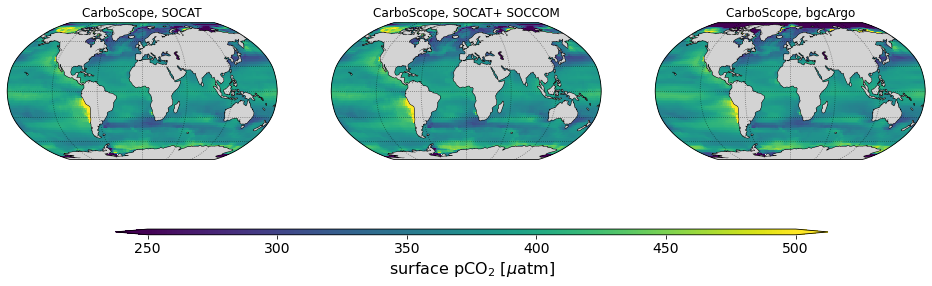

In [45]:
# three times Rödenbeck

cmap = cm.viridis


fig, ax = plt.subplots(
            1,
            3,
            subplot_kw=dict(projection=ccrs.Robinson()),
            constrained_layout=False,
            figsize=(15,4),sharex=True,sharey=True,
        )

ax = ax.flatten()



#----------------------------------------------------------------------
# 3. roedenbeck, A:
x3 = roeden_spco2_A_2009_2018
x_m3 = np.ma.array(x3, mask=np.isnan(x3))
image3 = ax[0].pcolor(xax,yax,x_m3, vmin=250, vmax=500, cmap=cmap,transform=ccrs.PlateCarree())
ax[0].set_title('CarboScope, SOCAT')
# ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[0].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[0].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[0].coastlines()
ax[0].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
#----------------------------------------------------------------------
# 4. roedenbeck, B:
x4 = roeden_spco2_B_2009_2018
x_m4 = np.ma.array(x4, mask=np.isnan(x4))
image4 = ax[1].pcolor(xax,yax,x_m4, vmin=250, vmax=500, cmap=cmap,transform=ccrs.PlateCarree())
ax[1].set_title('CarboScope, SOCAT+ SOCCOM')
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())

ax[1].coastlines()
ax[1].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
#----------------------------------------------------------------------
# 5. roedenbeck, C:
x5 = roeden_spco2_C_2009_2018
x_m5 = np.ma.array(x5, mask=np.isnan(x5))
image5 = ax[2].pcolor(xax,yax,x_m5, vmin=250, vmax=500, cmap=cmap,transform=ccrs.PlateCarree())
ax[2].set_title('CarboScope, bgcArgo')
ax[2].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[2].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[2].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[2].coastlines()
ax[2].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 
ax[2].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')


# plt.colorbar()    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

cbar2_ax = fig.add_axes([0.2, 0.001, 0.66, 0.02])
cbar2 = fig.colorbar(image3,
                    cax = cbar2_ax, 
                    orientation = 'horizontal',
                    pad=0.01, shrink=0.9, extend='both') 
cbar2.set_label('surface pCO$_2$ [$\mu$atm]', fontsize=16)
cbar2.ax.tick_params(labelsize=14)


plt.savefig('R_spco2_map_ABC_2009_2018.png',transparent=False, dpi=300, bbox_inches='tight')
plt.show()


<ipython-input-46-6651538e9100>:64: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar2 = fig.colorbar(image3,
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists w

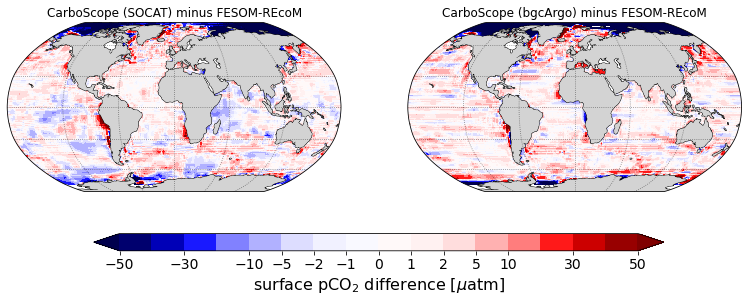

In [46]:
# three times Roedenbeck minus fesom

cmap = cm.seismic


fig, ax = plt.subplots(
            1,
            2,
            subplot_kw=dict(projection=ccrs.Robinson()),
            constrained_layout=False,
            figsize=(12,4),sharex=True,sharey=True,
        )

ax = ax.flatten()



#----------------------------------------------------------------------
# 3. roedenbeck, A:
x3 = roeden_spco2_A_2009_2018 - fesom_spco2_2009_2018
x_m3 = np.ma.array(x3, mask=np.isnan(x3))
levels=[-50,-40,-30,-15,-10,-5,-2,-1,0,1,2,5,10,15,30,40,50]
#norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)

image3 = ax[0].contourf(xax,yax,x_m3, levels,extend='both', cmap=cmap,transform=ccrs.PlateCarree())#,norm=norm)
ax[0].set_title('CarboScope (SOCAT) minus FESOM-REcoM')
# ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[0].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[0].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[0].coastlines()
ax[0].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
# #----------------------------------------------------------------------
# # 4. roedenbeck, B:
# x4 = roeden_spco2_B_2009_2018 - fesom_spco2_2009_2018
# x_m4 = np.ma.array(x4, mask=np.isnan(x4))
# image4 = ax[1].contourf(xax,yax,x_m4, levels,extend='both', cmap=cmap,transform=ccrs.PlateCarree())
# ax[1].set_title('Jena-MLS minus FESOM-REcoM, SOCAT+SOCCOM')
# # ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# # ax[1].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# # ax[1].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
# ax[1].coastlines()
# ax[1].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 
# ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')
#----------------------------------------------------------------------
# 5. roedenbeck, C:
x5 = roeden_spco2_C_2009_2018 -fesom_spco2_2009_2018
x_m5 = np.ma.array(x5, mask=np.isnan(x5))
image5 = ax[1].contourf(xax,yax,x_m5, levels,extend='both', cmap=cmap,transform=ccrs.PlateCarree())#,norm=norm)
ax[1].set_title('CarboScope (bgcArgo) minus FESOM-REcoM')
# ax[2].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='darkgray')
# ax[2].set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
# ax[2].set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
ax[1].coastlines()
ax[1].gridlines(color='black', alpha=0.5, linestyle='dotted') #draw_labels=True, 
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='lightgray')



# plt.colorbar()    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.95, hspace=0.3, wspace=0.2)

cbar2_ax = fig.add_axes([0.2, 0.001, 0.66, 0.06])
cbar2 = fig.colorbar(image3,
                    cax = cbar2_ax, 
                    orientation = 'horizontal',
                    pad=0.01, shrink=0.9, extend='both', ticks=[-50,-30,-10,-5,-2,-1,0,1,2,5,10,30,50]) 
cbar2.set_label('surface pCO$_2$ difference [$\mu$atm]', fontsize=16)
cbar2.ax.tick_params(labelsize=14)


plt.savefig('RminusF_spco2_map_AC_2009_2018.png',transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('RminusF_spco2_map_AC_2009_2018.eps', dpi=300, bbox_inches='tight')
plt.savefig('RminusF_spco2_map_AC_2009_2018.pdf',transparent=False, dpi=300, bbox_inches='tight')

plt.show()